In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_user = np.argmax(state[:4])
        action_mod = 1
        new_loc, reward_user, reward_mod, done = env.step(action_user, action_mod, target_loc, curr_loc)
        
        return new_loc, reward_user, done

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.4 0. ]
 [0.7 0.3]
 [0.9 0.7]
 [0.3 0.5]
 [0.6 0.7]
 [0.5 0.9]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

In [5]:
state = [0.1,0.1,0.3,0.3]
state = np.array(state)
next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
print(next_state, reward,done)

user_agent.replay_buffer.print()

print(user_agent.model(np.array([state])))

[0.1, 0.2, 0.3, 0.3] -1 0
deque([array([0.1, 0.1, 0.3, 0.3])], maxlen=1024)
deque([3], maxlen=1024)
deque([-1], maxlen=1024)
deque([[0.1, 0.2, 0.3, 0.3]], maxlen=1024)
deque([0], maxlen=1024)
tf.Tensor([[-0.022068   -0.06351814 -0.04672146 -0.05356557]], shape=(1, 4), dtype=float32)


  0%|                                                                             | 106/100000 [00:01<30:23, 54.78it/s]

Updated Weights
Mean Reward = -34.039603960396036
19


  0%|▏                                                                            | 205/100000 [00:03<30:57, 53.74it/s]

Updated Weights
Mean Reward = -34.24
18


  0%|▏                                                                            | 306/100000 [00:04<29:54, 55.56it/s]

Updated Weights
Mean Reward = -36.04
12


  0%|▎                                                                            | 408/100000 [00:06<28:26, 58.36it/s]

Updated Weights
Mean Reward = -34.61
17


  0%|▍                                                                            | 496/100000 [00:08<28:36, 57.98it/s]

Updated Weights
Mean Reward = -34.24
16


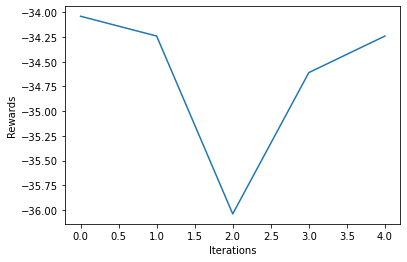

  1%|▍                                                                            | 609/100000 [00:10<29:59, 55.25it/s]

Updated Weights
Mean Reward = -34.84
18


  1%|▌                                                                            | 709/100000 [00:12<28:14, 58.59it/s]

Updated Weights
Mean Reward = -35.54
12


  1%|▌                                                                            | 809/100000 [00:13<28:03, 58.93it/s]

Updated Weights
Mean Reward = -34.2
19


  1%|▋                                                                            | 908/100000 [00:15<27:50, 59.33it/s]

Updated Weights
Mean Reward = -31.88
25


  1%|▊                                                                            | 996/100000 [00:17<27:56, 59.06it/s]

Updated Weights
Mean Reward = -34.03
16


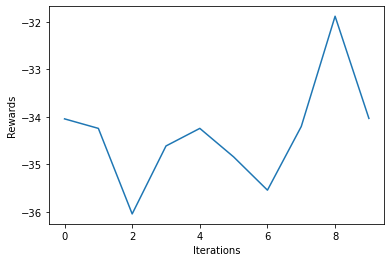

  1%|▊                                                                           | 1105/100000 [00:19<37:14, 44.25it/s]

Updated Weights
Mean Reward = -35.3
13


  1%|▉                                                                           | 1205/100000 [00:21<37:39, 43.73it/s]

Updated Weights
Mean Reward = -34.24
15


  1%|▉                                                                           | 1306/100000 [00:24<35:42, 46.07it/s]

Updated Weights
Mean Reward = -35.35
15


  1%|█                                                                           | 1405/100000 [00:26<37:01, 44.38it/s]

Updated Weights
Mean Reward = -33.08
21


  1%|█▏                                                                          | 1496/100000 [00:28<37:01, 44.33it/s]

Updated Weights
Mean Reward = -35.95
13


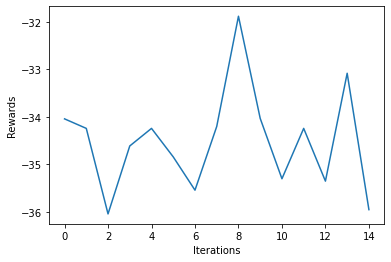

  2%|█▏                                                                          | 1608/100000 [00:31<37:45, 43.42it/s]

Updated Weights
Mean Reward = -34.4
14


  2%|█▎                                                                          | 1707/100000 [00:33<38:26, 42.62it/s]

Updated Weights
Mean Reward = -33.54
19


  2%|█▎                                                                          | 1804/100000 [00:35<36:54, 44.34it/s]

Updated Weights
Mean Reward = -32.14
22


  2%|█▍                                                                          | 1907/100000 [00:37<35:28, 46.09it/s]

Updated Weights
Mean Reward = -33.41
18


  2%|█▌                                                                          | 2000/100000 [00:39<35:36, 45.87it/s]

Updated Weights
Mean Reward = -37.2
10


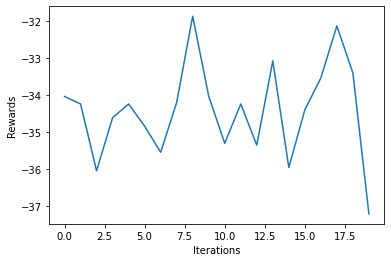

  2%|█▌                                                                          | 2107/100000 [00:42<47:38, 34.24it/s]

Updated Weights
Mean Reward = -35.3
13


  2%|█▋                                                                          | 2205/100000 [00:45<47:14, 34.50it/s]

Updated Weights
Mean Reward = -35.99
11


  2%|█▋                                                                        | 2304/100000 [00:49<1:18:27, 20.75it/s]

Updated Weights
Mean Reward = -37.82
6


  2%|█▊                                                                        | 2405/100000 [00:52<1:00:19, 26.97it/s]

Updated Weights
Mean Reward = -35.5
14


  2%|█▉                                                                          | 2498/100000 [00:55<56:40, 28.67it/s]

Updated Weights
Mean Reward = -33.8
19


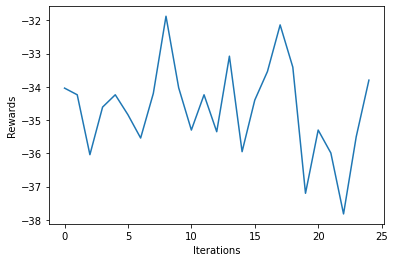

  3%|█▉                                                                          | 2604/100000 [00:58<42:37, 38.08it/s]

Updated Weights
Mean Reward = -35.48
14


  3%|██                                                                          | 2706/100000 [01:01<44:23, 36.53it/s]

Updated Weights
Mean Reward = -35.99
10


  3%|██▏                                                                         | 2808/100000 [01:04<42:10, 38.41it/s]

Updated Weights
Mean Reward = -35.87
12


  3%|██▏                                                                         | 2903/100000 [01:07<50:38, 31.96it/s]

Updated Weights
Mean Reward = -32.93
18


  3%|██▎                                                                         | 2996/100000 [01:09<42:42, 37.85it/s]

Updated Weights
Mean Reward = -35.57
13


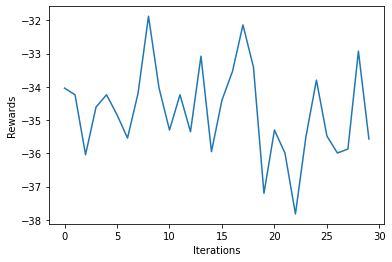

  3%|██▎                                                                         | 3106/100000 [01:13<52:00, 31.05it/s]

Updated Weights
Mean Reward = -34.81
15


  3%|██▍                                                                         | 3203/100000 [01:16<53:03, 30.41it/s]

Updated Weights
Mean Reward = -37.06
8


  3%|██▌                                                                         | 3306/100000 [01:19<51:50, 31.09it/s]

Updated Weights
Mean Reward = -37.24
8


  3%|██▌                                                                         | 3405/100000 [01:23<47:52, 33.62it/s]

Updated Weights
Mean Reward = -35.92
13


  4%|██▋                                                                         | 3500/100000 [01:26<52:04, 30.89it/s]

Updated Weights
Mean Reward = -35.54
12


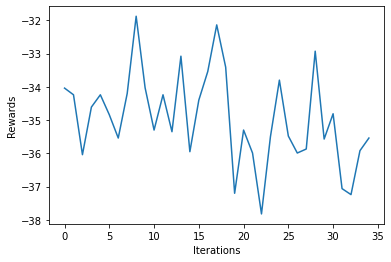

  4%|██▋                                                                         | 3601/100000 [01:29<53:15, 30.16it/s]

Updated Weights
Mean Reward = -34.96
15


  4%|██▊                                                                         | 3708/100000 [01:32<45:44, 35.09it/s]

Updated Weights
Mean Reward = -36.34
11


  4%|██▉                                                                         | 3806/100000 [01:35<46:40, 34.35it/s]

Updated Weights
Mean Reward = -34.85
13


  4%|██▉                                                                         | 3907/100000 [01:39<48:49, 32.80it/s]

Updated Weights
Mean Reward = -36.88
10


  4%|███                                                                         | 3997/100000 [01:42<56:34, 28.28it/s]

Updated Weights
Mean Reward = -35.94
11


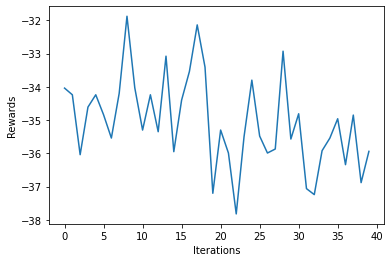

  4%|███                                                                         | 4106/100000 [01:46<56:30, 28.29it/s]

Updated Weights
Mean Reward = -35.86
11


  4%|███▏                                                                        | 4206/100000 [01:50<54:08, 29.49it/s]

Updated Weights
Mean Reward = -33.13
20


  4%|███▎                                                                        | 4304/100000 [01:53<50:12, 31.77it/s]

Updated Weights
Mean Reward = -31.57
26


  4%|███▎                                                                        | 4407/100000 [01:57<53:00, 30.05it/s]

Updated Weights
Mean Reward = -34.82
19


  4%|███▍                                                                        | 4498/100000 [01:59<53:20, 29.84it/s]

Updated Weights
Mean Reward = -30.08
30


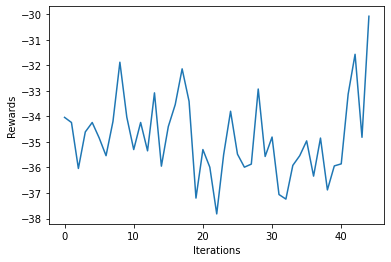

  5%|███▌                                                                        | 4607/100000 [02:03<49:18, 32.24it/s]

Updated Weights
Mean Reward = -33.65
22


  5%|███▌                                                                        | 4705/100000 [02:06<50:41, 31.33it/s]

Updated Weights
Mean Reward = -33.86
18


  5%|███▋                                                                        | 4805/100000 [02:09<50:45, 31.26it/s]

Updated Weights
Mean Reward = -31.37
25


  5%|███▋                                                                        | 4904/100000 [02:13<54:31, 29.07it/s]

Updated Weights
Mean Reward = -31.31
28


  5%|███▊                                                                        | 4999/100000 [02:16<52:46, 30.01it/s]

Updated Weights
Mean Reward = -31.19
29


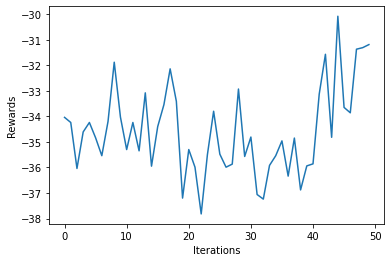

  5%|███▉                                                                        | 5104/100000 [02:19<53:41, 29.46it/s]

Updated Weights
Mean Reward = -26.75
41


  5%|███▉                                                                        | 5206/100000 [02:23<50:35, 31.23it/s]

Updated Weights
Mean Reward = -28.34
36


  5%|████                                                                        | 5305/100000 [02:26<51:29, 30.65it/s]

Updated Weights
Mean Reward = -30.91
25


  5%|████                                                                        | 5407/100000 [02:29<48:55, 32.22it/s]

Updated Weights
Mean Reward = -29.36
31


  6%|████▏                                                                       | 5500/100000 [02:33<51:51, 30.38it/s]

Updated Weights
Mean Reward = -27.72
40


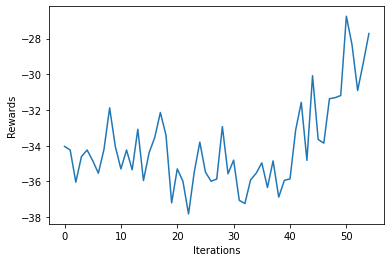

  6%|████▎                                                                       | 5602/100000 [02:36<50:50, 30.95it/s]

Updated Weights
Mean Reward = -28.2
36


  6%|████▎                                                                       | 5703/100000 [02:40<58:32, 26.85it/s]

Updated Weights
Mean Reward = -31.12
30


  6%|████▍                                                                       | 5804/100000 [02:43<49:21, 31.81it/s]

Updated Weights
Mean Reward = -31.49
27


  6%|████▍                                                                       | 5903/100000 [02:46<55:11, 28.41it/s]

Updated Weights
Mean Reward = -26.69
41


  6%|████▌                                                                       | 6000/100000 [02:50<46:03, 34.02it/s]

Updated Weights
Mean Reward = -29.52
35


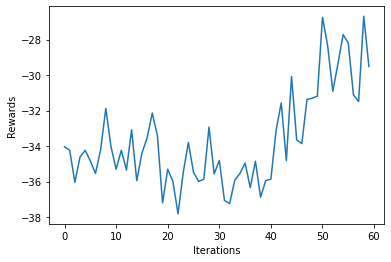

  6%|████▋                                                                       | 6104/100000 [02:54<54:19, 28.81it/s]

Updated Weights
Mean Reward = -28.77
34


  6%|████▌                                                                     | 6205/100000 [02:57<1:04:31, 24.23it/s]

Updated Weights
Mean Reward = -29.83
33


  6%|████▊                                                                       | 6305/100000 [03:01<53:25, 29.23it/s]

Updated Weights
Mean Reward = -27.34
41


  6%|████▊                                                                       | 6403/100000 [03:04<55:44, 27.98it/s]

Updated Weights
Mean Reward = -26.4
46


  6%|████▉                                                                       | 6499/100000 [03:08<56:49, 27.42it/s]

Updated Weights
Mean Reward = -30.31
35


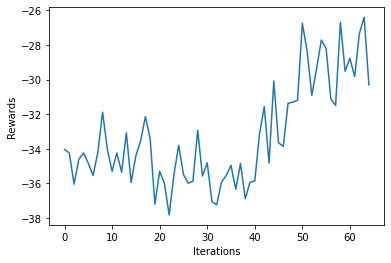

  7%|████▉                                                                     | 6605/100000 [03:12<1:02:23, 24.95it/s]

Updated Weights
Mean Reward = -26.88
39


  7%|████▉                                                                     | 6705/100000 [03:16<1:00:01, 25.90it/s]

Updated Weights
Mean Reward = -26.4
45


  7%|█████▏                                                                      | 6806/100000 [03:19<48:32, 32.00it/s]

Updated Weights
Mean Reward = -26.1
41


  7%|█████▏                                                                      | 6907/100000 [03:23<46:32, 33.33it/s]

Updated Weights
Mean Reward = -26.73
41


  7%|█████▎                                                                      | 6998/100000 [03:26<53:12, 29.13it/s]

Updated Weights
Mean Reward = -27.85
37


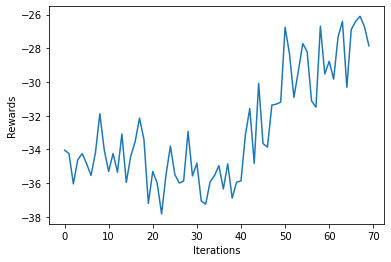

  7%|█████▎                                                                    | 7104/100000 [03:30<1:05:10, 23.76it/s]

Updated Weights
Mean Reward = -27.42
34


  7%|█████▍                                                                      | 7204/100000 [03:34<58:43, 26.34it/s]

Updated Weights
Mean Reward = -28.04
33


  7%|█████▌                                                                      | 7305/100000 [03:37<52:52, 29.21it/s]

Updated Weights
Mean Reward = -26.67
45


  7%|█████▋                                                                      | 7405/100000 [03:41<59:58, 25.73it/s]

Updated Weights
Mean Reward = -28.94
34


  7%|█████▌                                                                    | 7498/100000 [03:45<1:03:17, 24.36it/s]

Updated Weights
Mean Reward = -29.15
35


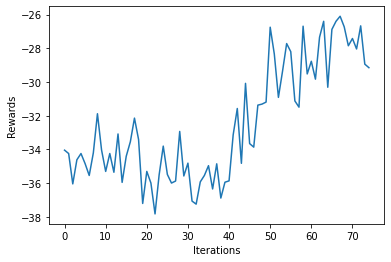

  8%|█████▊                                                                      | 7606/100000 [03:49<59:25, 25.92it/s]

Updated Weights
Mean Reward = -27.11
42


  8%|█████▊                                                                      | 7705/100000 [03:53<50:38, 30.38it/s]

Updated Weights
Mean Reward = -25.68
42


  8%|█████▊                                                                    | 7803/100000 [03:57<1:03:09, 24.33it/s]

Updated Weights
Mean Reward = -29.5
30


  8%|██████                                                                      | 7907/100000 [04:01<53:36, 28.64it/s]

Updated Weights
Mean Reward = -27.47
38


  8%|█████▉                                                                    | 7998/100000 [04:04<1:00:07, 25.50it/s]

Updated Weights
Mean Reward = -27.4
36


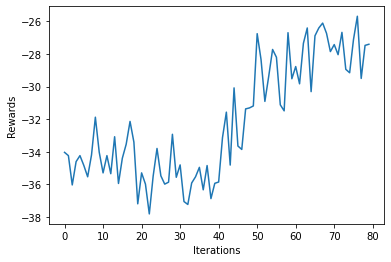

  8%|█████▉                                                                    | 8104/100000 [04:09<1:10:27, 21.74it/s]

Updated Weights
Mean Reward = -32.9
23


  8%|██████                                                                    | 8203/100000 [04:13<1:10:16, 21.77it/s]

Updated Weights
Mean Reward = -28.3
35


  8%|██████▏                                                                   | 8303/100000 [04:17<1:05:28, 23.34it/s]

Updated Weights
Mean Reward = -28.14
35


  8%|██████▏                                                                   | 8405/100000 [04:22<1:05:19, 23.37it/s]

Updated Weights
Mean Reward = -29.3
32


  8%|██████▎                                                                   | 8500/100000 [04:26<1:12:18, 21.09it/s]

Updated Weights
Mean Reward = -30.12
30


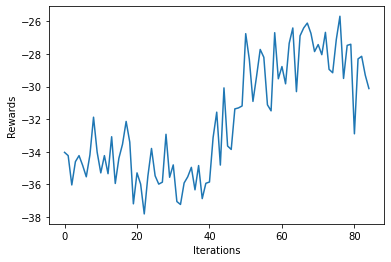

  9%|██████▌                                                                     | 8603/100000 [04:30<52:24, 29.07it/s]

Updated Weights
Mean Reward = -26.07
39


  9%|██████▍                                                                   | 8704/100000 [04:34<1:03:23, 24.00it/s]

Updated Weights
Mean Reward = -26.65
40


  9%|██████▋                                                                     | 8805/100000 [04:38<55:24, 27.43it/s]

Updated Weights
Mean Reward = -27.98
36


  9%|██████▌                                                                   | 8904/100000 [04:41<1:03:14, 24.01it/s]

Updated Weights
Mean Reward = -23.09
45


  9%|██████▋                                                                   | 8998/100000 [04:45<1:05:43, 23.08it/s]

Updated Weights
Mean Reward = -28.84
33


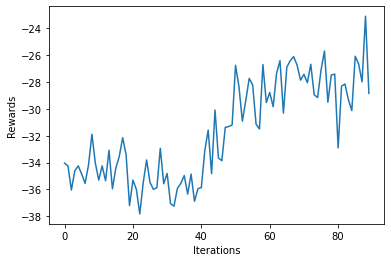

  9%|██████▋                                                                   | 9103/100000 [04:50<1:05:29, 23.13it/s]

Updated Weights
Mean Reward = -29.81
30


  9%|██████▉                                                                     | 9205/100000 [04:55<59:02, 25.63it/s]

Updated Weights
Mean Reward = -26.48
42


  9%|██████▉                                                                   | 9304/100000 [04:59<1:06:08, 22.85it/s]

Updated Weights
Mean Reward = -26.48
39


  9%|██████▉                                                                   | 9404/100000 [05:04<1:27:56, 17.17it/s]

Updated Weights
Mean Reward = -26.14
38


 10%|███████                                                                   | 9500/100000 [05:09<1:29:12, 16.91it/s]

Updated Weights
Mean Reward = -24.6
45


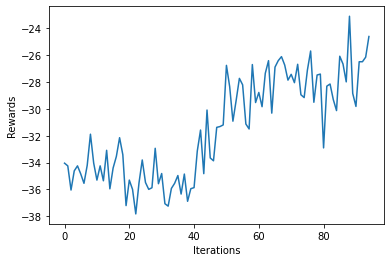

 10%|███████▎                                                                    | 9604/100000 [05:16<59:16, 25.42it/s]

Updated Weights
Mean Reward = -25.22
40


 10%|███████▏                                                                  | 9705/100000 [05:21<1:07:01, 22.45it/s]

Updated Weights
Mean Reward = -34.0
18


 10%|███████▎                                                                  | 9805/100000 [05:25<1:11:32, 21.01it/s]

Updated Weights
Mean Reward = -30.8
26


 10%|███████▎                                                                  | 9903/100000 [05:30<1:04:44, 23.19it/s]

Updated Weights
Mean Reward = -25.53
40


 10%|███████▎                                                                 | 10000/100000 [05:35<1:34:01, 15.95it/s]

Updated Weights
Mean Reward = -25.08
45


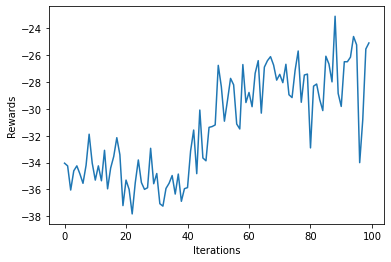

 10%|███████▍                                                                 | 10103/100000 [05:40<1:07:08, 22.31it/s]

Updated Weights
Mean Reward = -28.64
34


 10%|███████▍                                                                 | 10206/100000 [05:45<1:01:04, 24.50it/s]

Updated Weights
Mean Reward = -27.48
38


 10%|███████▌                                                                 | 10304/100000 [05:50<1:38:35, 15.16it/s]

Updated Weights
Mean Reward = -28.3
36


 10%|███████▌                                                                 | 10404/100000 [05:55<1:00:18, 24.76it/s]

Updated Weights
Mean Reward = -26.9
38


 10%|███████▋                                                                 | 10499/100000 [06:00<1:12:26, 20.59it/s]

Updated Weights
Mean Reward = -27.94
36


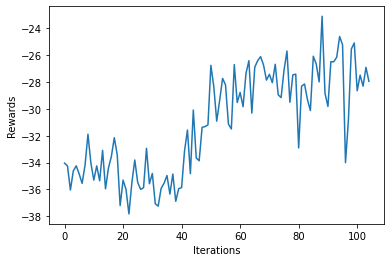

 11%|███████▋                                                                 | 10603/100000 [06:08<1:19:40, 18.70it/s]

Updated Weights
Mean Reward = -28.24
36


 11%|███████▊                                                                 | 10704/100000 [06:13<1:05:46, 22.63it/s]

Updated Weights
Mean Reward = -27.78
36


 11%|███████▉                                                                 | 10804/100000 [06:19<1:23:04, 17.89it/s]

Updated Weights
Mean Reward = -30.67
27


 11%|███████▉                                                                 | 10903/100000 [06:23<1:15:37, 19.64it/s]

Updated Weights
Mean Reward = -25.92
40


 11%|████████                                                                 | 10999/100000 [06:28<1:04:13, 23.10it/s]

Updated Weights
Mean Reward = -26.02
41


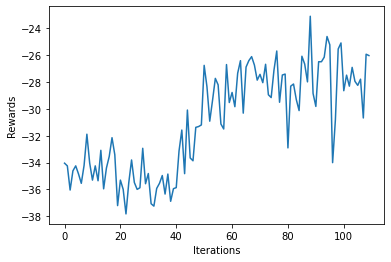

 11%|████████                                                                 | 11105/100000 [06:33<1:13:55, 20.04it/s]

Updated Weights
Mean Reward = -29.43
31


 11%|████████▏                                                                | 11203/100000 [06:37<1:13:22, 20.17it/s]

Updated Weights
Mean Reward = -28.84
31


 11%|████████▎                                                                | 11305/100000 [06:43<1:16:39, 19.28it/s]

Updated Weights
Mean Reward = -31.47
25


 11%|████████▎                                                                | 11402/100000 [06:49<1:13:41, 20.04it/s]

Updated Weights
Mean Reward = -24.77
42


 11%|████████▍                                                                | 11499/100000 [06:53<1:23:03, 17.76it/s]

Updated Weights
Mean Reward = -23.21
47


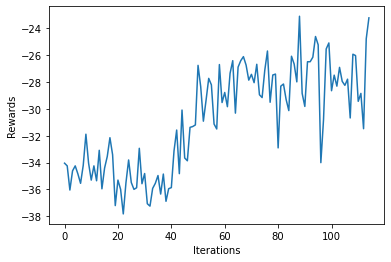

 12%|████████▍                                                                | 11603/100000 [07:00<1:21:41, 18.04it/s]

Updated Weights
Mean Reward = -25.62
41


 12%|████████▌                                                                | 11702/100000 [07:10<4:36:15,  5.33it/s]

Updated Weights
Mean Reward = -28.38
32


 12%|████████▌                                                                | 11803/100000 [07:16<1:05:46, 22.35it/s]

Updated Weights
Mean Reward = -26.2
40


 12%|████████▋                                                                | 11902/100000 [07:21<1:13:07, 20.08it/s]

Updated Weights
Mean Reward = -26.45
42


 12%|████████▊                                                                | 12000/100000 [07:26<1:34:21, 15.54it/s]

Updated Weights
Mean Reward = -29.26
30


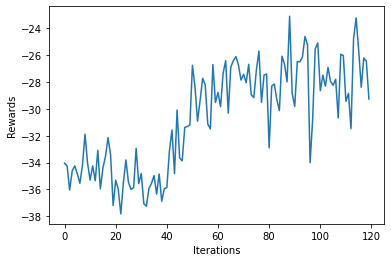

 12%|████████▊                                                                | 12102/100000 [07:32<2:02:22, 11.97it/s]

Updated Weights
Mean Reward = -22.58
48


 12%|████████▉                                                                | 12203/100000 [07:38<1:17:12, 18.95it/s]

Updated Weights
Mean Reward = -24.15
44


 12%|████████▉                                                                | 12303/100000 [07:43<1:10:51, 20.63it/s]

Updated Weights
Mean Reward = -27.6
37


 12%|█████████                                                                | 12402/100000 [07:48<1:11:30, 20.42it/s]

Updated Weights
Mean Reward = -25.58
40


 12%|█████████▏                                                               | 12500/100000 [07:55<3:49:04,  6.37it/s]

Updated Weights
Mean Reward = -24.72
44


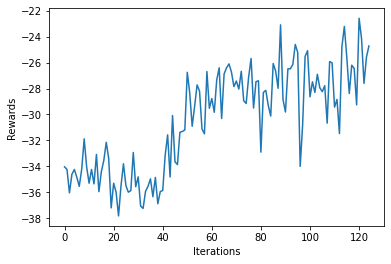

 13%|█████████▏                                                               | 12603/100000 [08:00<1:17:30, 18.79it/s]

Updated Weights
Mean Reward = -26.69
38


 13%|█████████▎                                                               | 12703/100000 [08:11<2:22:43, 10.19it/s]

Updated Weights
Mean Reward = -23.76
49


 13%|█████████▎                                                               | 12804/100000 [08:17<1:24:49, 17.13it/s]

Updated Weights
Mean Reward = -32.0
25


 13%|█████████▍                                                               | 12904/100000 [08:22<1:20:47, 17.97it/s]

Updated Weights
Mean Reward = -28.97
33


 13%|█████████▍                                                               | 13000/100000 [08:28<3:39:18,  6.61it/s]

Updated Weights
Mean Reward = -27.81
34


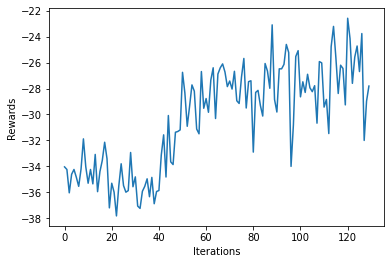

 13%|█████████▌                                                               | 13102/100000 [08:35<1:46:20, 13.62it/s]

Updated Weights
Mean Reward = -29.86
29


 13%|█████████▋                                                               | 13203/100000 [08:45<1:21:24, 17.77it/s]

Updated Weights
Mean Reward = -28.78
33


 13%|█████████▋                                                               | 13303/100000 [08:50<1:25:54, 16.82it/s]

Updated Weights
Mean Reward = -26.05
42


 13%|█████████▊                                                               | 13403/100000 [08:55<1:03:48, 22.62it/s]

Updated Weights
Mean Reward = -22.09
48


 13%|█████████▊                                                               | 13498/100000 [09:01<2:17:01, 10.52it/s]

Updated Weights
Mean Reward = -23.02
46


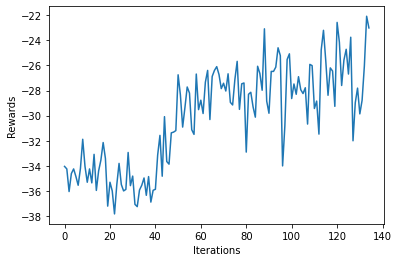

 14%|█████████▉                                                               | 13603/100000 [09:07<1:12:44, 19.79it/s]

Updated Weights
Mean Reward = -29.96
30


 14%|██████████                                                               | 13704/100000 [09:11<1:25:58, 16.73it/s]

Updated Weights
Mean Reward = -22.51
47


 14%|██████████                                                               | 13804/100000 [09:19<1:22:41, 17.37it/s]

Updated Weights
Mean Reward = -24.89
44


 14%|██████████▏                                                              | 13904/100000 [09:24<1:12:39, 19.75it/s]

Updated Weights
Mean Reward = -28.67
32


 14%|██████████▏                                                              | 14000/100000 [09:29<1:22:46, 17.32it/s]

Updated Weights
Mean Reward = -23.07
46


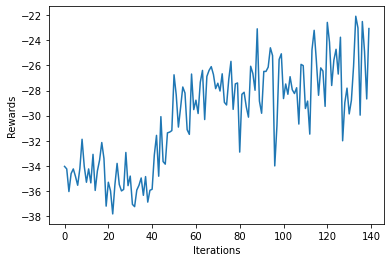

 14%|██████████▎                                                              | 14102/100000 [09:34<1:21:48, 17.50it/s]

Updated Weights
Mean Reward = -23.96
44


 14%|██████████▎                                                              | 14203/100000 [09:46<1:43:12, 13.85it/s]

Updated Weights
Mean Reward = -27.53
35


 14%|██████████▍                                                              | 14303/100000 [09:51<1:12:22, 19.74it/s]

Updated Weights
Mean Reward = -23.88
44


 14%|██████████▌                                                              | 14404/100000 [09:57<1:20:17, 17.77it/s]

Updated Weights
Mean Reward = -30.16
31


 14%|██████████▌                                                              | 14498/100000 [10:03<1:12:44, 19.59it/s]

Updated Weights
Mean Reward = -29.18
36


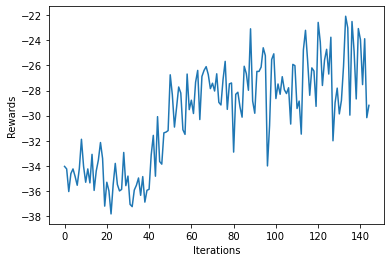

 15%|██████████▋                                                              | 14603/100000 [10:11<3:36:55,  6.56it/s]

Updated Weights
Mean Reward = -28.25
33


 15%|██████████▋                                                              | 14704/100000 [10:17<1:12:37, 19.57it/s]

Updated Weights
Mean Reward = -28.92
30


 15%|███████████                                                                | 14805/100000 [10:21<56:04, 25.32it/s]

Updated Weights
Mean Reward = -17.44
62


 15%|██████████▉                                                              | 14905/100000 [10:25<1:09:20, 20.45it/s]

Updated Weights
Mean Reward = -20.38
54


 15%|██████████▉                                                              | 15000/100000 [10:30<1:09:04, 20.51it/s]

Updated Weights
Mean Reward = -18.35
60


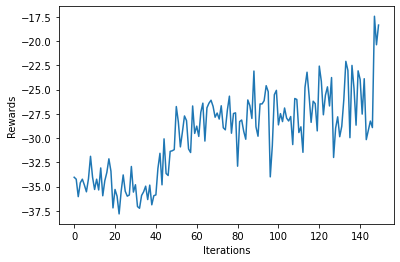

 15%|███████████                                                              | 15103/100000 [10:39<1:23:12, 17.01it/s]

Updated Weights
Mean Reward = -32.91
20


 15%|███████████▍                                                               | 15204/100000 [10:43<53:06, 26.61it/s]

Updated Weights
Mean Reward = -23.67
48


 15%|███████████▏                                                             | 15304/100000 [10:49<1:12:16, 19.53it/s]

Updated Weights
Mean Reward = -28.46
31


 15%|███████████▏                                                             | 15402/100000 [10:54<1:14:24, 18.95it/s]

Updated Weights
Mean Reward = -27.88
35


 15%|███████████▎                                                             | 15498/100000 [10:59<1:05:38, 21.46it/s]

Updated Weights
Mean Reward = -21.34
51


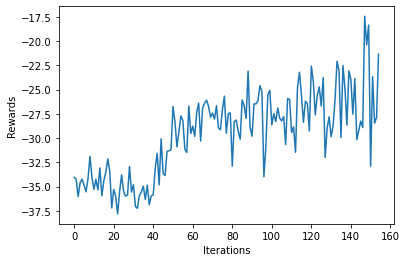

 16%|███████████▍                                                             | 15603/100000 [11:04<1:09:28, 20.24it/s]

Updated Weights
Mean Reward = -22.67
46


 16%|███████████▍                                                             | 15703/100000 [11:08<1:00:05, 23.38it/s]

Updated Weights
Mean Reward = -20.23
57


 16%|███████████▌                                                             | 15803/100000 [11:15<2:20:18, 10.00it/s]

Updated Weights
Mean Reward = -28.5
34


 16%|███████████▌                                                             | 15906/100000 [11:19<1:00:20, 23.23it/s]

Updated Weights
Mean Reward = -23.52
45


 16%|███████████▋                                                             | 16000/100000 [11:23<1:12:09, 19.40it/s]

Updated Weights
Mean Reward = -21.17
53


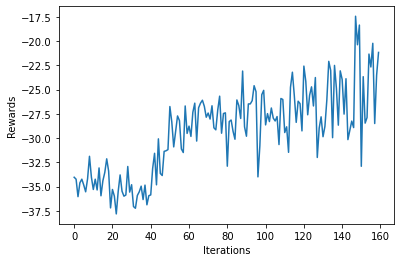

 16%|████████████                                                               | 16107/100000 [11:28<55:02, 25.40it/s]

Updated Weights
Mean Reward = -17.6
63


 16%|███████████▊                                                             | 16204/100000 [11:33<1:04:02, 21.81it/s]

Updated Weights
Mean Reward = -26.41
38


 16%|███████████▉                                                             | 16303/100000 [11:38<1:10:01, 19.92it/s]

Updated Weights
Mean Reward = -28.6
33


 16%|███████████▉                                                             | 16403/100000 [11:43<1:17:03, 18.08it/s]

Updated Weights
Mean Reward = -29.46
32


 16%|████████████                                                             | 16499/100000 [11:48<1:06:02, 21.07it/s]

Updated Weights
Mean Reward = -24.05
45


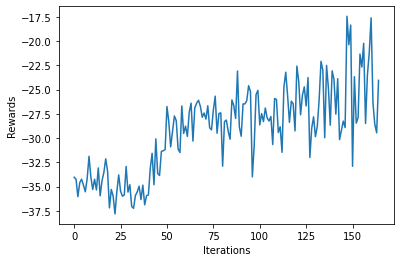

 17%|████████████                                                             | 16604/100000 [11:53<1:06:49, 20.80it/s]

Updated Weights
Mean Reward = -22.71
49


 17%|████████████▏                                                            | 16703/100000 [11:57<1:03:39, 21.81it/s]

Updated Weights
Mean Reward = -20.53
51


 17%|████████████▎                                                            | 16804/100000 [12:02<1:10:20, 19.71it/s]

Updated Weights
Mean Reward = -25.41
42


 17%|████████████▎                                                            | 16903/100000 [12:07<1:02:39, 22.10it/s]

Updated Weights
Mean Reward = -30.99
25


 17%|████████████▍                                                            | 16997/100000 [12:11<1:03:56, 21.64it/s]

Updated Weights
Mean Reward = -23.04
46


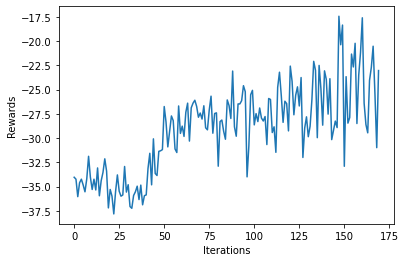

 17%|████████████▍                                                            | 17104/100000 [12:17<1:16:41, 18.02it/s]

Updated Weights
Mean Reward = -31.47
22


 17%|████████████▌                                                            | 17203/100000 [12:22<1:11:37, 19.27it/s]

Updated Weights
Mean Reward = -25.42
43


 17%|████████████▋                                                            | 17304/100000 [12:27<1:06:41, 20.67it/s]

Updated Weights
Mean Reward = -20.52
53


 17%|████████████▋                                                            | 17403/100000 [12:31<1:03:40, 21.62it/s]

Updated Weights
Mean Reward = -22.08
48


 18%|████████████▊                                                            | 17500/100000 [12:36<1:23:43, 16.42it/s]

Updated Weights
Mean Reward = -28.48
32


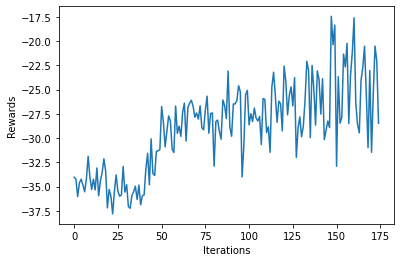

 18%|████████████▊                                                            | 17603/100000 [12:41<1:09:17, 19.82it/s]

Updated Weights
Mean Reward = -26.54
39


 18%|████████████▉                                                            | 17705/100000 [12:46<1:01:45, 22.21it/s]

Updated Weights
Mean Reward = -23.02
44


 18%|████████████▉                                                            | 17802/100000 [12:51<1:08:51, 19.90it/s]

Updated Weights
Mean Reward = -30.12
28


 18%|█████████████                                                            | 17903/100000 [12:57<1:24:12, 16.25it/s]

Updated Weights
Mean Reward = -27.12
37


 18%|█████████████▏                                                           | 18000/100000 [13:02<1:15:19, 18.14it/s]

Updated Weights
Mean Reward = -31.65
22


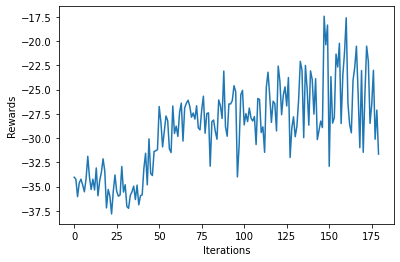

 18%|█████████████▌                                                             | 18105/100000 [13:08<55:07, 24.76it/s]

Updated Weights
Mean Reward = -27.82
36


 18%|█████████████▎                                                           | 18203/100000 [13:12<1:15:49, 17.98it/s]

Updated Weights
Mean Reward = -22.82
44


 18%|█████████████▎                                                           | 18303/100000 [13:18<1:18:35, 17.33it/s]

Updated Weights
Mean Reward = -29.1
35


 18%|█████████████▍                                                           | 18402/100000 [13:23<1:12:30, 18.76it/s]

Updated Weights
Mean Reward = -26.32
40


 18%|█████████████▌                                                           | 18500/100000 [13:27<1:03:36, 21.35it/s]

Updated Weights
Mean Reward = -22.53
46


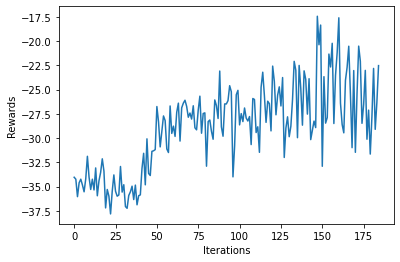

 19%|█████████████▉                                                             | 18602/100000 [13:32<58:22, 23.24it/s]

Updated Weights
Mean Reward = -18.84
58


 19%|█████████████▋                                                           | 18705/100000 [13:37<1:03:16, 21.41it/s]

Updated Weights
Mean Reward = -24.22
46


 19%|█████████████▋                                                           | 18804/100000 [13:43<2:57:32,  7.62it/s]

Updated Weights
Mean Reward = -26.78
34


 19%|█████████████▊                                                           | 18906/100000 [13:48<1:02:48, 21.52it/s]

Updated Weights
Mean Reward = -27.7
38


 19%|█████████████▊                                                           | 18999/100000 [13:53<1:19:06, 17.06it/s]

Updated Weights
Mean Reward = -26.18
36


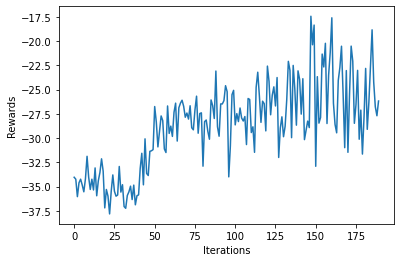

 19%|█████████████▉                                                           | 19105/100000 [13:59<1:07:16, 20.04it/s]

Updated Weights
Mean Reward = -26.65
39


 19%|██████████████                                                           | 19203/100000 [14:04<1:03:15, 21.29it/s]

Updated Weights
Mean Reward = -27.73
33


 19%|██████████████                                                           | 19302/100000 [14:09<1:05:42, 20.47it/s]

Updated Weights
Mean Reward = -25.7
39


 19%|██████████████▏                                                          | 19404/100000 [14:13<1:10:58, 18.93it/s]

Updated Weights
Mean Reward = -21.41
52


 19%|██████████████▌                                                            | 19498/100000 [14:18<59:33, 22.52it/s]

Updated Weights
Mean Reward = -23.02
50


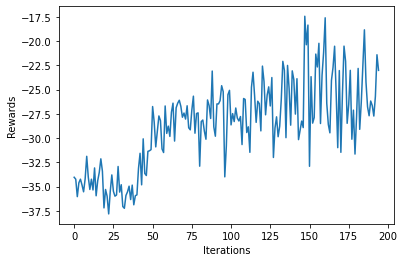

 20%|██████████████▎                                                          | 19603/100000 [14:24<1:10:41, 18.95it/s]

Updated Weights
Mean Reward = -25.94
36


 20%|██████████████▍                                                          | 19704/100000 [14:29<1:03:45, 20.99it/s]

Updated Weights
Mean Reward = -25.32
42


 20%|██████████████▍                                                          | 19804/100000 [14:33<1:11:51, 18.60it/s]

Updated Weights
Mean Reward = -22.33
50


 20%|██████████████▌                                                          | 19903/100000 [14:38<1:02:09, 21.48it/s]

Updated Weights
Mean Reward = -22.69
45


 20%|██████████████▌                                                          | 19998/100000 [14:43<1:03:12, 21.09it/s]

Updated Weights
Mean Reward = -23.99
45


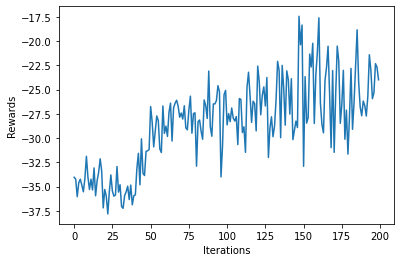

 20%|██████████████▋                                                          | 20103/100000 [14:49<1:27:54, 15.15it/s]

Updated Weights
Mean Reward = -35.82
10


 20%|██████████████▋                                                          | 20202/100000 [14:55<1:10:07, 18.97it/s]

Updated Weights
Mean Reward = -30.39
24


 20%|██████████████▊                                                          | 20304/100000 [15:00<1:09:15, 19.18it/s]

Updated Weights
Mean Reward = -33.91
16


 20%|███████████████▎                                                           | 20402/100000 [15:05<57:56, 22.90it/s]

Updated Weights
Mean Reward = -19.54
56


 20%|██████████████▉                                                          | 20498/100000 [15:10<1:05:13, 20.31it/s]

Updated Weights
Mean Reward = -25.88
39


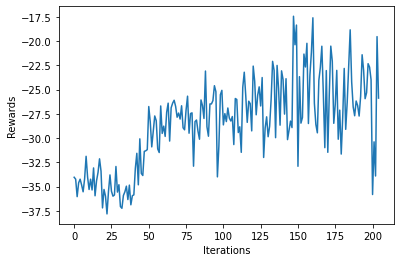

 21%|███████████████                                                          | 20602/100000 [15:15<1:03:51, 20.72it/s]

Updated Weights
Mean Reward = -28.62
33


 21%|███████████████▌                                                           | 20701/100000 [15:20<52:36, 25.12it/s]

Updated Weights
Mean Reward = -19.57
53


 21%|███████████████▏                                                         | 20805/100000 [15:25<1:03:24, 20.82it/s]

Updated Weights
Mean Reward = -27.15
32


 21%|███████████████▎                                                         | 20904/100000 [15:30<1:03:35, 20.73it/s]

Updated Weights
Mean Reward = -20.4
54


 21%|███████████████▋                                                           | 20998/100000 [15:34<50:42, 25.97it/s]

Updated Weights
Mean Reward = -24.55
41


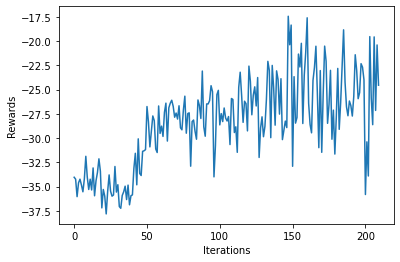

 21%|███████████████▍                                                         | 21102/100000 [15:40<1:20:41, 16.30it/s]

Updated Weights
Mean Reward = -30.03
28


 21%|███████████████▍                                                         | 21202/100000 [15:47<3:32:56,  6.17it/s]

Updated Weights
Mean Reward = -28.06
36


 21%|███████████████▌                                                         | 21302/100000 [15:57<1:38:53, 13.26it/s]

Updated Weights
Mean Reward = -30.75
26


 21%|███████████████▌                                                         | 21403/100000 [16:07<2:03:55, 10.57it/s]

Updated Weights
Mean Reward = -25.42
38


 21%|███████████████▋                                                         | 21499/100000 [16:12<1:11:42, 18.24it/s]

Updated Weights
Mean Reward = -21.79
48


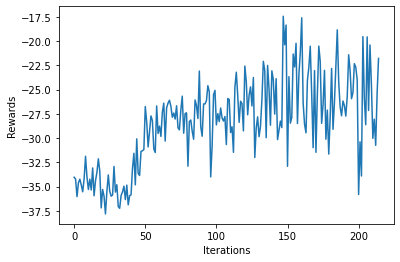

 22%|███████████████▊                                                         | 21604/100000 [16:18<1:16:34, 17.06it/s]

Updated Weights
Mean Reward = -33.2
19


 22%|███████████████▊                                                         | 21704/100000 [16:24<1:27:04, 14.99it/s]

Updated Weights
Mean Reward = -28.2
29


 22%|███████████████▉                                                         | 21802/100000 [16:30<1:22:38, 15.77it/s]

Updated Weights
Mean Reward = -32.59
20


 22%|████████████████▍                                                          | 21903/100000 [16:35<59:49, 21.76it/s]

Updated Weights
Mean Reward = -24.97
39


 22%|████████████████                                                         | 22000/100000 [16:41<1:23:25, 15.58it/s]

Updated Weights
Mean Reward = -32.16
19


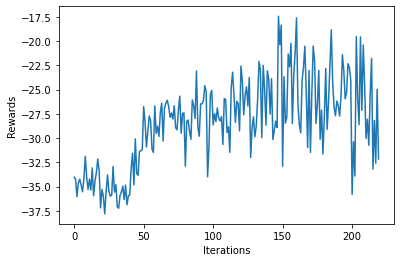

 22%|████████████████▏                                                        | 22103/100000 [16:47<1:09:52, 18.58it/s]

Updated Weights
Mean Reward = -30.98
23


 22%|████████████████▏                                                        | 22204/100000 [16:53<1:10:41, 18.34it/s]

Updated Weights
Mean Reward = -28.64
34


 22%|████████████████▎                                                        | 22304/100000 [16:58<1:16:01, 17.03it/s]

Updated Weights
Mean Reward = -26.75
37


 22%|████████████████▊                                                          | 22403/100000 [17:03<57:31, 22.48it/s]

Updated Weights
Mean Reward = -22.77
45


 22%|████████████████▍                                                        | 22500/100000 [17:08<1:24:40, 15.26it/s]

Updated Weights
Mean Reward = -33.18
19


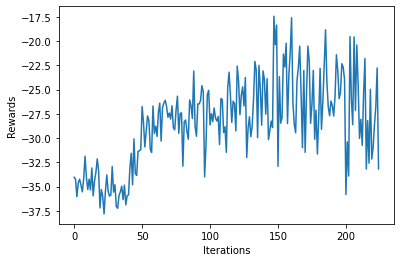

 23%|████████████████▍                                                        | 22602/100000 [17:15<1:23:15, 15.49it/s]

Updated Weights
Mean Reward = -32.97
16


 23%|████████████████▌                                                        | 22704/100000 [17:21<1:06:08, 19.48it/s]

Updated Weights
Mean Reward = -33.04
18


 23%|████████████████▋                                                        | 22802/100000 [17:27<1:22:07, 15.67it/s]

Updated Weights
Mean Reward = -37.09
7


 23%|████████████████▋                                                        | 22902/100000 [17:32<1:08:17, 18.82it/s]

Updated Weights
Mean Reward = -30.43
22


 23%|████████████████▊                                                        | 23000/100000 [17:38<1:20:38, 15.92it/s]

Updated Weights
Mean Reward = -36.72
8


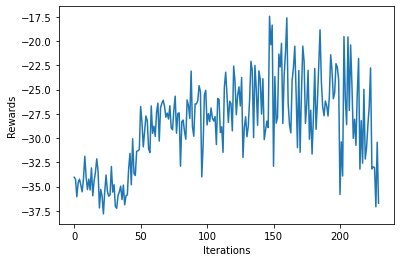

 23%|████████████████▊                                                        | 23103/100000 [17:45<1:23:03, 15.43it/s]

Updated Weights
Mean Reward = -33.6
16


 23%|████████████████▉                                                        | 23203/100000 [17:51<1:16:34, 16.71it/s]

Updated Weights
Mean Reward = -31.82
22


 23%|█████████████████                                                        | 23304/100000 [17:56<1:18:02, 16.38it/s]

Updated Weights
Mean Reward = -26.93
34


 23%|█████████████████                                                        | 23404/100000 [18:02<1:20:38, 15.83it/s]

Updated Weights
Mean Reward = -30.37
28


 23%|█████████████████▌                                                         | 23498/100000 [18:07<57:13, 22.28it/s]

Updated Weights
Mean Reward = -27.03
33


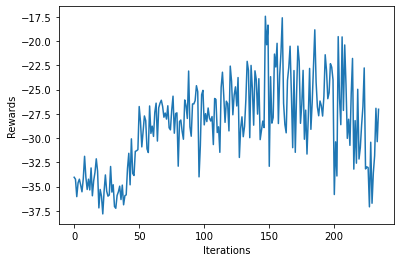

 24%|█████████████████▏                                                       | 23604/100000 [18:12<1:04:17, 19.80it/s]

Updated Weights
Mean Reward = -20.22
49


 24%|█████████████████▎                                                       | 23702/100000 [18:17<1:22:36, 15.40it/s]

Updated Weights
Mean Reward = -24.79
41


 24%|█████████████████▍                                                       | 23805/100000 [18:22<1:07:23, 18.84it/s]

Updated Weights
Mean Reward = -27.91
31


 24%|█████████████████▍                                                       | 23903/100000 [18:28<1:10:22, 18.02it/s]

Updated Weights
Mean Reward = -26.04
37


 24%|█████████████████▌                                                       | 23998/100000 [18:33<1:03:52, 19.83it/s]

Updated Weights
Mean Reward = -26.42
36


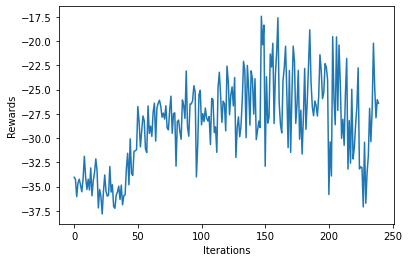

 24%|█████████████████▌                                                       | 24103/100000 [18:39<1:26:17, 14.66it/s]

Updated Weights
Mean Reward = -32.48
20


 24%|█████████████████▋                                                       | 24202/100000 [18:45<1:08:52, 18.34it/s]

Updated Weights
Mean Reward = -24.58
41


 24%|█████████████████▋                                                       | 24303/100000 [18:51<1:27:07, 14.48it/s]

Updated Weights
Mean Reward = -28.98
27


 24%|█████████████████▊                                                       | 24403/100000 [18:59<1:08:17, 18.45it/s]

Updated Weights
Mean Reward = -31.58
22


 24%|█████████████████▉                                                       | 24499/100000 [19:04<1:02:36, 20.10it/s]

Updated Weights
Mean Reward = -23.97
43


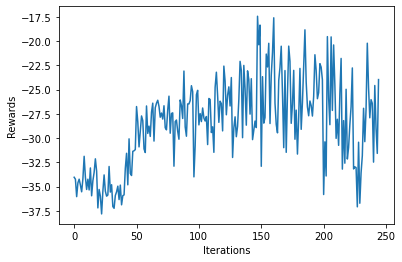

 25%|█████████████████▉                                                       | 24603/100000 [19:11<1:27:07, 14.42it/s]

Updated Weights
Mean Reward = -34.51
15


 25%|██████████████████                                                       | 24703/100000 [19:18<1:26:00, 14.59it/s]

Updated Weights
Mean Reward = -31.37
22


 25%|██████████████████                                                       | 24803/100000 [19:23<1:13:20, 17.09it/s]

Updated Weights
Mean Reward = -24.73
40


 25%|██████████████████▋                                                        | 24906/100000 [19:29<52:47, 23.70it/s]

Updated Weights
Mean Reward = -27.74
33


 25%|██████████████████▏                                                      | 24999/100000 [19:33<1:01:58, 20.17it/s]

Updated Weights
Mean Reward = -18.63
54


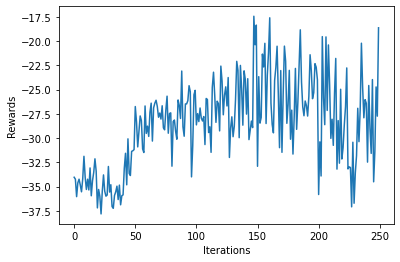

 25%|██████████████████▎                                                      | 25104/100000 [19:39<1:01:09, 20.41it/s]

Updated Weights
Mean Reward = -22.4
48


 25%|██████████████████▍                                                      | 25203/100000 [19:45<1:05:31, 19.03it/s]

Updated Weights
Mean Reward = -21.72
48


 25%|██████████████████▍                                                      | 25303/100000 [19:50<1:12:20, 17.21it/s]

Updated Weights
Mean Reward = -24.86
40


 25%|███████████████████                                                        | 25404/100000 [19:55<50:33, 24.59it/s]

Updated Weights
Mean Reward = -20.68
48


 26%|███████████████████▏                                                       | 25500/100000 [20:00<57:54, 21.44it/s]

Updated Weights
Mean Reward = -24.86
39


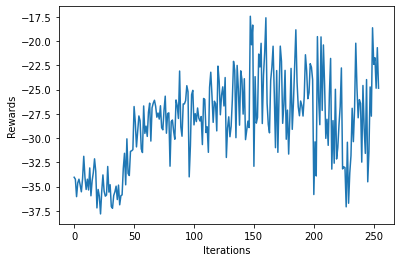

 26%|███████████████████▏                                                       | 25605/100000 [20:05<49:09, 25.22it/s]

Updated Weights
Mean Reward = -23.21
46


 26%|██████████████████▊                                                      | 25703/100000 [20:11<1:20:27, 15.39it/s]

Updated Weights
Mean Reward = -32.09
23


 26%|███████████████████▎                                                       | 25803/100000 [20:16<55:59, 22.08it/s]

Updated Weights
Mean Reward = -22.63
46


 26%|███████████████████▍                                                       | 25903/100000 [20:21<57:01, 21.66it/s]

Updated Weights
Mean Reward = -19.9
56


 26%|███████████████████▌                                                       | 26000/100000 [20:26<57:54, 21.30it/s]

Updated Weights
Mean Reward = -24.32
41


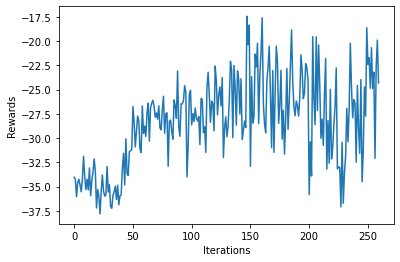

 26%|███████████████████▌                                                       | 26103/100000 [20:31<50:44, 24.27it/s]

Updated Weights
Mean Reward = -24.2
39


 26%|███████████████████▏                                                     | 26204/100000 [20:36<1:04:46, 18.99it/s]

Updated Weights
Mean Reward = -30.81
25


 26%|███████████████████▋                                                       | 26302/100000 [20:41<56:00, 21.93it/s]

Updated Weights
Mean Reward = -22.08
48


 26%|███████████████████▊                                                       | 26404/100000 [20:45<56:43, 21.62it/s]

Updated Weights
Mean Reward = -19.86
50


 26%|███████████████████▎                                                     | 26499/100000 [20:49<1:15:32, 16.22it/s]

Updated Weights
Mean Reward = -19.22
57


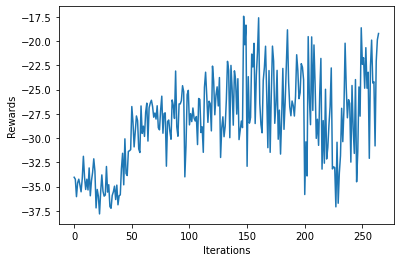

 27%|███████████████████▍                                                     | 26602/100000 [20:56<1:17:25, 15.80it/s]

Updated Weights
Mean Reward = -24.67
39


 27%|████████████████████                                                       | 26702/100000 [21:03<54:06, 22.58it/s]

Updated Weights
Mean Reward = -24.02
41


 27%|███████████████████▌                                                     | 26803/100000 [21:09<1:05:49, 18.53it/s]

Updated Weights
Mean Reward = -32.18
20


 27%|████████████████████▏                                                      | 26906/100000 [21:14<55:53, 21.80it/s]

Updated Weights
Mean Reward = -17.71
58


 27%|████████████████████▏                                                      | 26999/100000 [21:18<59:49, 20.34it/s]

Updated Weights
Mean Reward = -19.09
50


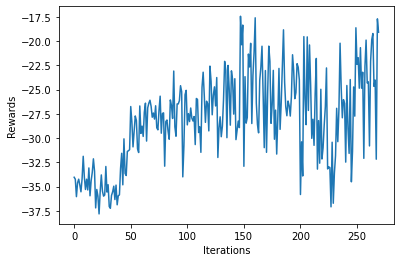

 27%|███████████████████▊                                                     | 27103/100000 [21:24<1:18:46, 15.42it/s]

Updated Weights
Mean Reward = -31.66
23


 27%|███████████████████▊                                                     | 27202/100000 [21:34<1:28:29, 13.71it/s]

Updated Weights
Mean Reward = -32.57
18


 27%|███████████████████▉                                                     | 27302/100000 [21:45<1:49:43, 11.04it/s]

Updated Weights
Mean Reward = -31.89
25


 27%|████████████████████                                                     | 27403/100000 [21:53<1:32:40, 13.06it/s]

Updated Weights
Mean Reward = -34.86
13


 27%|████████████████████▌                                                      | 27498/100000 [21:58<55:43, 21.69it/s]

Updated Weights
Mean Reward = -23.84
40


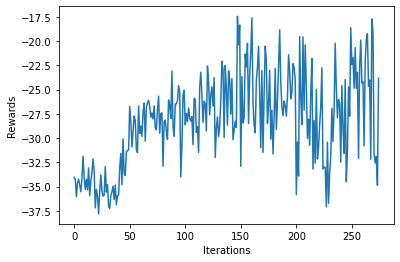

 28%|████████████████████▏                                                    | 27602/100000 [22:09<1:44:12, 11.58it/s]

Updated Weights
Mean Reward = -32.66
20


 28%|████████████████████▏                                                    | 27704/100000 [22:19<1:42:03, 11.81it/s]

Updated Weights
Mean Reward = -27.91
30


 28%|████████████████████▎                                                    | 27802/100000 [22:25<1:17:14, 15.58it/s]

Updated Weights
Mean Reward = -30.67
23


 28%|████████████████████▎                                                    | 27902/100000 [22:31<1:10:58, 16.93it/s]

Updated Weights
Mean Reward = -29.48
27


 28%|████████████████████▍                                                    | 28000/100000 [22:36<1:09:57, 17.15it/s]

Updated Weights
Mean Reward = -26.9
37


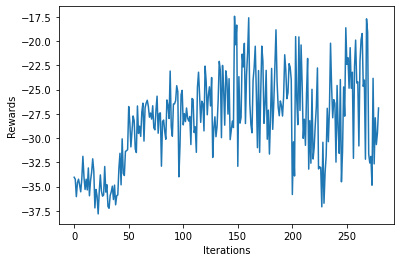

 28%|████████████████████▌                                                    | 28104/100000 [22:42<1:07:37, 17.72it/s]

Updated Weights
Mean Reward = -25.34
39


 28%|█████████████████████▏                                                     | 28205/100000 [22:48<58:12, 20.56it/s]

Updated Weights
Mean Reward = -28.26
33


 28%|█████████████████████▏                                                     | 28305/100000 [22:53<56:07, 21.29it/s]

Updated Weights
Mean Reward = -21.64
51


 28%|████████████████████▋                                                    | 28402/100000 [22:59<1:16:08, 15.67it/s]

Updated Weights
Mean Reward = -31.74
23


 28%|█████████████████████▎                                                     | 28500/100000 [23:04<56:06, 21.24it/s]

Updated Weights
Mean Reward = -27.32
35


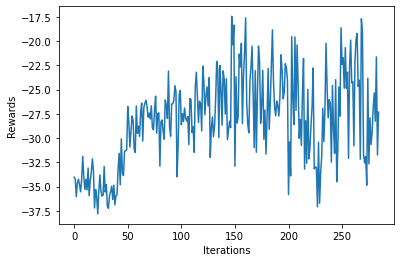

 29%|████████████████████▉                                                    | 28603/100000 [23:10<1:21:23, 14.62it/s]

Updated Weights
Mean Reward = -26.36
35


 29%|████████████████████▉                                                    | 28703/100000 [23:17<1:24:19, 14.09it/s]

Updated Weights
Mean Reward = -37.61
7


 29%|█████████████████████                                                    | 28805/100000 [23:24<1:21:44, 14.52it/s]

Updated Weights
Mean Reward = -31.49
20


 29%|█████████████████████                                                    | 28902/100000 [23:32<1:25:13, 13.90it/s]

Updated Weights
Mean Reward = -29.22
30


 29%|█████████████████████▏                                                   | 29000/100000 [23:38<1:08:49, 17.19it/s]

Updated Weights
Mean Reward = -30.28
27


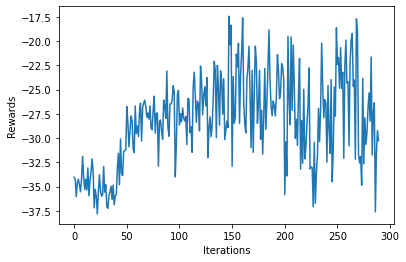

 29%|█████████████████████▏                                                   | 29101/100000 [23:50<5:37:31,  3.50it/s]

Updated Weights
Mean Reward = -32.14
21


 29%|█████████████████████▎                                                   | 29202/100000 [23:59<1:23:20, 14.16it/s]

Updated Weights
Mean Reward = -28.44
29


 29%|█████████████████████▍                                                   | 29302/100000 [24:05<1:08:56, 17.09it/s]

Updated Weights
Mean Reward = -34.02
18


 29%|█████████████████████▍                                                   | 29404/100000 [24:11<1:14:21, 15.82it/s]

Updated Weights
Mean Reward = -31.06
23


 30%|█████████████████████▌                                                   | 29500/100000 [24:19<1:15:24, 15.58it/s]

Updated Weights
Mean Reward = -29.39
25


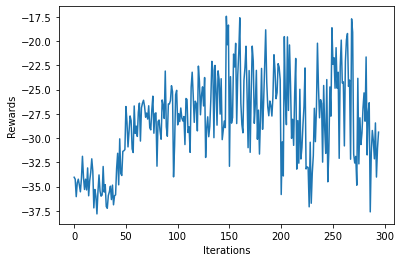

 30%|█████████████████████▌                                                   | 29602/100000 [24:25<1:12:46, 16.12it/s]

Updated Weights
Mean Reward = -27.06
35


 30%|█████████████████████▋                                                   | 29703/100000 [24:34<1:18:34, 14.91it/s]

Updated Weights
Mean Reward = -30.07
24


 30%|██████████████████████▎                                                    | 29802/100000 [24:39<58:47, 19.90it/s]

Updated Weights
Mean Reward = -24.02
40


 30%|██████████████████████▍                                                    | 29902/100000 [24:44<53:22, 21.89it/s]

Updated Weights
Mean Reward = -26.12
37


 30%|█████████████████████▉                                                   | 30000/100000 [24:50<1:08:46, 16.96it/s]

Updated Weights
Mean Reward = -33.98
20


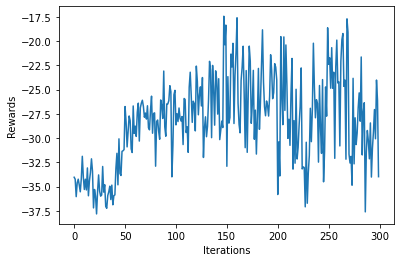

 30%|██████████████████████▌                                                    | 30104/100000 [24:55<50:03, 23.27it/s]

Updated Weights
Mean Reward = -26.7
34


 30%|██████████████████████                                                   | 30204/100000 [25:01<1:07:09, 17.32it/s]

Updated Weights
Mean Reward = -26.11
36


 30%|██████████████████████                                                   | 30303/100000 [25:06<1:10:44, 16.42it/s]

Updated Weights
Mean Reward = -26.4
35


 30%|██████████████████████▏                                                  | 30403/100000 [25:11<1:13:14, 15.84it/s]

Updated Weights
Mean Reward = -25.58
35


 30%|██████████████████████▎                                                  | 30499/100000 [25:17<1:12:13, 16.04it/s]

Updated Weights
Mean Reward = -32.3
22


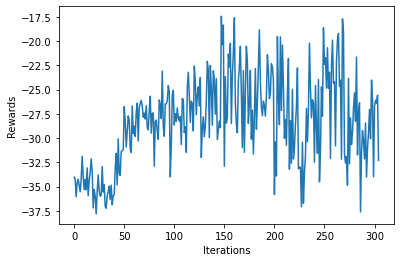

 31%|██████████████████████▎                                                  | 30602/100000 [25:25<1:10:24, 16.43it/s]

Updated Weights
Mean Reward = -26.35
37


 31%|███████████████████████                                                    | 30704/100000 [25:29<56:15, 20.53it/s]

Updated Weights
Mean Reward = -22.6
45


 31%|██████████████████████▍                                                  | 30804/100000 [25:34<1:08:34, 16.82it/s]

Updated Weights
Mean Reward = -22.37
45


 31%|███████████████████████▏                                                   | 30903/100000 [25:39<50:42, 22.71it/s]

Updated Weights
Mean Reward = -23.53
42


 31%|██████████████████████▋                                                  | 30999/100000 [25:44<1:01:35, 18.67it/s]

Updated Weights
Mean Reward = -22.52
45


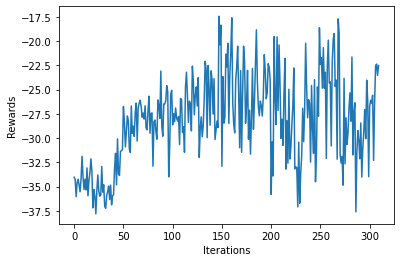

 31%|███████████████████████▎                                                   | 31104/100000 [25:50<55:50, 20.57it/s]

Updated Weights
Mean Reward = -25.2
39


 31%|███████████████████████▍                                                   | 31201/100000 [25:55<51:18, 22.35it/s]

Updated Weights
Mean Reward = -20.12
52


 31%|██████████████████████▊                                                  | 31304/100000 [26:01<1:24:02, 13.62it/s]

Updated Weights
Mean Reward = -22.91
42


 31%|███████████████████████▌                                                   | 31402/100000 [26:08<59:31, 19.21it/s]

Updated Weights
Mean Reward = -22.19
44


 31%|██████████████████████▉                                                  | 31499/100000 [26:17<2:18:55,  8.22it/s]

Updated Weights
Mean Reward = -25.75
34


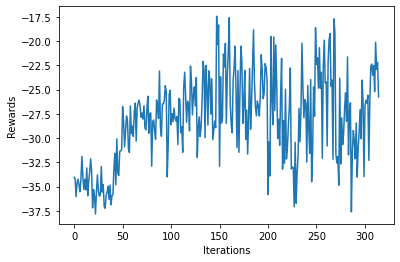

 32%|███████████████████████                                                  | 31602/100000 [26:28<1:30:02, 12.66it/s]

Updated Weights
Mean Reward = -23.1
42


 32%|███████████████████████▏                                                 | 31702/100000 [26:32<1:04:29, 17.65it/s]

Updated Weights
Mean Reward = -21.78
42


 32%|███████████████████████▊                                                   | 31803/100000 [26:38<58:48, 19.33it/s]

Updated Weights
Mean Reward = -26.29
35


 32%|███████████████████████▎                                                 | 31903/100000 [26:43<1:15:02, 15.13it/s]

Updated Weights
Mean Reward = -29.66
30


 32%|████████████████████████                                                   | 32000/100000 [26:48<48:31, 23.36it/s]

Updated Weights
Mean Reward = -23.39
43


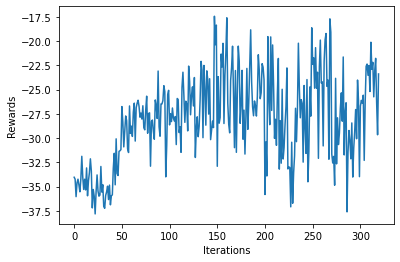

 32%|████████████████████████                                                   | 32103/100000 [26:53<54:12, 20.88it/s]

Updated Weights
Mean Reward = -16.21
57


 32%|███████████████████████▌                                                 | 32201/100000 [26:59<2:35:23,  7.27it/s]

Updated Weights
Mean Reward = -29.15
30


 32%|████████████████████████▏                                                  | 32308/100000 [27:09<38:40, 29.17it/s]

Updated Weights
Mean Reward = -23.31
44


 32%|███████████████████████▋                                                 | 32402/100000 [27:14<1:02:17, 18.08it/s]

Updated Weights
Mean Reward = -26.41
36


 32%|███████████████████████▋                                                 | 32499/100000 [27:20<1:11:07, 15.82it/s]

Updated Weights
Mean Reward = -29.36
29


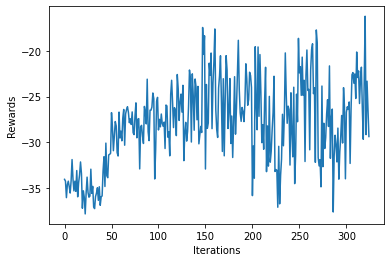

 33%|███████████████████████▊                                                 | 32602/100000 [27:25<1:04:45, 17.34it/s]

Updated Weights
Mean Reward = -28.69
29


 33%|███████████████████████▊                                                 | 32702/100000 [27:30<1:11:10, 15.76it/s]

Updated Weights
Mean Reward = -25.87
35


 33%|███████████████████████▉                                                 | 32802/100000 [27:37<1:12:53, 15.36it/s]

Updated Weights
Mean Reward = -38.02
5


 33%|████████████████████████                                                 | 32903/100000 [27:44<1:01:12, 18.27it/s]

Updated Weights
Mean Reward = -26.59
34


 33%|████████████████████████                                                 | 33000/100000 [27:53<2:13:26,  8.37it/s]

Updated Weights
Mean Reward = -27.65
30


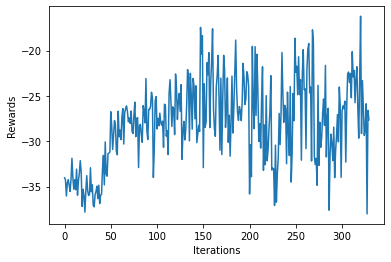

 33%|████████████████████████▏                                                | 33102/100000 [28:01<1:07:22, 16.55it/s]

Updated Weights
Mean Reward = -24.66
40


 33%|████████████████████████▏                                                | 33203/100000 [28:07<1:01:59, 17.96it/s]

Updated Weights
Mean Reward = -25.24
38


 33%|████████████████████████▎                                                | 33305/100000 [28:13<1:00:21, 18.42it/s]

Updated Weights
Mean Reward = -28.69
32


 33%|█████████████████████████                                                  | 33402/100000 [28:17<46:19, 23.96it/s]

Updated Weights
Mean Reward = -19.17
55


 33%|████████████████████████▍                                                | 33499/100000 [28:23<1:01:03, 18.15it/s]

Updated Weights
Mean Reward = -25.96
39


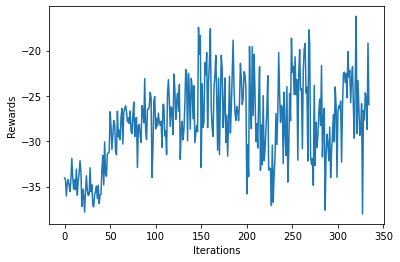

 34%|█████████████████████████▏                                                 | 33605/100000 [28:28<43:12, 25.61it/s]

Updated Weights
Mean Reward = -21.03
48


 34%|█████████████████████████▎                                                 | 33705/100000 [28:33<57:43, 19.14it/s]

Updated Weights
Mean Reward = -26.33
35


 34%|█████████████████████████▎                                                 | 33803/100000 [28:38<48:29, 22.75it/s]

Updated Weights
Mean Reward = -23.42
43


 34%|████████████████████████▋                                                | 33903/100000 [28:43<1:04:26, 17.10it/s]

Updated Weights
Mean Reward = -26.13
36


 34%|█████████████████████████▍                                                 | 33998/100000 [28:48<54:37, 20.14it/s]

Updated Weights
Mean Reward = -20.64
48


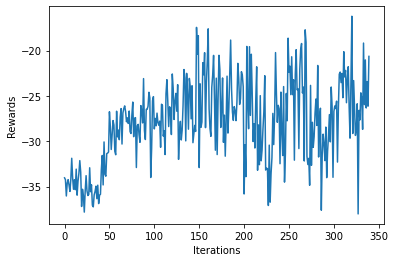

 34%|████████████████████████▉                                                | 34104/100000 [28:53<1:00:08, 18.26it/s]

Updated Weights
Mean Reward = -25.11
39


 34%|█████████████████████████▋                                                 | 34205/100000 [28:58<51:46, 21.18it/s]

Updated Weights
Mean Reward = -20.52
47


 34%|█████████████████████████▋                                                 | 34305/100000 [29:03<59:46, 18.32it/s]

Updated Weights
Mean Reward = -23.94
40


 34%|█████████████████████████▊                                                 | 34404/100000 [29:07<47:46, 22.88it/s]

Updated Weights
Mean Reward = -18.38
56


 34%|█████████████████████████▊                                                 | 34499/100000 [29:11<57:17, 19.06it/s]

Updated Weights
Mean Reward = -20.01
51


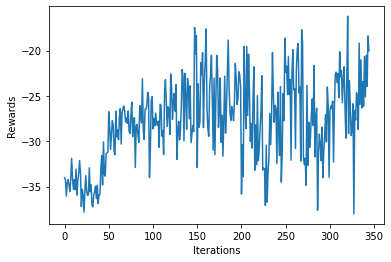

 35%|█████████████████████████▎                                               | 34602/100000 [29:17<1:03:58, 17.04it/s]

Updated Weights
Mean Reward = -28.04
31


 35%|█████████████████████████▎                                               | 34703/100000 [29:22<1:03:05, 17.25it/s]

Updated Weights
Mean Reward = -27.77
33


 35%|██████████████████████████                                                 | 34803/100000 [29:27<59:09, 18.37it/s]

Updated Weights
Mean Reward = -22.17
45


 35%|██████████████████████████▏                                                | 34904/100000 [29:32<57:59, 18.71it/s]

Updated Weights
Mean Reward = -27.37
34


 35%|█████████████████████████▌                                               | 34999/100000 [29:38<1:03:00, 17.20it/s]

Updated Weights
Mean Reward = -33.77
16


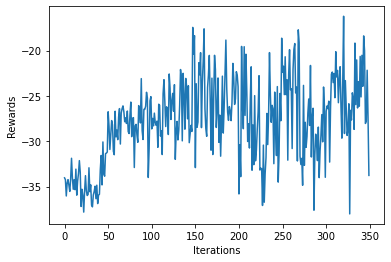

 35%|█████████████████████████▋                                               | 35104/100000 [29:44<1:03:34, 17.01it/s]

Updated Weights
Mean Reward = -33.09
20


 35%|█████████████████████████▋                                               | 35203/100000 [29:50<1:00:51, 17.74it/s]

Updated Weights
Mean Reward = -31.04
21


 35%|█████████████████████████▊                                               | 35303/100000 [29:55<1:04:27, 16.73it/s]

Updated Weights
Mean Reward = -29.4
28


 35%|█████████████████████████▊                                               | 35403/100000 [30:01<1:07:44, 15.89it/s]

Updated Weights
Mean Reward = -27.71
33


 35%|██████████████████████████▌                                                | 35499/100000 [30:06<55:44, 19.29it/s]

Updated Weights
Mean Reward = -29.46
28


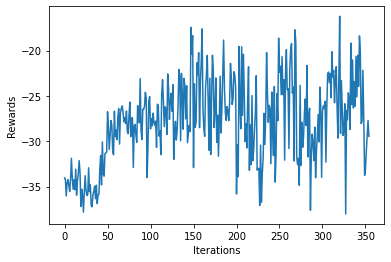

 36%|██████████████████████████▋                                                | 35604/100000 [30:12<50:52, 21.10it/s]

Updated Weights
Mean Reward = -27.28
33


 36%|██████████████████████████                                               | 35701/100000 [30:17<2:19:38,  7.67it/s]

Updated Weights
Mean Reward = -19.84
51


 36%|██████████████████████████▊                                                | 35801/100000 [30:24<51:30, 20.78it/s]

Updated Weights
Mean Reward = -21.57
48


 36%|██████████████████████████▏                                              | 35902/100000 [30:30<1:41:54, 10.48it/s]

Updated Weights
Mean Reward = -28.53
31


 36%|██████████████████████████▎                                              | 36000/100000 [30:40<3:55:08,  4.54it/s]

Updated Weights
Mean Reward = -25.25
37


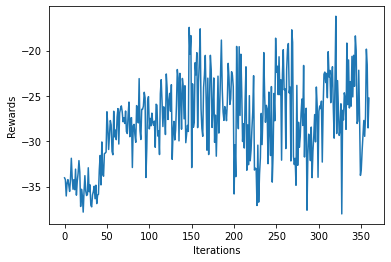

 36%|██████████████████████████▎                                              | 36102/100000 [30:47<1:04:05, 16.62it/s]

Updated Weights
Mean Reward = -27.05
33


 36%|██████████████████████████▍                                              | 36203/100000 [30:53<1:05:29, 16.24it/s]

Updated Weights
Mean Reward = -30.71
28


 36%|███████████████████████████▏                                               | 36304/100000 [30:58<54:42, 19.41it/s]

Updated Weights
Mean Reward = -25.27
40


 36%|███████████████████████████▎                                               | 36405/100000 [31:03<45:28, 23.31it/s]

Updated Weights
Mean Reward = -20.64
50


 36%|███████████████████████████▎                                               | 36498/100000 [31:08<51:45, 20.45it/s]

Updated Weights
Mean Reward = -29.47
29


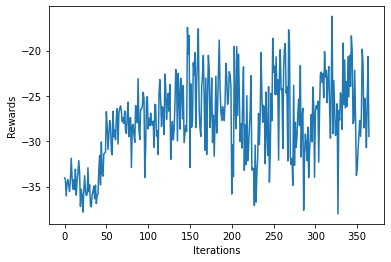

 37%|███████████████████████████▍                                               | 36604/100000 [31:14<49:25, 21.38it/s]

Updated Weights
Mean Reward = -26.54
33


 37%|███████████████████████████▌                                               | 36702/100000 [31:19<58:08, 18.14it/s]

Updated Weights
Mean Reward = -24.99
42


 37%|███████████████████████████▌                                               | 36806/100000 [31:24<42:14, 24.93it/s]

Updated Weights
Mean Reward = -23.78
42


 37%|███████████████████████████▋                                               | 36904/100000 [31:29<59:13, 17.75it/s]

Updated Weights
Mean Reward = -26.86
34


 37%|███████████████████████████▋                                               | 36999/100000 [31:34<56:54, 18.45it/s]

Updated Weights
Mean Reward = -28.16
36


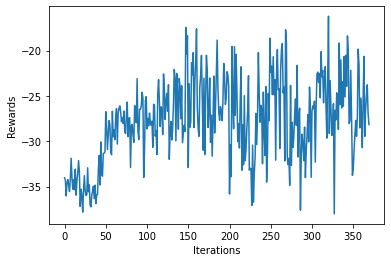

 37%|███████████████████████████                                              | 37103/100000 [31:39<1:01:04, 17.16it/s]

Updated Weights
Mean Reward = -28.46
32


 37%|███████████████████████████▉                                               | 37204/100000 [31:44<46:09, 22.67it/s]

Updated Weights
Mean Reward = -23.23
40


 37%|███████████████████████████▏                                             | 37303/100000 [31:49<1:03:46, 16.38it/s]

Updated Weights
Mean Reward = -32.38
18


 37%|████████████████████████████                                               | 37403/100000 [31:55<57:16, 18.22it/s]

Updated Weights
Mean Reward = -27.16
36


 37%|███████████████████████████▎                                             | 37499/100000 [32:00<1:03:28, 16.41it/s]

Updated Weights
Mean Reward = -27.77
30


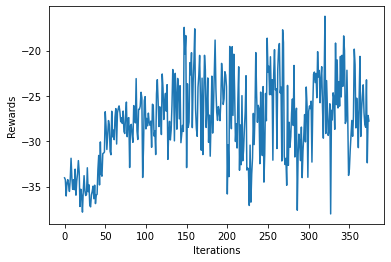

 38%|████████████████████████████▏                                              | 37603/100000 [32:05<58:06, 17.89it/s]

Updated Weights
Mean Reward = -29.86
25


 38%|████████████████████████████▎                                              | 37702/100000 [32:11<58:55, 17.62it/s]

Updated Weights
Mean Reward = -29.58
30


 38%|████████████████████████████▎                                              | 37803/100000 [32:16<56:42, 18.28it/s]

Updated Weights
Mean Reward = -27.89
30


 38%|████████████████████████████▍                                              | 37904/100000 [32:21<49:31, 20.90it/s]

Updated Weights
Mean Reward = -26.06
35


 38%|████████████████████████████▍                                              | 37999/100000 [32:25<46:11, 22.37it/s]

Updated Weights
Mean Reward = -20.55
47


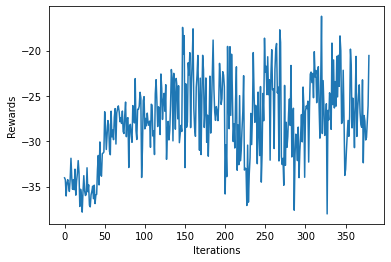

 38%|████████████████████████████▌                                              | 38105/100000 [32:31<46:18, 22.28it/s]

Updated Weights
Mean Reward = -26.19
35


 38%|████████████████████████████▋                                              | 38201/100000 [32:35<55:28, 18.56it/s]

Updated Weights
Mean Reward = -25.35
35


 38%|████████████████████████████▋                                              | 38303/100000 [32:41<55:39, 18.48it/s]

Updated Weights
Mean Reward = -31.19
25


 38%|████████████████████████████▊                                              | 38402/100000 [32:46<52:30, 19.55it/s]

Updated Weights
Mean Reward = -27.83
29


 38%|████████████████████████████▊                                              | 38499/100000 [32:51<46:44, 21.93it/s]

Updated Weights
Mean Reward = -27.05
32


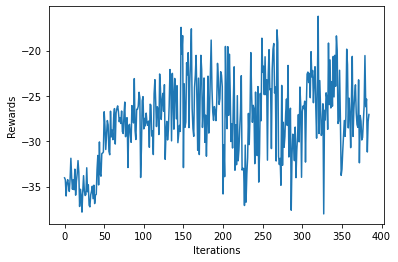

 39%|████████████████████████████▉                                              | 38604/100000 [32:56<48:52, 20.94it/s]

Updated Weights
Mean Reward = -23.3
40


 39%|█████████████████████████████                                              | 38704/100000 [33:01<56:46, 17.99it/s]

Updated Weights
Mean Reward = -29.65
26


 39%|█████████████████████████████                                              | 38804/100000 [33:07<52:37, 19.38it/s]

Updated Weights
Mean Reward = -30.76
25


 39%|█████████████████████████████▏                                             | 38905/100000 [33:12<49:47, 20.45it/s]

Updated Weights
Mean Reward = -25.44
36


 39%|█████████████████████████████▎                                             | 39000/100000 [33:17<34:30, 29.46it/s]

Updated Weights
Mean Reward = -26.06
34


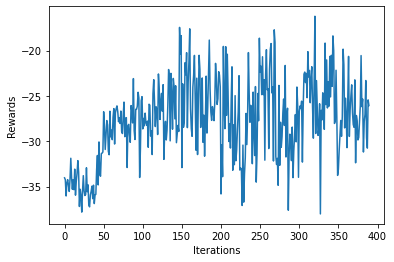

 39%|████████████████████████████▌                                            | 39103/100000 [33:23<1:06:10, 15.34it/s]

Updated Weights
Mean Reward = -33.33
16


 39%|█████████████████████████████▍                                             | 39201/100000 [33:27<48:39, 20.83it/s]

Updated Weights
Mean Reward = -25.06
36


 39%|████████████████████████████▋                                            | 39304/100000 [33:33<1:01:01, 16.58it/s]

Updated Weights
Mean Reward = -28.51
28


 39%|█████████████████████████████▌                                             | 39403/100000 [33:38<50:28, 20.01it/s]

Updated Weights
Mean Reward = -31.11
23


 39%|█████████████████████████████▌                                             | 39498/100000 [33:43<46:35, 21.64it/s]

Updated Weights
Mean Reward = -30.48
21


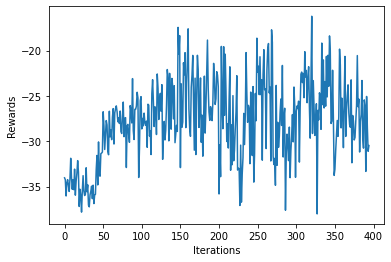

 40%|█████████████████████████████▋                                             | 39604/100000 [33:48<49:19, 20.41it/s]

Updated Weights
Mean Reward = -20.77
48


 40%|████████████████████████████▉                                            | 39702/100000 [33:54<1:00:38, 16.57it/s]

Updated Weights
Mean Reward = -31.89
24


 40%|█████████████████████████████                                            | 39804/100000 [34:00<1:00:00, 16.72it/s]

Updated Weights
Mean Reward = -33.82
17


 40%|█████████████████████████████▉                                             | 39903/100000 [34:05<51:06, 19.60it/s]

Updated Weights
Mean Reward = -32.74
17


 40%|██████████████████████████████                                             | 40000/100000 [34:10<55:43, 17.94it/s]

Updated Weights
Mean Reward = -25.83
37


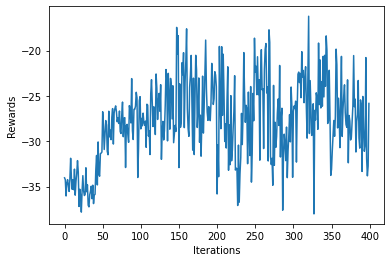

 40%|█████████████████████████████▎                                           | 40103/100000 [34:16<1:01:21, 16.27it/s]

Updated Weights
Mean Reward = -32.65
20


 40%|██████████████████████████████▏                                            | 40204/100000 [34:21<53:15, 18.71it/s]

Updated Weights
Mean Reward = -28.7
31


 40%|██████████████████████████████▏                                            | 40304/100000 [34:27<56:44, 17.53it/s]

Updated Weights
Mean Reward = -33.44
18


 40%|██████████████████████████████▎                                            | 40404/100000 [34:32<47:05, 21.09it/s]

Updated Weights
Mean Reward = -26.72
32


 40%|██████████████████████████████▎                                            | 40499/100000 [34:37<51:40, 19.19it/s]

Updated Weights
Mean Reward = -26.73
32


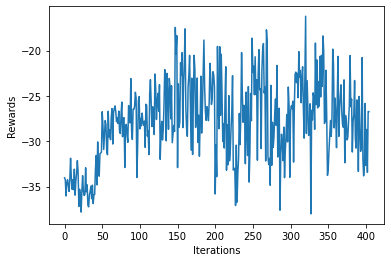

 41%|██████████████████████████████▍                                            | 40603/100000 [34:42<52:57, 18.69it/s]

Updated Weights
Mean Reward = -28.71
25


 41%|██████████████████████████████▌                                            | 40704/100000 [34:48<53:20, 18.53it/s]

Updated Weights
Mean Reward = -31.96
23


 41%|██████████████████████████████▌                                            | 40802/100000 [34:53<53:55, 18.29it/s]

Updated Weights
Mean Reward = -27.48
30


 41%|██████████████████████████████▋                                            | 40902/100000 [34:58<47:40, 20.66it/s]

Updated Weights
Mean Reward = -32.78
18


 41%|█████████████████████████████▉                                           | 41000/100000 [35:04<1:01:37, 15.96it/s]

Updated Weights
Mean Reward = -34.53
12


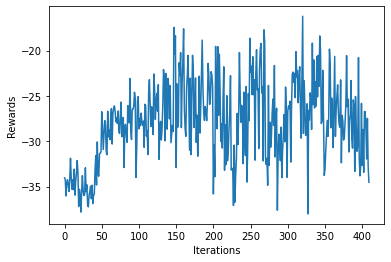

 41%|██████████████████████████████▊                                            | 41104/100000 [35:10<48:13, 20.35it/s]

Updated Weights
Mean Reward = -30.58
22


 41%|██████████████████████████████▉                                            | 41204/100000 [35:16<56:02, 17.49it/s]

Updated Weights
Mean Reward = -31.34
25


 41%|██████████████████████████████▉                                            | 41301/100000 [35:20<49:06, 19.92it/s]

Updated Weights
Mean Reward = -24.12
39


 41%|███████████████████████████████                                            | 41404/100000 [35:25<39:44, 24.58it/s]

Updated Weights
Mean Reward = -24.28
38


 42%|██████████████████████████████▎                                          | 41500/100000 [35:30<1:00:43, 16.06it/s]

Updated Weights
Mean Reward = -32.71
20


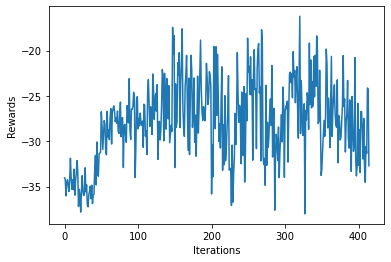

 42%|███████████████████████████████▏                                           | 41603/100000 [35:36<41:47, 23.29it/s]

Updated Weights
Mean Reward = -24.43
39


 42%|███████████████████████████████▎                                           | 41702/100000 [35:40<54:10, 17.94it/s]

Updated Weights
Mean Reward = -25.75
38


 42%|███████████████████████████████▎                                           | 41802/100000 [35:46<47:46, 20.30it/s]

Updated Weights
Mean Reward = -29.63
27


 42%|███████████████████████████████▍                                           | 41902/100000 [35:50<53:23, 18.14it/s]

Updated Weights
Mean Reward = -22.9
41


 42%|███████████████████████████████▍                                           | 41997/100000 [35:55<42:59, 22.48it/s]

Updated Weights
Mean Reward = -28.26
30


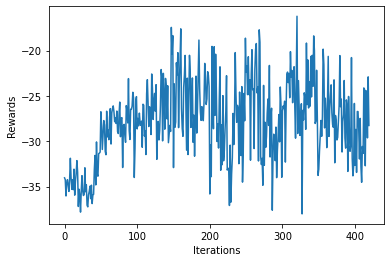

 42%|███████████████████████████████▌                                           | 42103/100000 [36:00<42:19, 22.80it/s]

Updated Weights
Mean Reward = -24.21
39


 42%|███████████████████████████████▋                                           | 42205/100000 [36:06<49:36, 19.42it/s]

Updated Weights
Mean Reward = -29.05
26


 42%|███████████████████████████████▋                                           | 42305/100000 [36:11<42:34, 22.59it/s]

Updated Weights
Mean Reward = -26.52
33


 42%|███████████████████████████████▊                                           | 42402/100000 [36:15<48:25, 19.83it/s]

Updated Weights
Mean Reward = -24.89
41


 42%|███████████████████████████████▊                                           | 42499/100000 [36:20<52:09, 18.37it/s]

Updated Weights
Mean Reward = -27.56
33


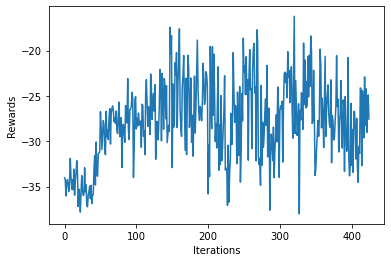

 43%|███████████████████████████████▉                                           | 42605/100000 [36:26<53:52, 17.76it/s]

Updated Weights
Mean Reward = -30.87
26


 43%|████████████████████████████████                                           | 42705/100000 [36:31<39:25, 24.22it/s]

Updated Weights
Mean Reward = -25.84
34


 43%|████████████████████████████████                                           | 42804/100000 [36:36<57:35, 16.55it/s]

Updated Weights
Mean Reward = -29.25
26


 43%|████████████████████████████████▏                                          | 42903/100000 [36:41<49:56, 19.06it/s]

Updated Weights
Mean Reward = -26.44
33


 43%|████████████████████████████████▏                                          | 42999/100000 [36:46<48:23, 19.63it/s]

Updated Weights
Mean Reward = -28.5
28


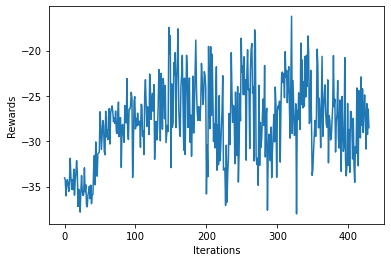

 43%|████████████████████████████████▎                                          | 43104/100000 [36:52<42:28, 22.33it/s]

Updated Weights
Mean Reward = -27.11
30


 43%|████████████████████████████████▍                                          | 43206/100000 [36:57<42:10, 22.44it/s]

Updated Weights
Mean Reward = -28.17
28


 43%|████████████████████████████████▍                                          | 43303/100000 [37:02<53:33, 17.64it/s]

Updated Weights
Mean Reward = -25.97
35


 43%|████████████████████████████████▌                                          | 43404/100000 [37:07<53:25, 17.66it/s]

Updated Weights
Mean Reward = -28.64
29


 44%|████████████████████████████████▋                                          | 43500/100000 [37:12<55:47, 16.88it/s]

Updated Weights
Mean Reward = -27.05
35


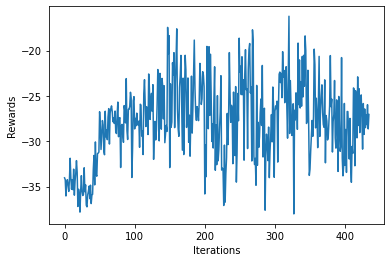

 44%|████████████████████████████████▋                                          | 43602/100000 [37:18<51:10, 18.37it/s]

Updated Weights
Mean Reward = -29.15
27


 44%|████████████████████████████████▊                                          | 43704/100000 [37:23<50:28, 18.59it/s]

Updated Weights
Mean Reward = -28.97
31


 44%|████████████████████████████████▊                                          | 43805/100000 [37:28<43:54, 21.33it/s]

Updated Weights
Mean Reward = -26.58
35


 44%|████████████████████████████████▉                                          | 43903/100000 [37:34<57:45, 16.19it/s]

Updated Weights
Mean Reward = -33.62
15


 44%|█████████████████████████████████                                          | 44000/100000 [37:38<44:43, 20.87it/s]

Updated Weights
Mean Reward = -26.93
33


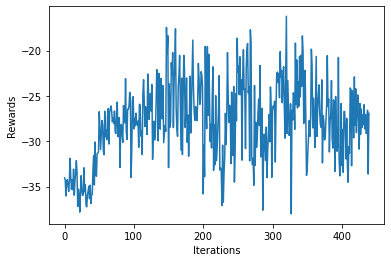

 44%|█████████████████████████████████                                          | 44104/100000 [37:44<48:54, 19.05it/s]

Updated Weights
Mean Reward = -25.67
39


 44%|█████████████████████████████████▏                                         | 44205/100000 [37:49<43:32, 21.36it/s]

Updated Weights
Mean Reward = -23.92
41


 44%|█████████████████████████████████▏                                         | 44303/100000 [37:54<55:55, 16.60it/s]

Updated Weights
Mean Reward = -34.44
15


 44%|█████████████████████████████████▎                                         | 44404/100000 [38:00<55:37, 16.66it/s]

Updated Weights
Mean Reward = -35.69
10


 44%|█████████████████████████████████▎                                         | 44499/100000 [38:05<50:13, 18.42it/s]

Updated Weights
Mean Reward = -31.1
21


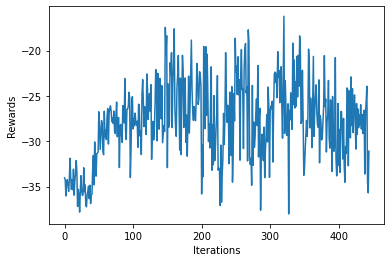

 45%|█████████████████████████████████▍                                         | 44603/100000 [38:10<49:35, 18.62it/s]

Updated Weights
Mean Reward = -20.59
48


 45%|█████████████████████████████████▌                                         | 44703/100000 [38:15<45:34, 20.22it/s]

Updated Weights
Mean Reward = -19.03
51


 45%|█████████████████████████████████▌                                         | 44802/100000 [38:20<55:11, 16.67it/s]

Updated Weights
Mean Reward = -33.31
19


 45%|█████████████████████████████████▋                                         | 44906/100000 [38:26<40:35, 22.62it/s]

Updated Weights
Mean Reward = -26.04
37


 45%|█████████████████████████████████▋                                         | 44998/100000 [38:30<40:07, 22.85it/s]

Updated Weights
Mean Reward = -22.64
46


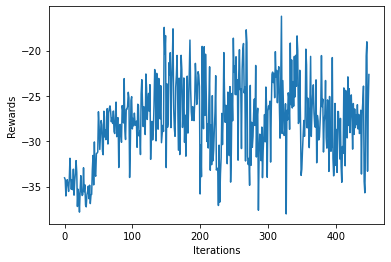

 45%|█████████████████████████████████▊                                         | 45103/100000 [38:36<57:04, 16.03it/s]

Updated Weights
Mean Reward = -34.18
15


 45%|█████████████████████████████████▉                                         | 45202/100000 [38:41<55:02, 16.59it/s]

Updated Weights
Mean Reward = -26.56
35


 45%|█████████████████████████████████▉                                         | 45305/100000 [38:46<42:09, 21.63it/s]

Updated Weights
Mean Reward = -24.61
36


 45%|██████████████████████████████████                                         | 45402/100000 [38:51<46:32, 19.55it/s]

Updated Weights
Mean Reward = -27.48
33


 45%|██████████████████████████████████                                         | 45499/100000 [38:56<48:35, 18.69it/s]

Updated Weights
Mean Reward = -28.43
30


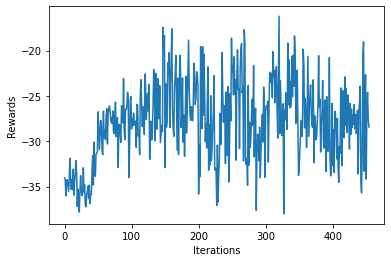

 46%|██████████████████████████████████▏                                        | 45602/100000 [39:02<58:38, 15.46it/s]

Updated Weights
Mean Reward = -35.78
11


 46%|██████████████████████████████████▎                                        | 45704/100000 [39:08<43:06, 20.99it/s]

Updated Weights
Mean Reward = -30.58
26


 46%|██████████████████████████████████▎                                        | 45802/100000 [39:13<57:26, 15.73it/s]

Updated Weights
Mean Reward = -28.99
28


 46%|██████████████████████████████████▍                                        | 45902/100000 [39:20<45:39, 19.75it/s]

Updated Weights
Mean Reward = -26.19
37


 46%|██████████████████████████████████▌                                        | 46000/100000 [39:25<46:53, 19.19it/s]

Updated Weights
Mean Reward = -30.58
24


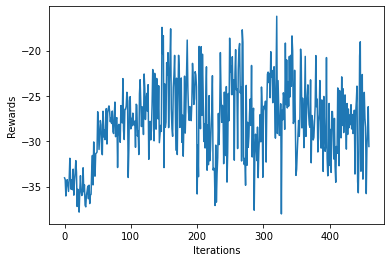

 46%|██████████████████████████████████▌                                        | 46102/100000 [39:31<55:45, 16.11it/s]

Updated Weights
Mean Reward = -29.51
25


 46%|██████████████████████████████████▋                                        | 46205/100000 [39:36<33:24, 26.84it/s]

Updated Weights
Mean Reward = -29.06
26


 46%|██████████████████████████████████▋                                        | 46303/100000 [39:42<56:37, 15.80it/s]

Updated Weights
Mean Reward = -31.96
20


 46%|██████████████████████████████████▊                                        | 46404/100000 [39:47<51:23, 17.38it/s]

Updated Weights
Mean Reward = -32.15
19


 46%|██████████████████████████████████▉                                        | 46500/100000 [39:52<36:02, 24.74it/s]

Updated Weights
Mean Reward = -31.16
21


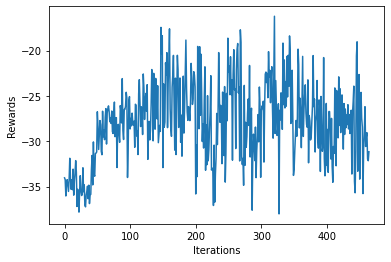

 47%|██████████████████████████████████▉                                        | 46607/100000 [39:58<37:37, 23.65it/s]

Updated Weights
Mean Reward = -26.97
33


 47%|███████████████████████████████████                                        | 46704/100000 [40:03<55:34, 15.98it/s]

Updated Weights
Mean Reward = -31.64
19


 47%|███████████████████████████████████                                        | 46803/100000 [40:10<42:55, 20.65it/s]

Updated Weights
Mean Reward = -25.86
35


 47%|███████████████████████████████████▏                                       | 46906/100000 [40:16<42:43, 20.71it/s]

Updated Weights
Mean Reward = -27.42
31


 47%|███████████████████████████████████▏                                       | 46999/100000 [40:22<43:50, 20.15it/s]

Updated Weights
Mean Reward = -29.85
27


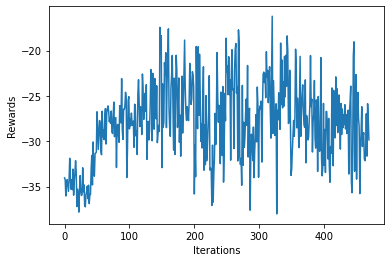

 47%|███████████████████████████████████▎                                       | 47103/100000 [40:28<50:08, 17.58it/s]

Updated Weights
Mean Reward = -29.3
26


 47%|███████████████████████████████████▍                                       | 47202/100000 [40:33<45:01, 19.54it/s]

Updated Weights
Mean Reward = -26.45
35


 47%|███████████████████████████████████▍                                       | 47304/100000 [40:38<43:13, 20.32it/s]

Updated Weights
Mean Reward = -28.86
28


 47%|███████████████████████████████████▌                                       | 47404/100000 [40:43<39:59, 21.92it/s]

Updated Weights
Mean Reward = -25.74
36


 47%|███████████████████████████████████▌                                       | 47499/100000 [40:48<50:52, 17.20it/s]

Updated Weights
Mean Reward = -27.04
34


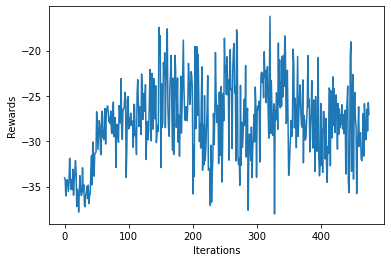

 48%|███████████████████████████████████▋                                       | 47604/100000 [40:53<49:18, 17.71it/s]

Updated Weights
Mean Reward = -27.94
28


 48%|███████████████████████████████████▊                                       | 47705/100000 [40:59<37:12, 23.43it/s]

Updated Weights
Mean Reward = -28.01
32


 48%|███████████████████████████████████▊                                       | 47804/100000 [41:04<53:07, 16.38it/s]

Updated Weights
Mean Reward = -28.52
29


 48%|███████████████████████████████████▉                                       | 47903/100000 [41:09<51:05, 17.00it/s]

Updated Weights
Mean Reward = -28.23
28


 48%|████████████████████████████████████                                       | 48000/100000 [41:15<55:40, 15.56it/s]

Updated Weights
Mean Reward = -30.66
24


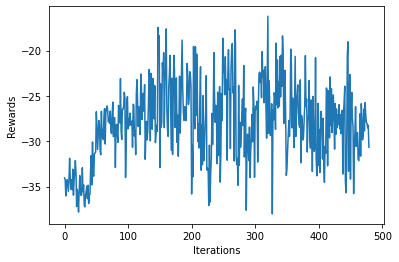

 48%|███████████████████████████████████                                      | 48104/100000 [41:26<1:37:18,  8.89it/s]

Updated Weights
Mean Reward = -32.39
20


 48%|████████████████████████████████████▏                                      | 48204/100000 [41:32<54:44, 15.77it/s]

Updated Weights
Mean Reward = -31.0
25


 48%|████████████████████████████████████▏                                      | 48302/100000 [41:38<55:25, 15.54it/s]

Updated Weights
Mean Reward = -32.51
23


 48%|████████████████████████████████████▎                                      | 48404/100000 [41:43<51:50, 16.59it/s]

Updated Weights
Mean Reward = -30.94
23


 48%|████████████████████████████████████▎                                      | 48498/100000 [41:49<46:25, 18.49it/s]

Updated Weights
Mean Reward = -28.25
30


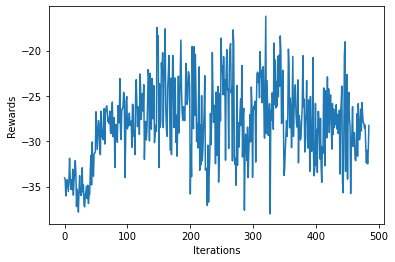

 49%|████████████████████████████████████▍                                      | 48603/100000 [41:54<57:33, 14.88it/s]

Updated Weights
Mean Reward = -27.11
34


 49%|████████████████████████████████████▌                                      | 48705/100000 [41:59<40:22, 21.17it/s]

Updated Weights
Mean Reward = -25.79
36


 49%|████████████████████████████████████▌                                      | 48803/100000 [42:04<46:19, 18.42it/s]

Updated Weights
Mean Reward = -28.41
33


 49%|████████████████████████████████████▋                                      | 48903/100000 [42:09<45:11, 18.84it/s]

Updated Weights
Mean Reward = -24.84
41


 49%|████████████████████████████████████▋                                      | 48998/100000 [42:14<39:06, 21.74it/s]

Updated Weights
Mean Reward = -23.64
41


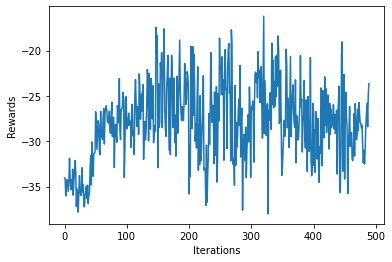

 49%|████████████████████████████████████▊                                      | 49102/100000 [42:20<52:22, 16.20it/s]

Updated Weights
Mean Reward = -28.4
32


 49%|████████████████████████████████████▉                                      | 49202/100000 [42:25<40:10, 21.08it/s]

Updated Weights
Mean Reward = -27.2
31


 49%|████████████████████████████████████▉                                      | 49303/100000 [42:30<44:38, 18.93it/s]

Updated Weights
Mean Reward = -25.94
33


 49%|█████████████████████████████████████                                      | 49403/100000 [42:35<47:29, 17.76it/s]

Updated Weights
Mean Reward = -28.32
28


 50%|█████████████████████████████████████▏                                     | 49500/100000 [42:40<40:30, 20.78it/s]

Updated Weights
Mean Reward = -30.92
25


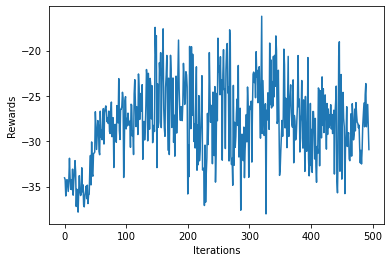

 50%|█████████████████████████████████████▏                                     | 49605/100000 [42:46<43:09, 19.46it/s]

Updated Weights
Mean Reward = -27.29
32


 50%|█████████████████████████████████████▎                                     | 49703/100000 [42:51<45:01, 18.62it/s]

Updated Weights
Mean Reward = -30.53
27


 50%|█████████████████████████████████████▎                                     | 49803/100000 [42:56<35:39, 23.46it/s]

Updated Weights
Mean Reward = -29.01
32


 50%|█████████████████████████████████████▍                                     | 49903/100000 [43:02<52:05, 16.03it/s]

Updated Weights
Mean Reward = -33.11
18


 50%|█████████████████████████████████████▍                                     | 49999/100000 [43:06<41:18, 20.17it/s]

Updated Weights
Mean Reward = -25.33
35


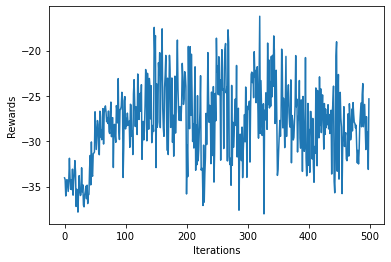

 50%|█████████████████████████████████████▌                                     | 50102/100000 [43:12<43:13, 19.24it/s]

Updated Weights
Mean Reward = -27.95
31


 50%|█████████████████████████████████████▋                                     | 50202/100000 [43:18<46:21, 17.90it/s]

Updated Weights
Mean Reward = -32.07
21


 50%|█████████████████████████████████████▋                                     | 50304/100000 [43:23<48:47, 16.98it/s]

Updated Weights
Mean Reward = -28.36
31


 50%|█████████████████████████████████████▊                                     | 50404/100000 [43:28<44:27, 18.59it/s]

Updated Weights
Mean Reward = -33.85
17


 50%|█████████████████████████████████████▉                                     | 50500/100000 [43:34<45:09, 18.27it/s]

Updated Weights
Mean Reward = -29.56
28


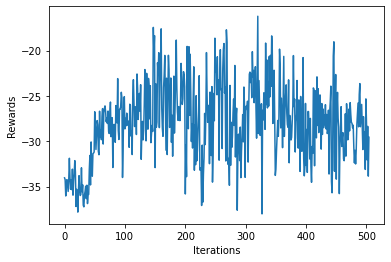

 51%|█████████████████████████████████████▉                                     | 50602/100000 [43:39<47:57, 17.17it/s]

Updated Weights
Mean Reward = -32.48
20


 51%|██████████████████████████████████████                                     | 50704/100000 [43:45<46:56, 17.51it/s]

Updated Weights
Mean Reward = -27.33
35


 51%|██████████████████████████████████████                                     | 50802/100000 [43:49<42:45, 19.18it/s]

Updated Weights
Mean Reward = -24.28
43


 51%|██████████████████████████████████████▏                                    | 50904/100000 [43:55<36:59, 22.12it/s]

Updated Weights
Mean Reward = -27.8
32


 51%|██████████████████████████████████████▏                                    | 50998/100000 [44:00<46:59, 17.38it/s]

Updated Weights
Mean Reward = -27.86
31


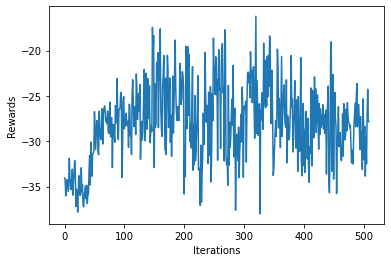

 51%|██████████████████████████████████████▎                                    | 51102/100000 [44:05<40:55, 19.91it/s]

Updated Weights
Mean Reward = -31.24
24


 51%|██████████████████████████████████████▍                                    | 51202/100000 [44:11<45:10, 18.00it/s]

Updated Weights
Mean Reward = -28.93
26


 51%|██████████████████████████████████████▍                                    | 51303/100000 [44:16<50:17, 16.14it/s]

Updated Weights
Mean Reward = -31.72
21


 51%|██████████████████████████████████████▌                                    | 51402/100000 [44:21<47:25, 17.08it/s]

Updated Weights
Mean Reward = -26.65
34


 52%|██████████████████████████████████████▋                                    | 51500/100000 [44:27<47:52, 16.88it/s]

Updated Weights
Mean Reward = -33.05
21


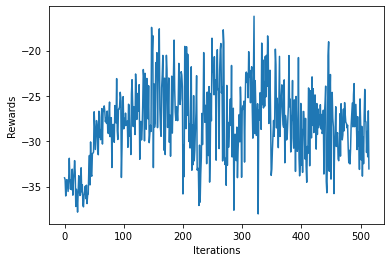

 52%|██████████████████████████████████████▋                                    | 51603/100000 [44:33<48:04, 16.78it/s]

Updated Weights
Mean Reward = -31.28
22


 52%|██████████████████████████████████████▊                                    | 51704/100000 [44:38<39:52, 20.19it/s]

Updated Weights
Mean Reward = -30.56
22


 52%|██████████████████████████████████████▊                                    | 51803/100000 [44:44<46:34, 17.25it/s]

Updated Weights
Mean Reward = -33.45
18


 52%|██████████████████████████████████████▉                                    | 51904/100000 [44:50<46:22, 17.28it/s]

Updated Weights
Mean Reward = -35.62
11


 52%|██████████████████████████████████████▉                                    | 51999/100000 [44:55<38:36, 20.72it/s]

Updated Weights
Mean Reward = -28.22
28


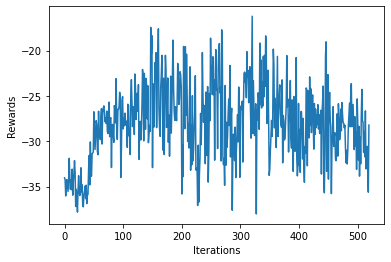

 52%|███████████████████████████████████████                                    | 52103/100000 [45:01<51:29, 15.50it/s]

Updated Weights
Mean Reward = -33.28
19


 52%|███████████████████████████████████████▏                                   | 52204/100000 [45:06<48:10, 16.53it/s]

Updated Weights
Mean Reward = -32.1
21


 52%|███████████████████████████████████████▏                                   | 52303/100000 [45:12<43:52, 18.12it/s]

Updated Weights
Mean Reward = -30.47
24


 52%|███████████████████████████████████████▎                                   | 52404/100000 [45:17<39:43, 19.97it/s]

Updated Weights
Mean Reward = -28.86
29


 52%|███████████████████████████████████████▎                                   | 52499/100000 [45:22<42:59, 18.41it/s]

Updated Weights
Mean Reward = -33.88
15


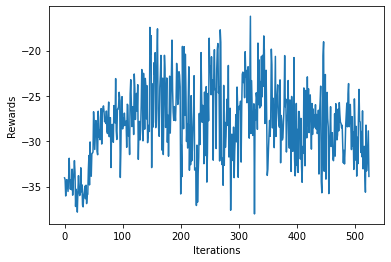

 53%|███████████████████████████████████████▍                                   | 52603/100000 [45:28<47:42, 16.56it/s]

Updated Weights
Mean Reward = -29.7
26


 53%|███████████████████████████████████████▌                                   | 52704/100000 [45:33<44:44, 17.62it/s]

Updated Weights
Mean Reward = -27.98
30


 53%|███████████████████████████████████████▌                                   | 52802/100000 [45:39<44:37, 17.63it/s]

Updated Weights
Mean Reward = -35.39
11


 53%|███████████████████████████████████████▋                                   | 52903/100000 [45:45<46:53, 16.74it/s]

Updated Weights
Mean Reward = -33.94
17


 53%|███████████████████████████████████████▊                                   | 53000/100000 [45:50<41:11, 19.01it/s]

Updated Weights
Mean Reward = -33.73
16


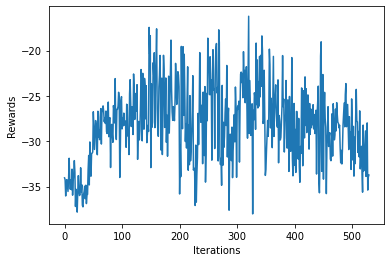

 53%|███████████████████████████████████████▊                                   | 53104/100000 [45:55<41:32, 18.81it/s]

Updated Weights
Mean Reward = -25.86
36


 53%|███████████████████████████████████████▉                                   | 53202/100000 [46:01<41:34, 18.76it/s]

Updated Weights
Mean Reward = -34.51
13


 53%|███████████████████████████████████████▉                                   | 53305/100000 [46:07<36:21, 21.40it/s]

Updated Weights
Mean Reward = -31.27
22


 53%|████████████████████████████████████████                                   | 53404/100000 [46:12<46:18, 16.77it/s]

Updated Weights
Mean Reward = -31.58
20


 54%|████████████████████████████████████████▏                                  | 53500/100000 [46:18<45:09, 17.16it/s]

Updated Weights
Mean Reward = -32.88
18


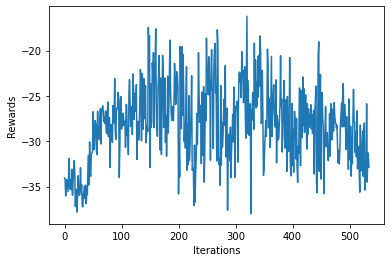

 54%|████████████████████████████████████████▏                                  | 53603/100000 [46:23<42:33, 18.17it/s]

Updated Weights
Mean Reward = -28.2
28


 54%|████████████████████████████████████████▎                                  | 53702/100000 [46:28<37:14, 20.72it/s]

Updated Weights
Mean Reward = -29.45
25


 54%|████████████████████████████████████████▎                                  | 53804/100000 [46:34<38:21, 20.07it/s]

Updated Weights
Mean Reward = -30.97
24


 54%|████████████████████████████████████████▍                                  | 53903/100000 [46:39<49:08, 15.63it/s]

Updated Weights
Mean Reward = -28.66
28


 54%|████████████████████████████████████████▌                                  | 54000/100000 [46:44<39:13, 19.55it/s]

Updated Weights
Mean Reward = -31.54
23


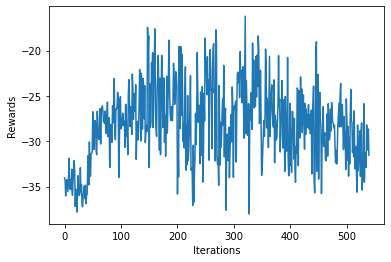

 54%|████████████████████████████████████████▌                                  | 54103/100000 [46:50<45:26, 16.83it/s]

Updated Weights
Mean Reward = -28.29
30


 54%|████████████████████████████████████████▋                                  | 54203/100000 [46:55<41:33, 18.37it/s]

Updated Weights
Mean Reward = -31.02
22


 54%|████████████████████████████████████████▋                                  | 54303/100000 [47:00<39:53, 19.09it/s]

Updated Weights
Mean Reward = -27.84
32


 54%|████████████████████████████████████████▊                                  | 54402/100000 [47:06<43:14, 17.58it/s]

Updated Weights
Mean Reward = -29.7
26


 54%|████████████████████████████████████████▊                                  | 54499/100000 [47:11<41:03, 18.47it/s]

Updated Weights
Mean Reward = -28.96
28


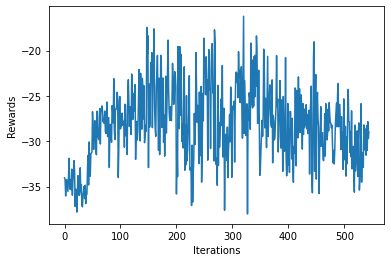

 55%|████████████████████████████████████████▉                                  | 54602/100000 [47:16<37:21, 20.25it/s]

Updated Weights
Mean Reward = -28.69
28


 55%|█████████████████████████████████████████                                  | 54702/100000 [47:22<41:00, 18.41it/s]

Updated Weights
Mean Reward = -31.52
21


 55%|█████████████████████████████████████████                                  | 54803/100000 [47:27<46:17, 16.27it/s]

Updated Weights
Mean Reward = -28.43
27


 55%|█████████████████████████████████████████▏                                 | 54903/100000 [47:33<43:34, 17.25it/s]

Updated Weights
Mean Reward = -32.06
22


 55%|█████████████████████████████████████████▎                                 | 55000/100000 [47:38<43:30, 17.24it/s]

Updated Weights
Mean Reward = -29.91
25


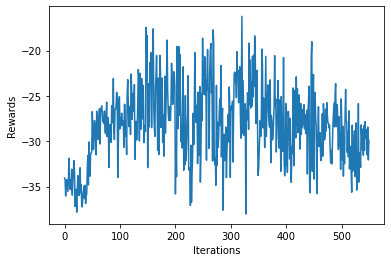

 55%|█████████████████████████████████████████▎                                 | 55103/100000 [47:44<47:07, 15.88it/s]

Updated Weights
Mean Reward = -33.37
17


 55%|█████████████████████████████████████████▍                                 | 55203/100000 [47:49<39:36, 18.85it/s]

Updated Weights
Mean Reward = -30.9
25


 55%|█████████████████████████████████████████▍                                 | 55304/100000 [47:55<39:41, 18.77it/s]

Updated Weights
Mean Reward = -33.35
16


 55%|█████████████████████████████████████████▌                                 | 55402/100000 [48:00<43:48, 16.97it/s]

Updated Weights
Mean Reward = -30.32
26


 55%|█████████████████████████████████████████▌                                 | 55499/100000 [48:06<39:52, 18.60it/s]

Updated Weights
Mean Reward = -32.74
21


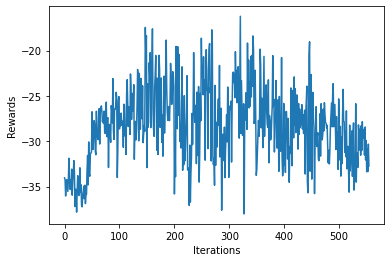

 56%|█████████████████████████████████████████▋                                 | 55602/100000 [48:12<44:13, 16.73it/s]

Updated Weights
Mean Reward = -33.34
16


 56%|█████████████████████████████████████████▊                                 | 55703/100000 [48:17<37:15, 19.81it/s]

Updated Weights
Mean Reward = -31.33
23


 56%|█████████████████████████████████████████▊                                 | 55802/100000 [48:23<42:08, 17.48it/s]

Updated Weights
Mean Reward = -34.04
15


 56%|█████████████████████████████████████████▉                                 | 55902/100000 [48:28<36:16, 20.26it/s]

Updated Weights
Mean Reward = -30.06
25


 56%|█████████████████████████████████████████▉                                 | 55999/100000 [48:33<35:29, 20.66it/s]

Updated Weights
Mean Reward = -28.71
30


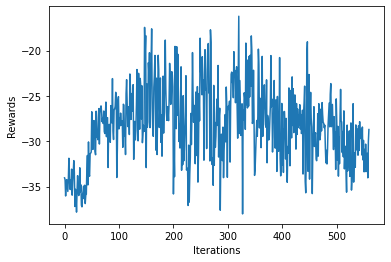

 56%|██████████████████████████████████████████                                 | 56103/100000 [48:39<40:21, 18.13it/s]

Updated Weights
Mean Reward = -31.94
21


 56%|██████████████████████████████████████████▏                                | 56202/100000 [48:45<43:34, 16.75it/s]

Updated Weights
Mean Reward = -32.65
17


 56%|██████████████████████████████████████████▏                                | 56303/100000 [48:50<34:47, 20.93it/s]

Updated Weights
Mean Reward = -30.94
23


 56%|██████████████████████████████████████████▎                                | 56404/100000 [48:56<43:59, 16.52it/s]

Updated Weights
Mean Reward = -33.07
19


 56%|██████████████████████████████████████████▎                                | 56500/100000 [49:01<41:56, 17.29it/s]

Updated Weights
Mean Reward = -30.98
22


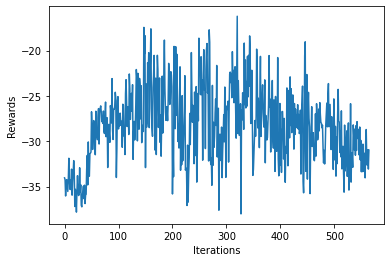

 57%|██████████████████████████████████████████▍                                | 56604/100000 [49:06<35:48, 20.20it/s]

Updated Weights
Mean Reward = -28.36
28


 57%|██████████████████████████████████████████▌                                | 56702/100000 [49:12<42:43, 16.89it/s]

Updated Weights
Mean Reward = -29.59
28


 57%|██████████████████████████████████████████▌                                | 56803/100000 [49:17<43:50, 16.42it/s]

Updated Weights
Mean Reward = -30.76
24


 57%|██████████████████████████████████████████▋                                | 56903/100000 [49:23<40:08, 17.89it/s]

Updated Weights
Mean Reward = -31.13
24


 57%|██████████████████████████████████████████▋                                | 56999/100000 [49:28<40:34, 17.66it/s]

Updated Weights
Mean Reward = -29.26
29


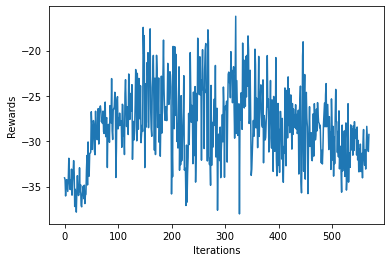

 57%|██████████████████████████████████████████▊                                | 57105/100000 [49:33<35:52, 19.93it/s]

Updated Weights
Mean Reward = -27.27
33


 57%|██████████████████████████████████████████▉                                | 57204/100000 [49:38<39:45, 17.94it/s]

Updated Weights
Mean Reward = -26.37
37


 57%|██████████████████████████████████████████▉                                | 57304/100000 [49:44<38:57, 18.27it/s]

Updated Weights
Mean Reward = -34.13
15


 57%|███████████████████████████████████████████                                | 57404/100000 [49:50<37:17, 19.04it/s]

Updated Weights
Mean Reward = -31.11
23


 57%|███████████████████████████████████████████                                | 57499/100000 [49:55<41:40, 16.99it/s]

Updated Weights
Mean Reward = -31.23
25


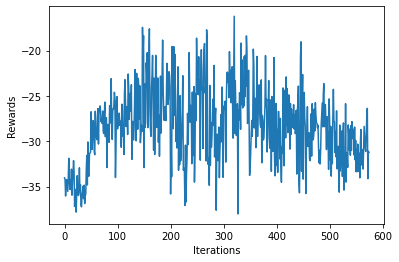

 58%|███████████████████████████████████████████▏                               | 57604/100000 [50:00<33:55, 20.82it/s]

Updated Weights
Mean Reward = -29.16
29


 58%|███████████████████████████████████████████▎                               | 57705/100000 [50:06<38:45, 18.19it/s]

Updated Weights
Mean Reward = -31.04
21


 58%|███████████████████████████████████████████▎                               | 57803/100000 [50:11<43:56, 16.01it/s]

Updated Weights
Mean Reward = -32.34
19


 58%|███████████████████████████████████████████▍                               | 57902/100000 [50:17<44:24, 15.80it/s]

Updated Weights
Mean Reward = -32.84
17


 58%|███████████████████████████████████████████▍                               | 57999/100000 [50:22<43:10, 16.22it/s]

Updated Weights
Mean Reward = -33.33
17


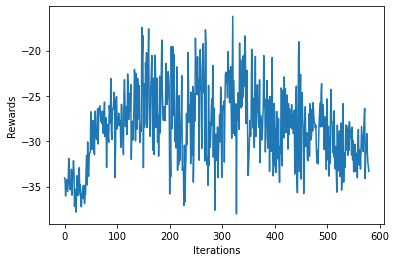

 58%|███████████████████████████████████████████▌                               | 58103/100000 [50:28<36:35, 19.08it/s]

Updated Weights
Mean Reward = -29.68
23


 58%|███████████████████████████████████████████▋                               | 58202/100000 [50:33<35:05, 19.85it/s]

Updated Weights
Mean Reward = -32.11
19


 58%|███████████████████████████████████████████▋                               | 58303/100000 [50:39<42:49, 16.23it/s]

Updated Weights
Mean Reward = -34.86
12


 58%|███████████████████████████████████████████▊                               | 58403/100000 [50:45<41:25, 16.73it/s]

Updated Weights
Mean Reward = -32.38
20


 58%|███████████████████████████████████████████▉                               | 58500/100000 [50:50<36:42, 18.84it/s]

Updated Weights
Mean Reward = -30.33
24


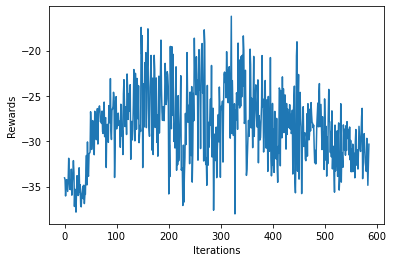

 59%|███████████████████████████████████████████▉                               | 58604/100000 [50:56<38:44, 17.81it/s]

Updated Weights
Mean Reward = -33.14
18


 59%|████████████████████████████████████████████                               | 58703/100000 [51:02<40:53, 16.83it/s]

Updated Weights
Mean Reward = -30.86
23


 59%|████████████████████████████████████████████                               | 58804/100000 [51:07<40:22, 17.00it/s]

Updated Weights
Mean Reward = -28.96
28


 59%|████████████████████████████████████████████▏                              | 58902/100000 [51:12<40:24, 16.95it/s]

Updated Weights
Mean Reward = -32.15
21


 59%|████████████████████████████████████████████▏                              | 58999/100000 [51:17<37:42, 18.12it/s]

Updated Weights
Mean Reward = -29.56
27


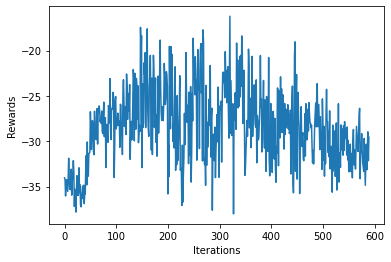

 59%|████████████████████████████████████████████▎                              | 59105/100000 [51:23<28:20, 24.05it/s]

Updated Weights
Mean Reward = -26.69
33


 59%|████████████████████████████████████████████▍                              | 59202/100000 [51:28<36:13, 18.77it/s]

Updated Weights
Mean Reward = -27.57
33


 59%|████████████████████████████████████████████▍                              | 59303/100000 [51:33<40:07, 16.90it/s]

Updated Weights
Mean Reward = -31.53
21


 59%|████████████████████████████████████████████▌                              | 59404/100000 [51:39<33:36, 20.13it/s]

Updated Weights
Mean Reward = -33.13
20


 59%|████████████████████████████████████████████▌                              | 59499/100000 [51:44<37:43, 17.89it/s]

Updated Weights
Mean Reward = -28.76
28


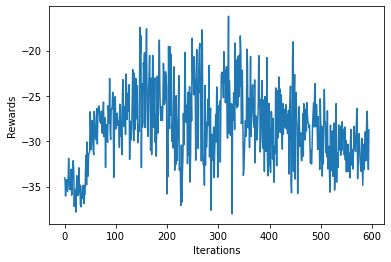

 60%|████████████████████████████████████████████▋                              | 59605/100000 [51:50<33:09, 20.30it/s]

Updated Weights
Mean Reward = -32.11
20


 60%|████████████████████████████████████████████▊                              | 59704/100000 [51:55<37:15, 18.02it/s]

Updated Weights
Mean Reward = -27.23
31


 60%|████████████████████████████████████████████▊                              | 59802/100000 [52:00<39:32, 16.95it/s]

Updated Weights
Mean Reward = -31.58
21


 60%|████████████████████████████████████████████▉                              | 59905/100000 [52:06<33:34, 19.90it/s]

Updated Weights
Mean Reward = -28.99
27


 60%|████████████████████████████████████████████▉                              | 59998/100000 [52:11<39:38, 16.82it/s]

Updated Weights
Mean Reward = -29.19
31


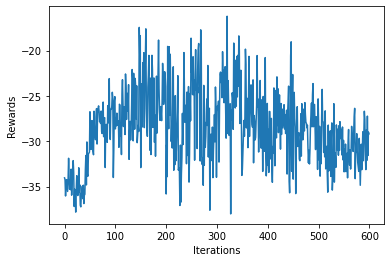

 60%|█████████████████████████████████████████████                              | 60104/100000 [52:17<40:03, 16.60it/s]

Updated Weights
Mean Reward = -31.3
21


 60%|█████████████████████████████████████████████▏                             | 60204/100000 [52:22<36:25, 18.21it/s]

Updated Weights
Mean Reward = -31.48
21


 60%|█████████████████████████████████████████████▏                             | 60303/100000 [52:27<38:08, 17.35it/s]

Updated Weights
Mean Reward = -30.1
24


 60%|█████████████████████████████████████████████▎                             | 60403/100000 [52:33<35:28, 18.60it/s]

Updated Weights
Mean Reward = -31.01
22


 60%|█████████████████████████████████████████████▍                             | 60500/100000 [52:38<37:02, 17.78it/s]

Updated Weights
Mean Reward = -31.93
21


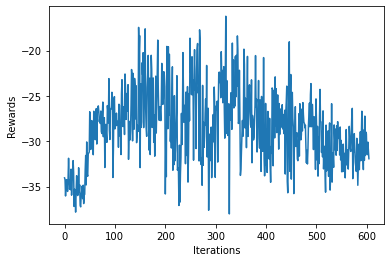

 61%|█████████████████████████████████████████████▍                             | 60603/100000 [52:44<41:00, 16.01it/s]

Updated Weights
Mean Reward = -30.09
25


 61%|█████████████████████████████████████████████▌                             | 60704/100000 [52:49<38:43, 16.91it/s]

Updated Weights
Mean Reward = -31.34
23


 61%|█████████████████████████████████████████████▌                             | 60802/100000 [52:54<34:02, 19.20it/s]

Updated Weights
Mean Reward = -28.87
29


 61%|█████████████████████████████████████████████▋                             | 60902/100000 [53:00<34:15, 19.02it/s]

Updated Weights
Mean Reward = -29.08
31


 61%|█████████████████████████████████████████████▋                             | 60999/100000 [53:05<36:59, 17.57it/s]

Updated Weights
Mean Reward = -28.46
28


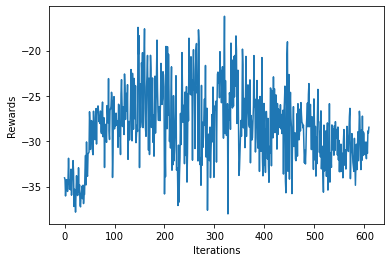

 61%|█████████████████████████████████████████████▊                             | 61103/100000 [53:11<42:34, 15.23it/s]

Updated Weights
Mean Reward = -32.7
20


 61%|█████████████████████████████████████████████▉                             | 61202/100000 [53:17<37:30, 17.24it/s]

Updated Weights
Mean Reward = -33.39
19


 61%|█████████████████████████████████████████████▉                             | 61303/100000 [53:23<37:03, 17.41it/s]

Updated Weights
Mean Reward = -30.42
24


 61%|██████████████████████████████████████████████                             | 61402/100000 [53:28<38:42, 16.62it/s]

Updated Weights
Mean Reward = -30.19
27


 61%|██████████████████████████████████████████████                             | 61499/100000 [53:34<40:22, 15.89it/s]

Updated Weights
Mean Reward = -34.45
16


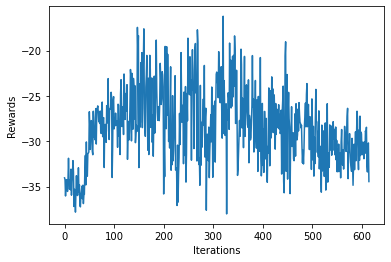

 62%|██████████████████████████████████████████████▏                            | 61605/100000 [53:40<32:30, 19.69it/s]

Updated Weights
Mean Reward = -27.54
31


 62%|██████████████████████████████████████████████▎                            | 61703/100000 [53:45<35:38, 17.91it/s]

Updated Weights
Mean Reward = -29.04
27


 62%|██████████████████████████████████████████████▎                            | 61803/100000 [53:51<37:52, 16.81it/s]

Updated Weights
Mean Reward = -32.7
20


 62%|██████████████████████████████████████████████▍                            | 61903/100000 [53:55<34:12, 18.56it/s]

Updated Weights
Mean Reward = -25.8
35


 62%|██████████████████████████████████████████████▍                            | 61999/100000 [54:01<39:09, 16.17it/s]

Updated Weights
Mean Reward = -35.54
11


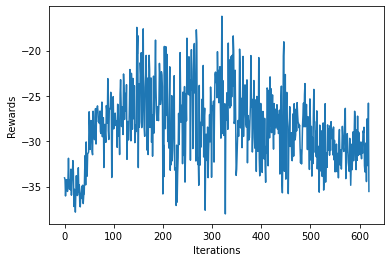

 62%|██████████████████████████████████████████████▌                            | 62103/100000 [54:07<38:51, 16.25it/s]

Updated Weights
Mean Reward = -34.75
17


 62%|██████████████████████████████████████████████▋                            | 62202/100000 [54:13<37:05, 16.98it/s]

Updated Weights
Mean Reward = -30.72
23


 62%|██████████████████████████████████████████████▋                            | 62303/100000 [54:18<31:15, 20.10it/s]

Updated Weights
Mean Reward = -30.25
25


 62%|██████████████████████████████████████████████▊                            | 62403/100000 [54:24<38:56, 16.09it/s]

Updated Weights
Mean Reward = -33.16
18


 62%|██████████████████████████████████████████████▉                            | 62500/100000 [54:29<35:55, 17.40it/s]

Updated Weights
Mean Reward = -32.33
18


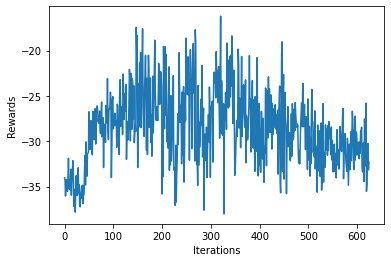

 63%|██████████████████████████████████████████████▉                            | 62602/100000 [54:35<38:27, 16.21it/s]

Updated Weights
Mean Reward = -32.88
18


 63%|███████████████████████████████████████████████                            | 62703/100000 [54:41<34:36, 17.96it/s]

Updated Weights
Mean Reward = -34.01
15


 63%|███████████████████████████████████████████████                            | 62803/100000 [54:46<37:30, 16.53it/s]

Updated Weights
Mean Reward = -32.91
17


 63%|███████████████████████████████████████████████▏                           | 62902/100000 [54:52<34:54, 17.71it/s]

Updated Weights
Mean Reward = -30.97
20


 63%|███████████████████████████████████████████████▏                           | 62998/100000 [54:57<31:05, 19.84it/s]

Updated Weights
Mean Reward = -29.86
24


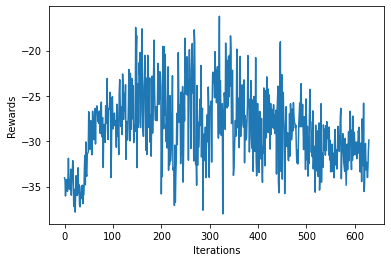

 63%|███████████████████████████████████████████████▎                           | 63102/100000 [55:03<37:16, 16.50it/s]

Updated Weights
Mean Reward = -36.35
9


 63%|███████████████████████████████████████████████▍                           | 63202/100000 [55:08<27:09, 22.58it/s]

Updated Weights
Mean Reward = -29.31
26


 63%|███████████████████████████████████████████████▍                           | 63304/100000 [55:14<32:09, 19.02it/s]

Updated Weights
Mean Reward = -29.91
27


 63%|███████████████████████████████████████████████▌                           | 63403/100000 [55:20<32:00, 19.05it/s]

Updated Weights
Mean Reward = -33.66
19


 63%|███████████████████████████████████████████████▌                           | 63499/100000 [55:25<35:59, 16.90it/s]

Updated Weights
Mean Reward = -33.15
18


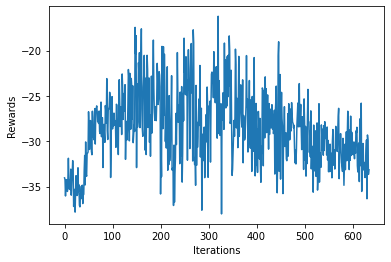

 64%|███████████████████████████████████████████████▋                           | 63603/100000 [55:31<37:52, 16.02it/s]

Updated Weights
Mean Reward = -31.52
21


 64%|███████████████████████████████████████████████▊                           | 63703/100000 [55:37<34:54, 17.33it/s]

Updated Weights
Mean Reward = -35.58
11


 64%|███████████████████████████████████████████████▊                           | 63802/100000 [55:42<32:36, 18.50it/s]

Updated Weights
Mean Reward = -33.23
17


 64%|███████████████████████████████████████████████▉                           | 63902/100000 [55:48<33:31, 17.95it/s]

Updated Weights
Mean Reward = -33.49
16


 64%|████████████████████████████████████████████████                           | 64000/100000 [55:54<33:27, 17.94it/s]

Updated Weights
Mean Reward = -33.98
14


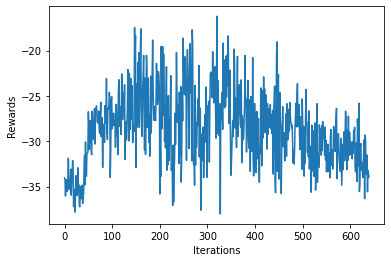

 64%|████████████████████████████████████████████████                           | 64102/100000 [55:59<31:04, 19.25it/s]

Updated Weights
Mean Reward = -31.6
20


 64%|████████████████████████████████████████████████▏                          | 64202/100000 [56:05<35:16, 16.91it/s]

Updated Weights
Mean Reward = -32.4
18


 64%|████████████████████████████████████████████████▏                          | 64302/100000 [56:10<33:25, 17.80it/s]

Updated Weights
Mean Reward = -31.94
19


 64%|████████████████████████████████████████████████▎                          | 64403/100000 [56:16<33:56, 17.48it/s]

Updated Weights
Mean Reward = -31.25
21


 64%|████████████████████████████████████████████████▍                          | 64500/100000 [56:22<36:20, 16.28it/s]

Updated Weights
Mean Reward = -35.21
13


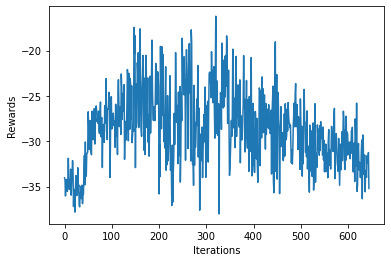

 65%|████████████████████████████████████████████████▍                          | 64605/100000 [56:28<32:55, 17.92it/s]

Updated Weights
Mean Reward = -34.38
14


 65%|████████████████████████████████████████████████▌                          | 64704/100000 [56:33<35:00, 16.80it/s]

Updated Weights
Mean Reward = -30.2
23


 65%|████████████████████████████████████████████████▌                          | 64803/100000 [56:39<33:19, 17.60it/s]

Updated Weights
Mean Reward = -34.75
13


 65%|████████████████████████████████████████████████▋                          | 64903/100000 [56:44<32:33, 17.97it/s]

Updated Weights
Mean Reward = -28.51
27


 65%|████████████████████████████████████████████████▋                          | 64999/100000 [56:49<35:52, 16.26it/s]

Updated Weights
Mean Reward = -32.09
21


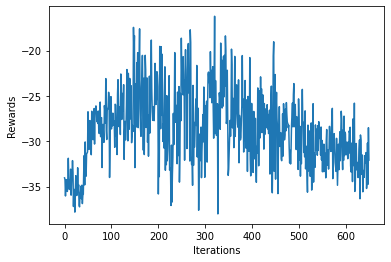

 65%|████████████████████████████████████████████████▊                          | 65104/100000 [56:55<35:35, 16.34it/s]

Updated Weights
Mean Reward = -35.29
12


 65%|████████████████████████████████████████████████▉                          | 65203/100000 [57:01<28:06, 20.63it/s]

Updated Weights
Mean Reward = -30.37
23


 65%|████████████████████████████████████████████████▉                          | 65303/100000 [57:06<33:09, 17.44it/s]

Updated Weights
Mean Reward = -30.81
23


 65%|█████████████████████████████████████████████████                          | 65403/100000 [57:12<36:33, 15.77it/s]

Updated Weights
Mean Reward = -32.06
20


 65%|█████████████████████████████████████████████████                          | 65499/100000 [57:17<34:51, 16.50it/s]

Updated Weights
Mean Reward = -34.94
13


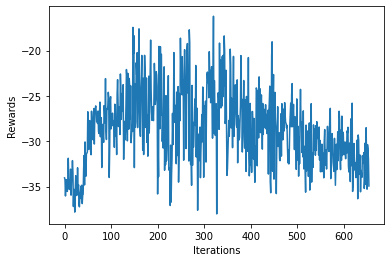

 66%|█████████████████████████████████████████████████▏                         | 65603/100000 [57:24<41:00, 13.98it/s]

Updated Weights
Mean Reward = -35.9
10


 66%|█████████████████████████████████████████████████▎                         | 65703/100000 [57:30<35:55, 15.91it/s]

Updated Weights
Mean Reward = -33.9
14


 66%|█████████████████████████████████████████████████▎                         | 65805/100000 [57:36<29:28, 19.33it/s]

Updated Weights
Mean Reward = -32.52
17


 66%|█████████████████████████████████████████████████▍                         | 65902/100000 [57:41<32:09, 17.67it/s]

Updated Weights
Mean Reward = -31.87
20


 66%|█████████████████████████████████████████████████▍                         | 65999/100000 [57:46<34:40, 16.34it/s]

Updated Weights
Mean Reward = -33.19
20


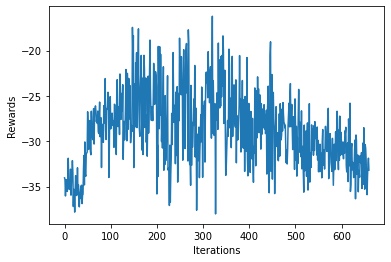

 66%|█████████████████████████████████████████████████▌                         | 66103/100000 [57:52<30:29, 18.53it/s]

Updated Weights
Mean Reward = -33.6
16


 66%|█████████████████████████████████████████████████▋                         | 66203/100000 [57:58<30:39, 18.37it/s]

Updated Weights
Mean Reward = -34.59
13


 66%|█████████████████████████████████████████████████▋                         | 66305/100000 [58:04<29:31, 19.02it/s]

Updated Weights
Mean Reward = -32.56
17


 66%|█████████████████████████████████████████████████▊                         | 66403/100000 [58:09<26:27, 21.16it/s]

Updated Weights
Mean Reward = -30.27
28


 66%|█████████████████████████████████████████████████▉                         | 66500/100000 [58:15<32:59, 16.92it/s]

Updated Weights
Mean Reward = -31.35
21


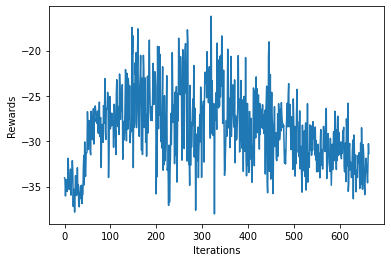

 67%|█████████████████████████████████████████████████▉                         | 66602/100000 [58:20<33:38, 16.55it/s]

Updated Weights
Mean Reward = -32.51
18


 67%|██████████████████████████████████████████████████                         | 66702/100000 [58:26<30:44, 18.05it/s]

Updated Weights
Mean Reward = -31.68
21


 67%|██████████████████████████████████████████████████                         | 66803/100000 [58:32<34:47, 15.91it/s]

Updated Weights
Mean Reward = -33.47
18


 67%|██████████████████████████████████████████████████▏                        | 66905/100000 [58:37<26:03, 21.17it/s]

Updated Weights
Mean Reward = -29.89
25


 67%|██████████████████████████████████████████████████▎                        | 67000/100000 [58:42<32:15, 17.05it/s]

Updated Weights
Mean Reward = -31.16
21


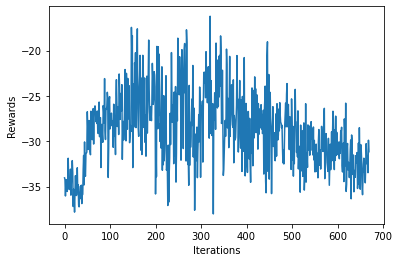

 67%|██████████████████████████████████████████████████▎                        | 67106/100000 [58:48<24:42, 22.19it/s]

Updated Weights
Mean Reward = -32.08
20


 67%|██████████████████████████████████████████████████▍                        | 67202/100000 [58:54<36:07, 15.13it/s]

Updated Weights
Mean Reward = -31.55
19


 67%|██████████████████████████████████████████████████▍                        | 67305/100000 [58:59<27:03, 20.13it/s]

Updated Weights
Mean Reward = -30.03
25


 67%|██████████████████████████████████████████████████▌                        | 67404/100000 [59:05<31:19, 17.34it/s]

Updated Weights
Mean Reward = -34.58
14


 68%|██████████████████████████████████████████████████▋                        | 67500/100000 [59:10<31:21, 17.28it/s]

Updated Weights
Mean Reward = -31.05
22


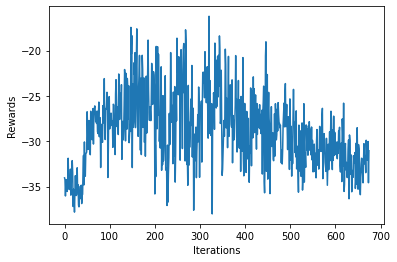

 68%|██████████████████████████████████████████████████▋                        | 67604/100000 [59:16<31:54, 16.92it/s]

Updated Weights
Mean Reward = -31.59
21


 68%|██████████████████████████████████████████████████▊                        | 67703/100000 [59:22<34:10, 15.75it/s]

Updated Weights
Mean Reward = -33.37
16


 68%|██████████████████████████████████████████████████▊                        | 67803/100000 [59:27<31:41, 16.94it/s]

Updated Weights
Mean Reward = -35.82
11


 68%|██████████████████████████████████████████████████▉                        | 67903/100000 [59:33<28:50, 18.54it/s]

Updated Weights
Mean Reward = -34.35
16


 68%|███████████████████████████████████████████████████                        | 68000/100000 [59:38<26:18, 20.27it/s]

Updated Weights
Mean Reward = -31.64
20


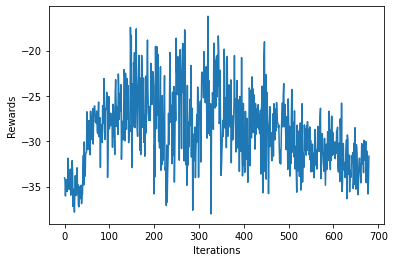

 68%|███████████████████████████████████████████████████                        | 68103/100000 [59:44<24:19, 21.86it/s]

Updated Weights
Mean Reward = -27.98
29


 68%|███████████████████████████████████████████████████▏                       | 68202/100000 [59:49<25:03, 21.14it/s]

Updated Weights
Mean Reward = -28.62
28


 68%|███████████████████████████████████████████████████▏                       | 68302/100000 [59:54<26:41, 19.79it/s]

Updated Weights
Mean Reward = -31.83
21


 68%|█████████████████████████████████████████████████▉                       | 68404/100000 [1:00:00<29:03, 18.12it/s]

Updated Weights
Mean Reward = -32.98
18


 68%|██████████████████████████████████████████████████                       | 68500/100000 [1:00:05<28:47, 18.24it/s]

Updated Weights
Mean Reward = -30.33
24


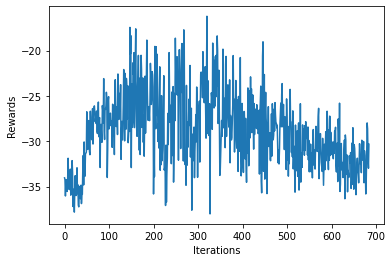

 69%|██████████████████████████████████████████████████                       | 68604/100000 [1:00:11<26:44, 19.56it/s]

Updated Weights
Mean Reward = -30.54
23


 69%|██████████████████████████████████████████████████▏                      | 68704/100000 [1:00:17<30:00, 17.38it/s]

Updated Weights
Mean Reward = -33.64
17


 69%|██████████████████████████████████████████████████▏                      | 68802/100000 [1:00:22<29:35, 17.57it/s]

Updated Weights
Mean Reward = -31.53
20


 69%|██████████████████████████████████████████████████▎                      | 68904/100000 [1:00:28<29:15, 17.72it/s]

Updated Weights
Mean Reward = -33.41
20


 69%|██████████████████████████████████████████████████▎                      | 69000/100000 [1:00:33<28:56, 17.85it/s]

Updated Weights
Mean Reward = -31.47
22


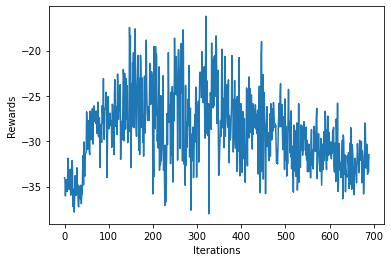

 69%|██████████████████████████████████████████████████▍                      | 69103/100000 [1:00:40<30:27, 16.90it/s]

Updated Weights
Mean Reward = -34.7
13


 69%|██████████████████████████████████████████████████▌                      | 69203/100000 [1:00:45<30:03, 17.08it/s]

Updated Weights
Mean Reward = -34.24
15


 69%|██████████████████████████████████████████████████▌                      | 69303/100000 [1:00:51<29:31, 17.33it/s]

Updated Weights
Mean Reward = -33.14
18


 69%|██████████████████████████████████████████████████▋                      | 69403/100000 [1:00:57<30:31, 16.70it/s]

Updated Weights
Mean Reward = -36.48
10


 69%|██████████████████████████████████████████████████▋                      | 69499/100000 [1:01:02<27:49, 18.27it/s]

Updated Weights
Mean Reward = -34.71
14


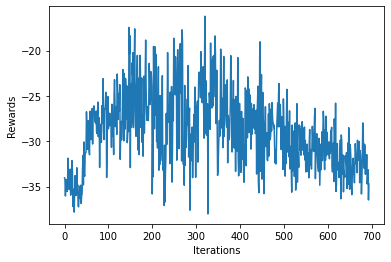

 70%|██████████████████████████████████████████████████▊                      | 69604/100000 [1:01:08<28:12, 17.96it/s]

Updated Weights
Mean Reward = -31.43
23


 70%|██████████████████████████████████████████████████▉                      | 69702/100000 [1:01:14<31:10, 16.20it/s]

Updated Weights
Mean Reward = -33.02
19


 70%|██████████████████████████████████████████████████▉                      | 69803/100000 [1:01:20<30:16, 16.62it/s]

Updated Weights
Mean Reward = -32.81
19


 70%|███████████████████████████████████████████████████                      | 69903/100000 [1:01:25<27:08, 18.48it/s]

Updated Weights
Mean Reward = -35.32
13


 70%|███████████████████████████████████████████████████                      | 70000/100000 [1:01:31<23:42, 21.09it/s]

Updated Weights
Mean Reward = -31.59
21


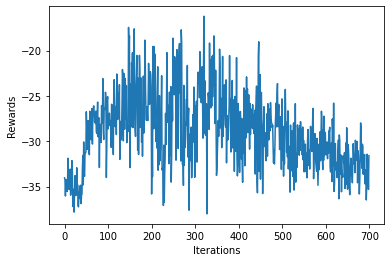

 70%|███████████████████████████████████████████████████▏                     | 70105/100000 [1:01:37<26:17, 18.95it/s]

Updated Weights
Mean Reward = -33.39
18


 70%|███████████████████████████████████████████████████▏                     | 70203/100000 [1:01:42<30:18, 16.39it/s]

Updated Weights
Mean Reward = -31.96
21


 70%|███████████████████████████████████████████████████▎                     | 70303/100000 [1:01:48<28:27, 17.39it/s]

Updated Weights
Mean Reward = -33.31
19


 70%|███████████████████████████████████████████████████▍                     | 70402/100000 [1:01:53<29:29, 16.72it/s]

Updated Weights
Mean Reward = -32.28
21


 70%|███████████████████████████████████████████████████▍                     | 70499/100000 [1:01:59<25:37, 19.19it/s]

Updated Weights
Mean Reward = -31.99
21


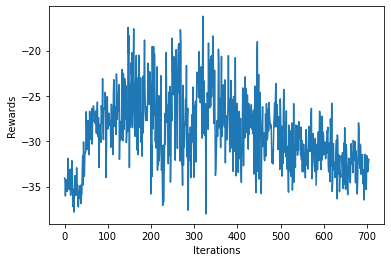

 71%|███████████████████████████████████████████████████▌                     | 70601/100000 [1:02:04<24:51, 19.71it/s]

Updated Weights
Mean Reward = -29.99
24


 71%|███████████████████████████████████████████████████▌                     | 70702/100000 [1:02:10<24:39, 19.80it/s]

Updated Weights
Mean Reward = -29.32
26


 71%|███████████████████████████████████████████████████▋                     | 70803/100000 [1:02:15<31:36, 15.39it/s]

Updated Weights
Mean Reward = -30.88
22


 71%|███████████████████████████████████████████████████▊                     | 70904/100000 [1:02:21<27:51, 17.40it/s]

Updated Weights
Mean Reward = -32.11
20


 71%|███████████████████████████████████████████████████▊                     | 71000/100000 [1:02:26<24:16, 19.91it/s]

Updated Weights
Mean Reward = -32.05
19


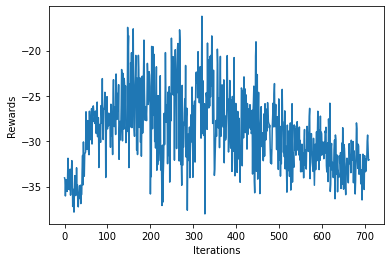

 71%|███████████████████████████████████████████████████▉                     | 71103/100000 [1:02:32<29:15, 16.46it/s]

Updated Weights
Mean Reward = -33.53
16


 71%|███████████████████████████████████████████████████▉                     | 71203/100000 [1:02:38<27:07, 17.70it/s]

Updated Weights
Mean Reward = -32.13
20


 71%|████████████████████████████████████████████████████                     | 71303/100000 [1:02:43<27:10, 17.60it/s]

Updated Weights
Mean Reward = -29.69
25


 71%|████████████████████████████████████████████████████                     | 71403/100000 [1:02:48<25:39, 18.57it/s]

Updated Weights
Mean Reward = -30.66
23


 71%|████████████████████████████████████████████████████▏                    | 71499/100000 [1:02:54<28:48, 16.49it/s]

Updated Weights
Mean Reward = -30.49
25


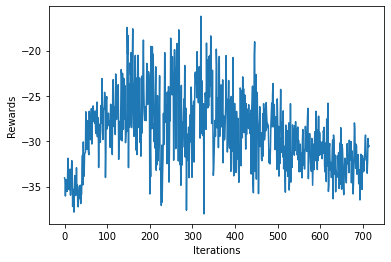

 72%|████████████████████████████████████████████████████▎                    | 71604/100000 [1:03:00<26:24, 17.92it/s]

Updated Weights
Mean Reward = -33.12
17


 72%|████████████████████████████████████████████████████▎                    | 71703/100000 [1:03:05<26:18, 17.93it/s]

Updated Weights
Mean Reward = -31.7
19


 72%|████████████████████████████████████████████████████▍                    | 71803/100000 [1:03:11<25:47, 18.22it/s]

Updated Weights
Mean Reward = -34.32
13


 72%|████████████████████████████████████████████████████▍                    | 71903/100000 [1:03:16<25:53, 18.08it/s]

Updated Weights
Mean Reward = -33.42
18


 72%|████████████████████████████████████████████████████▌                    | 72000/100000 [1:03:22<29:47, 15.66it/s]

Updated Weights
Mean Reward = -30.67
24


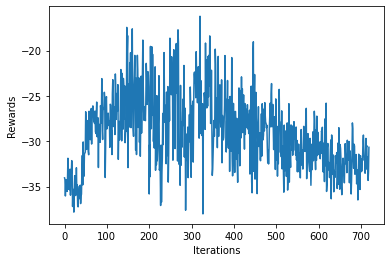

 72%|████████████████████████████████████████████████████▋                    | 72103/100000 [1:03:27<27:39, 16.81it/s]

Updated Weights
Mean Reward = -31.75
21


 72%|████████████████████████████████████████████████████▋                    | 72203/100000 [1:03:33<27:01, 17.14it/s]

Updated Weights
Mean Reward = -34.04
15


 72%|████████████████████████████████████████████████████▊                    | 72303/100000 [1:03:39<26:49, 17.20it/s]

Updated Weights
Mean Reward = -32.67
18


 72%|████████████████████████████████████████████████████▊                    | 72403/100000 [1:03:44<28:28, 16.15it/s]

Updated Weights
Mean Reward = -32.0
19


 72%|████████████████████████████████████████████████████▉                    | 72499/100000 [1:03:50<25:28, 17.99it/s]

Updated Weights
Mean Reward = -35.6
14


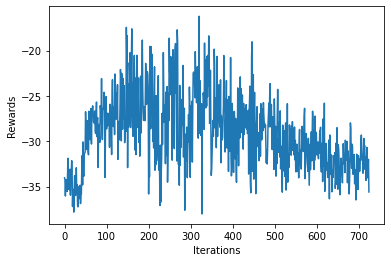

 73%|█████████████████████████████████████████████████████                    | 72603/100000 [1:03:56<28:30, 16.01it/s]

Updated Weights
Mean Reward = -32.92
18


 73%|█████████████████████████████████████████████████████                    | 72704/100000 [1:04:01<27:42, 16.41it/s]

Updated Weights
Mean Reward = -31.36
22


 73%|█████████████████████████████████████████████████████▏                   | 72804/100000 [1:04:07<28:23, 15.96it/s]

Updated Weights
Mean Reward = -36.13
11


 73%|█████████████████████████████████████████████████████▏                   | 72902/100000 [1:04:13<28:06, 16.06it/s]

Updated Weights
Mean Reward = -32.21
21


 73%|█████████████████████████████████████████████████████▎                   | 72999/100000 [1:04:20<37:36, 11.96it/s]

Updated Weights
Mean Reward = -32.65
20


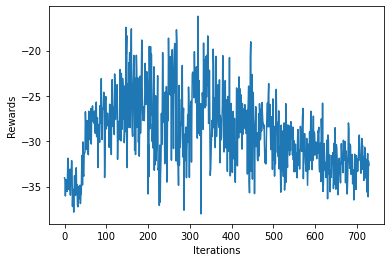

 73%|█████████████████████████████████████████████████████▎                   | 73102/100000 [1:04:26<24:34, 18.24it/s]

Updated Weights
Mean Reward = -32.29
18


 73%|█████████████████████████████████████████████████████▍                   | 73203/100000 [1:04:31<26:42, 16.72it/s]

Updated Weights
Mean Reward = -29.89
24


 73%|█████████████████████████████████████████████████████▌                   | 73303/100000 [1:04:37<27:25, 16.22it/s]

Updated Weights
Mean Reward = -34.02
15


 73%|█████████████████████████████████████████████████████▌                   | 73403/100000 [1:04:43<26:17, 16.86it/s]

Updated Weights
Mean Reward = -36.69
10


 73%|█████████████████████████████████████████████████████▋                   | 73499/100000 [1:04:48<27:08, 16.27it/s]

Updated Weights
Mean Reward = -28.88
26


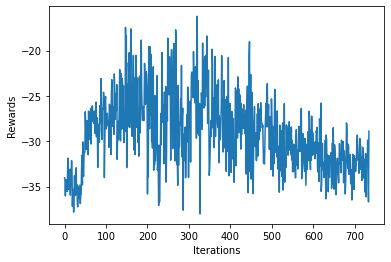

 74%|█████████████████████████████████████████████████████▋                   | 73602/100000 [1:04:54<25:38, 17.16it/s]

Updated Weights
Mean Reward = -30.25
27


 74%|█████████████████████████████████████████████████████▊                   | 73703/100000 [1:05:00<27:23, 16.00it/s]

Updated Weights
Mean Reward = -32.77
19


 74%|█████████████████████████████████████████████████████▉                   | 73802/100000 [1:05:06<26:44, 16.33it/s]

Updated Weights
Mean Reward = -33.84
15


 74%|█████████████████████████████████████████████████████▉                   | 73905/100000 [1:05:11<20:50, 20.87it/s]

Updated Weights
Mean Reward = -29.69
24


 74%|██████████████████████████████████████████████████████                   | 73998/100000 [1:05:16<28:30, 15.20it/s]

Updated Weights
Mean Reward = -28.34
28


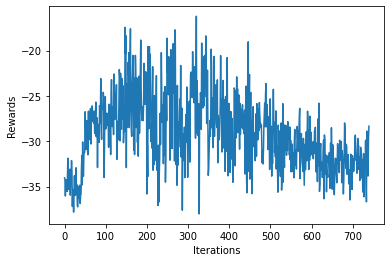

 74%|██████████████████████████████████████████████████████                   | 74105/100000 [1:05:23<19:50, 21.76it/s]

Updated Weights
Mean Reward = -32.26
21


 74%|██████████████████████████████████████████████████████▏                  | 74202/100000 [1:05:28<23:50, 18.04it/s]

Updated Weights
Mean Reward = -31.67
20


 74%|██████████████████████████████████████████████████████▏                  | 74302/100000 [1:05:34<24:47, 17.27it/s]

Updated Weights
Mean Reward = -33.28
16


 74%|██████████████████████████████████████████████████████▎                  | 74406/100000 [1:05:39<19:26, 21.94it/s]

Updated Weights
Mean Reward = -28.71
28


 74%|██████████████████████████████████████████████████████▍                  | 74500/100000 [1:05:45<25:47, 16.47it/s]

Updated Weights
Mean Reward = -36.87
8


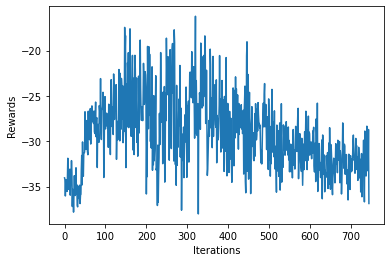

 75%|██████████████████████████████████████████████████████▍                  | 74604/100000 [1:05:51<26:47, 15.80it/s]

Updated Weights
Mean Reward = -37.57
6


 75%|██████████████████████████████████████████████████████▌                  | 74703/100000 [1:05:57<24:21, 17.31it/s]

Updated Weights
Mean Reward = -33.92
15


 75%|██████████████████████████████████████████████████████▌                  | 74803/100000 [1:06:02<22:00, 19.09it/s]

Updated Weights
Mean Reward = -33.68
15


 75%|██████████████████████████████████████████████████████▋                  | 74903/100000 [1:06:08<25:51, 16.18it/s]

Updated Weights
Mean Reward = -32.48
19


 75%|██████████████████████████████████████████████████████▋                  | 74999/100000 [1:06:13<20:20, 20.49it/s]

Updated Weights
Mean Reward = -31.57
20


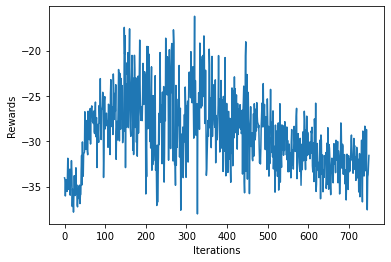

 75%|██████████████████████████████████████████████████████▊                  | 75103/100000 [1:06:19<23:31, 17.64it/s]

Updated Weights
Mean Reward = -30.01
23


 75%|██████████████████████████████████████████████████████▉                  | 75202/100000 [1:06:25<24:56, 16.57it/s]

Updated Weights
Mean Reward = -35.89
9


 75%|██████████████████████████████████████████████████████▉                  | 75303/100000 [1:06:31<24:22, 16.88it/s]

Updated Weights
Mean Reward = -32.61
19


 75%|███████████████████████████████████████████████████████                  | 75404/100000 [1:06:36<22:49, 17.96it/s]

Updated Weights
Mean Reward = -33.28
17


 75%|███████████████████████████████████████████████████████                  | 75499/100000 [1:06:42<22:38, 18.04it/s]

Updated Weights
Mean Reward = -33.17
18


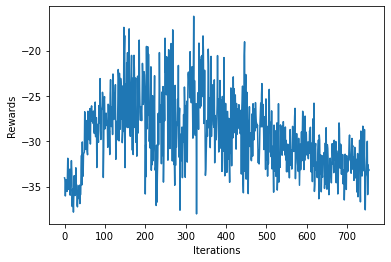

 76%|███████████████████████████████████████████████████████▏                 | 75602/100000 [1:06:48<24:10, 16.82it/s]

Updated Weights
Mean Reward = -32.46
17


 76%|███████████████████████████████████████████████████████▎                 | 75703/100000 [1:06:53<25:02, 16.17it/s]

Updated Weights
Mean Reward = -33.59
16


 76%|███████████████████████████████████████████████████████▎                 | 75802/100000 [1:06:59<24:15, 16.62it/s]

Updated Weights
Mean Reward = -30.27
24


 76%|███████████████████████████████████████████████████████▍                 | 75902/100000 [1:07:04<24:45, 16.22it/s]

Updated Weights
Mean Reward = -30.03
24


 76%|███████████████████████████████████████████████████████▍                 | 76000/100000 [1:07:10<26:08, 15.30it/s]

Updated Weights
Mean Reward = -36.5
11


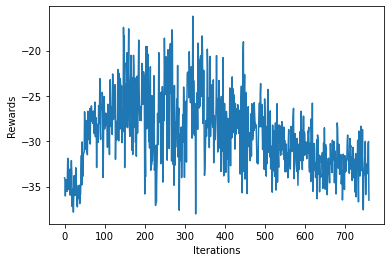

 76%|███████████████████████████████████████████████████████▌                 | 76102/100000 [1:07:16<22:55, 17.38it/s]

Updated Weights
Mean Reward = -30.69
23


 76%|███████████████████████████████████████████████████████▋                 | 76203/100000 [1:07:21<23:55, 16.57it/s]

Updated Weights
Mean Reward = -30.56
24


 76%|███████████████████████████████████████████████████████▋                 | 76302/100000 [1:07:27<25:23, 15.56it/s]

Updated Weights
Mean Reward = -32.18
19


 76%|███████████████████████████████████████████████████████▊                 | 76402/100000 [1:07:32<23:21, 16.84it/s]

Updated Weights
Mean Reward = -31.49
22


 76%|███████████████████████████████████████████████████████▊                 | 76500/100000 [1:07:37<19:15, 20.34it/s]

Updated Weights
Mean Reward = -28.32
29


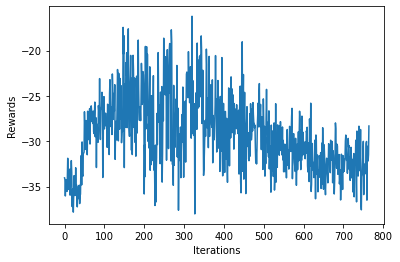

 77%|███████████████████████████████████████████████████████▉                 | 76605/100000 [1:07:43<20:52, 18.68it/s]

Updated Weights
Mean Reward = -31.41
21


 77%|███████████████████████████████████████████████████████▉                 | 76704/100000 [1:07:49<22:06, 17.56it/s]

Updated Weights
Mean Reward = -30.83
22


 77%|████████████████████████████████████████████████████████                 | 76803/100000 [1:07:55<21:40, 17.83it/s]

Updated Weights
Mean Reward = -35.01
13


 77%|████████████████████████████████████████████████████████▏                | 76902/100000 [1:08:00<23:26, 16.42it/s]

Updated Weights
Mean Reward = -35.51
11


 77%|████████████████████████████████████████████████████████▏                | 76999/100000 [1:08:06<21:46, 17.61it/s]

Updated Weights
Mean Reward = -36.36
8


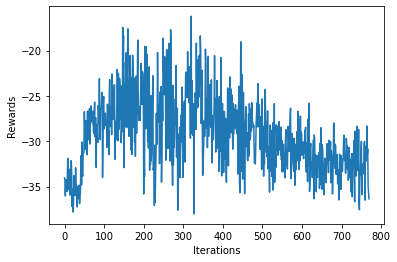

 77%|████████████████████████████████████████████████████████▎                | 77102/100000 [1:08:11<19:52, 19.21it/s]

Updated Weights
Mean Reward = -28.19
28


 77%|████████████████████████████████████████████████████████▎                | 77203/100000 [1:08:17<21:18, 17.83it/s]

Updated Weights
Mean Reward = -28.84
27


 77%|████████████████████████████████████████████████████████▍                | 77302/100000 [1:08:22<19:29, 19.41it/s]

Updated Weights
Mean Reward = -30.6
24


 77%|████████████████████████████████████████████████████████▌                | 77404/100000 [1:08:28<20:41, 18.20it/s]

Updated Weights
Mean Reward = -32.76
19


 77%|████████████████████████████████████████████████████████▌                | 77499/100000 [1:08:33<22:31, 16.65it/s]

Updated Weights
Mean Reward = -32.05
20


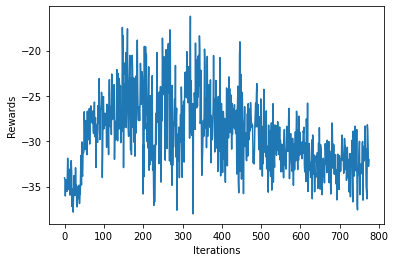

 78%|████████████████████████████████████████████████████████▋                | 77604/100000 [1:08:39<21:39, 17.24it/s]

Updated Weights
Mean Reward = -31.35
22


 78%|████████████████████████████████████████████████████████▋                | 77702/100000 [1:08:45<22:35, 16.45it/s]

Updated Weights
Mean Reward = -34.0
16


 78%|████████████████████████████████████████████████████████▊                | 77804/100000 [1:08:50<20:53, 17.71it/s]

Updated Weights
Mean Reward = -33.19
17


 78%|████████████████████████████████████████████████████████▊                | 77903/100000 [1:08:56<21:21, 17.24it/s]

Updated Weights
Mean Reward = -31.86
19


 78%|████████████████████████████████████████████████████████▉                | 78000/100000 [1:09:01<21:26, 17.10it/s]

Updated Weights
Mean Reward = -34.6
14


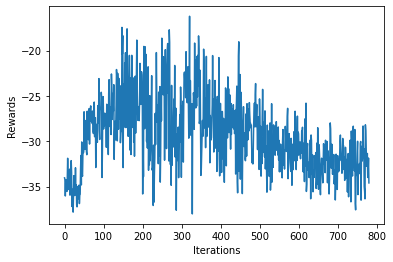

 78%|█████████████████████████████████████████████████████████                | 78104/100000 [1:09:08<20:19, 17.96it/s]

Updated Weights
Mean Reward = -36.21
10


 78%|█████████████████████████████████████████████████████████                | 78204/100000 [1:09:13<20:24, 17.80it/s]

Updated Weights
Mean Reward = -31.44
20


 78%|█████████████████████████████████████████████████████████▏               | 78304/100000 [1:09:19<18:56, 19.09it/s]

Updated Weights
Mean Reward = -33.34
17


 78%|█████████████████████████████████████████████████████████▏               | 78402/100000 [1:09:25<20:49, 17.28it/s]

Updated Weights
Mean Reward = -36.28
9


 78%|█████████████████████████████████████████████████████████▎               | 78500/100000 [1:09:30<20:17, 17.66it/s]

Updated Weights
Mean Reward = -32.05
20


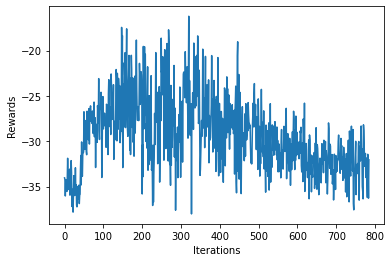

 79%|█████████████████████████████████████████████████████████▍               | 78604/100000 [1:09:36<19:34, 18.22it/s]

Updated Weights
Mean Reward = -33.29
16


 79%|█████████████████████████████████████████████████████████▍               | 78704/100000 [1:09:42<20:46, 17.09it/s]

Updated Weights
Mean Reward = -34.5
13


 79%|█████████████████████████████████████████████████████████▌               | 78802/100000 [1:09:48<22:26, 15.74it/s]

Updated Weights
Mean Reward = -34.18
16


 79%|█████████████████████████████████████████████████████████▌               | 78904/100000 [1:09:54<21:15, 16.55it/s]

Updated Weights
Mean Reward = -35.64
11


 79%|█████████████████████████████████████████████████████████▋               | 79000/100000 [1:09:59<19:55, 17.56it/s]

Updated Weights
Mean Reward = -30.08
26


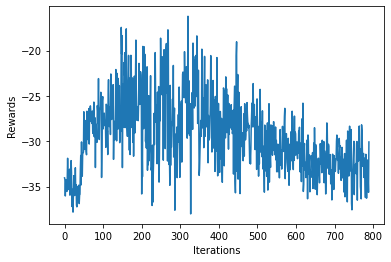

 79%|█████████████████████████████████████████████████████████▋               | 79106/100000 [1:10:06<16:21, 21.28it/s]

Updated Weights
Mean Reward = -36.07
10


 79%|█████████████████████████████████████████████████████████▊               | 79203/100000 [1:10:11<19:50, 17.46it/s]

Updated Weights
Mean Reward = -31.84
20


 79%|████████████████████████████████████████████████████████▎              | 79301/100000 [1:10:18<1:01:52,  5.58it/s]

Updated Weights
Mean Reward = -35.62
11


 79%|█████████████████████████████████████████████████████████▉               | 79404/100000 [1:10:24<19:55, 17.23it/s]

Updated Weights
Mean Reward = -32.3
19


 79%|██████████████████████████████████████████████████████████               | 79499/100000 [1:10:29<16:03, 21.27it/s]

Updated Weights
Mean Reward = -30.13
24


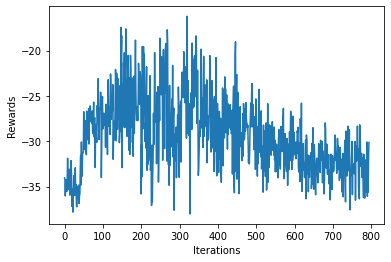

 80%|██████████████████████████████████████████████████████████               | 79603/100000 [1:10:35<18:39, 18.22it/s]

Updated Weights
Mean Reward = -31.71
19


 80%|██████████████████████████████████████████████████████████▏              | 79702/100000 [1:10:41<20:09, 16.78it/s]

Updated Weights
Mean Reward = -34.25
15


 80%|██████████████████████████████████████████████████████████▎              | 79803/100000 [1:10:46<18:58, 17.74it/s]

Updated Weights
Mean Reward = -33.91
16


 80%|██████████████████████████████████████████████████████████▎              | 79902/100000 [1:10:52<19:04, 17.56it/s]

Updated Weights
Mean Reward = -31.02
23


 80%|██████████████████████████████████████████████████████████▍              | 80000/100000 [1:10:57<19:50, 16.80it/s]

Updated Weights
Mean Reward = -29.7
26


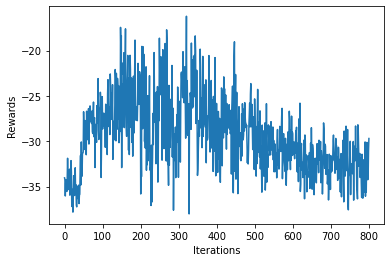

 80%|██████████████████████████████████████████████████████████▍              | 80104/100000 [1:11:03<17:10, 19.31it/s]

Updated Weights
Mean Reward = -32.89
16


 80%|██████████████████████████████████████████████████████████▌              | 80203/100000 [1:11:08<17:45, 18.58it/s]

Updated Weights
Mean Reward = -27.61
30


 80%|██████████████████████████████████████████████████████████▌              | 80303/100000 [1:11:14<18:21, 17.88it/s]

Updated Weights
Mean Reward = -35.05
13


 80%|██████████████████████████████████████████████████████████▋              | 80402/100000 [1:11:19<18:29, 17.66it/s]

Updated Weights
Mean Reward = -31.75
21


 80%|██████████████████████████████████████████████████████████▊              | 80499/100000 [1:11:24<19:27, 16.70it/s]

Updated Weights
Mean Reward = -31.15
22


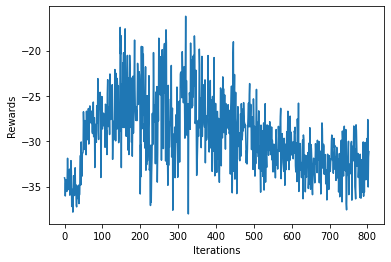

 81%|██████████████████████████████████████████████████████████▊              | 80603/100000 [1:11:31<17:56, 18.01it/s]

Updated Weights
Mean Reward = -33.96
15


 81%|██████████████████████████████████████████████████████████▉              | 80701/100000 [1:11:36<15:37, 20.58it/s]

Updated Weights
Mean Reward = -30.07
25


 81%|██████████████████████████████████████████████████████████▉              | 80804/100000 [1:11:42<19:25, 16.47it/s]

Updated Weights
Mean Reward = -32.1
21


 81%|███████████████████████████████████████████████████████████              | 80904/100000 [1:11:47<17:51, 17.82it/s]

Updated Weights
Mean Reward = -31.64
21


 81%|███████████████████████████████████████████████████████████▏             | 81000/100000 [1:11:52<18:33, 17.06it/s]

Updated Weights
Mean Reward = -33.26
16


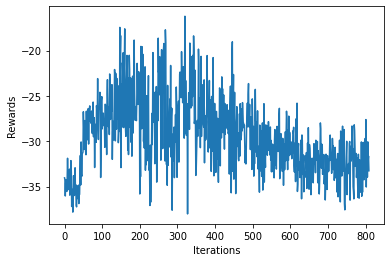

 81%|███████████████████████████████████████████████████████████▏             | 81103/100000 [1:11:58<14:48, 21.27it/s]

Updated Weights
Mean Reward = -29.62
23


 81%|███████████████████████████████████████████████████████████▎             | 81202/100000 [1:12:03<18:19, 17.10it/s]

Updated Weights
Mean Reward = -31.31
20


 81%|███████████████████████████████████████████████████████████▎             | 81302/100000 [1:12:09<17:21, 17.96it/s]

Updated Weights
Mean Reward = -32.07
20


 81%|███████████████████████████████████████████████████████████▍             | 81402/100000 [1:12:14<16:31, 18.76it/s]

Updated Weights
Mean Reward = -32.27
18


 81%|███████████████████████████████████████████████████████████▍             | 81499/100000 [1:12:21<18:40, 16.51it/s]

Updated Weights
Mean Reward = -33.63
16


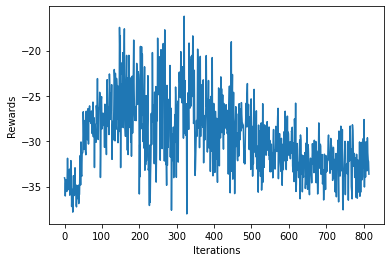

 82%|███████████████████████████████████████████████████████████▌             | 81603/100000 [1:12:27<15:40, 19.57it/s]

Updated Weights
Mean Reward = -31.46
21


 82%|███████████████████████████████████████████████████████████▋             | 81703/100000 [1:12:33<17:21, 17.57it/s]

Updated Weights
Mean Reward = -33.38
17


 82%|███████████████████████████████████████████████████████████▋             | 81805/100000 [1:12:39<16:02, 18.91it/s]

Updated Weights
Mean Reward = -35.7
11


 82%|███████████████████████████████████████████████████████████▊             | 81906/100000 [1:12:44<13:54, 21.68it/s]

Updated Weights
Mean Reward = -29.62
27


 82%|███████████████████████████████████████████████████████████▊             | 82000/100000 [1:12:49<16:13, 18.49it/s]

Updated Weights
Mean Reward = -31.53
20


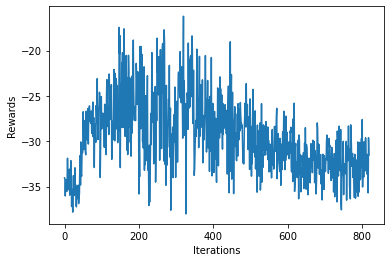

 82%|███████████████████████████████████████████████████████████▉             | 82102/100000 [1:12:55<18:06, 16.48it/s]

Updated Weights
Mean Reward = -32.23
21


 82%|████████████████████████████████████████████████████████████             | 82204/100000 [1:13:01<16:23, 18.09it/s]

Updated Weights
Mean Reward = -32.63
18


 82%|████████████████████████████████████████████████████████████             | 82304/100000 [1:13:06<17:08, 17.20it/s]

Updated Weights
Mean Reward = -30.23
23


 82%|████████████████████████████████████████████████████████████▏            | 82402/100000 [1:13:11<15:30, 18.91it/s]

Updated Weights
Mean Reward = -28.55
27


 82%|████████████████████████████████████████████████████████████▏            | 82499/100000 [1:13:16<17:31, 16.64it/s]

Updated Weights
Mean Reward = -32.21
19


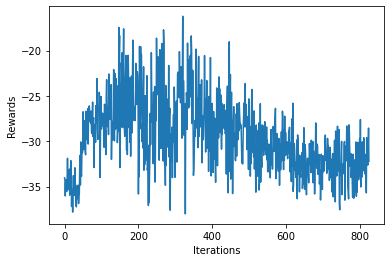

 83%|████████████████████████████████████████████████████████████▎            | 82602/100000 [1:13:22<16:20, 17.74it/s]

Updated Weights
Mean Reward = -32.46
19


 83%|████████████████████████████████████████████████████████████▎            | 82704/100000 [1:13:28<16:38, 17.32it/s]

Updated Weights
Mean Reward = -33.17
16


 83%|████████████████████████████████████████████████████████████▍            | 82805/100000 [1:13:34<13:49, 20.72it/s]

Updated Weights
Mean Reward = -31.76
22


 83%|████████████████████████████████████████████████████████████▌            | 82904/100000 [1:13:39<14:21, 19.84it/s]

Updated Weights
Mean Reward = -29.99
25


 83%|████████████████████████████████████████████████████████████▌            | 82999/100000 [1:13:44<16:01, 17.68it/s]

Updated Weights
Mean Reward = -31.51
22


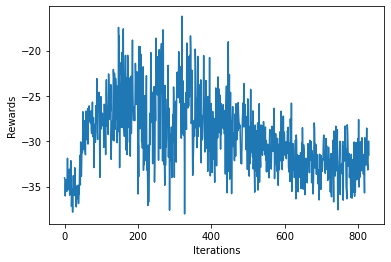

 83%|████████████████████████████████████████████████████████████▋            | 83104/100000 [1:13:50<17:18, 16.28it/s]

Updated Weights
Mean Reward = -33.99
16


 83%|████████████████████████████████████████████████████████████▋            | 83204/100000 [1:13:56<16:15, 17.21it/s]

Updated Weights
Mean Reward = -29.55
25


 83%|████████████████████████████████████████████████████████████▊            | 83302/100000 [1:14:01<18:16, 15.23it/s]

Updated Weights
Mean Reward = -34.17
14


 83%|████████████████████████████████████████████████████████████▉            | 83404/100000 [1:14:07<16:52, 16.38it/s]

Updated Weights
Mean Reward = -33.68
16


 84%|████████████████████████████████████████████████████████████▉            | 83500/100000 [1:14:13<15:20, 17.92it/s]

Updated Weights
Mean Reward = -36.79
9


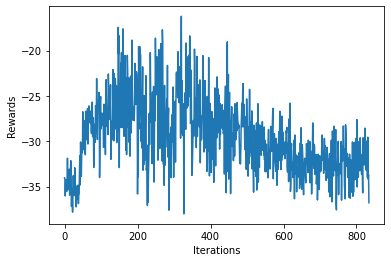

 84%|█████████████████████████████████████████████████████████████            | 83604/100000 [1:14:21<15:18, 17.85it/s]

Updated Weights
Mean Reward = -32.95
17


 84%|█████████████████████████████████████████████████████████████            | 83702/100000 [1:14:27<17:31, 15.50it/s]

Updated Weights
Mean Reward = -36.15
9


 84%|█████████████████████████████████████████████████████████████▏           | 83804/100000 [1:14:32<16:18, 16.56it/s]

Updated Weights
Mean Reward = -32.62
18


 84%|█████████████████████████████████████████████████████████████▏           | 83904/100000 [1:14:38<14:27, 18.55it/s]

Updated Weights
Mean Reward = -30.65
22


 84%|█████████████████████████████████████████████████████████████▎           | 83999/100000 [1:14:43<14:19, 18.62it/s]

Updated Weights
Mean Reward = -31.22
21


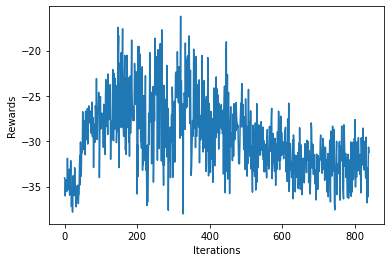

 84%|█████████████████████████████████████████████████████████████▍           | 84104/100000 [1:14:49<16:23, 16.16it/s]

Updated Weights
Mean Reward = -31.99
21


 84%|█████████████████████████████████████████████████████████████▍           | 84203/100000 [1:14:54<14:50, 17.73it/s]

Updated Weights
Mean Reward = -31.86
19


 84%|█████████████████████████████████████████████████████████████▌           | 84303/100000 [1:15:00<14:31, 18.01it/s]

Updated Weights
Mean Reward = -33.35
17


 84%|█████████████████████████████████████████████████████████████▌           | 84403/100000 [1:15:05<14:27, 17.98it/s]

Updated Weights
Mean Reward = -30.46
23


 84%|█████████████████████████████████████████████████████████████▋           | 84499/100000 [1:15:10<14:41, 17.59it/s]

Updated Weights
Mean Reward = -27.78
29


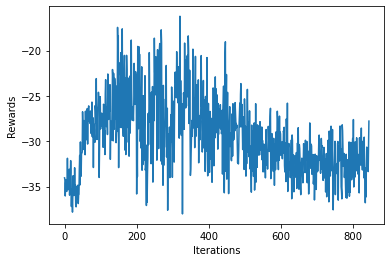

 85%|█████████████████████████████████████████████████████████████▊           | 84603/100000 [1:15:16<15:07, 16.97it/s]

Updated Weights
Mean Reward = -29.83
26


 85%|█████████████████████████████████████████████████████████████▊           | 84703/100000 [1:15:21<14:02, 18.15it/s]

Updated Weights
Mean Reward = -32.62
18


 85%|█████████████████████████████████████████████████████████████▉           | 84803/100000 [1:15:27<14:22, 17.62it/s]

Updated Weights
Mean Reward = -34.4
15


 85%|█████████████████████████████████████████████████████████████▉           | 84903/100000 [1:15:33<14:25, 17.44it/s]

Updated Weights
Mean Reward = -29.73
26


 85%|██████████████████████████████████████████████████████████████           | 84999/100000 [1:15:38<16:11, 15.44it/s]

Updated Weights
Mean Reward = -35.74
12


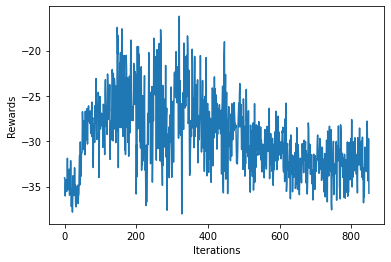

 85%|██████████████████████████████████████████████████████████████▏          | 85103/100000 [1:15:44<11:55, 20.81it/s]

Updated Weights
Mean Reward = -29.86
23


 85%|██████████████████████████████████████████████████████████████▏          | 85203/100000 [1:15:49<14:42, 16.76it/s]

Updated Weights
Mean Reward = -29.6
24


 85%|██████████████████████████████████████████████████████████████▎          | 85304/100000 [1:15:55<15:05, 16.22it/s]

Updated Weights
Mean Reward = -31.12
23


 85%|██████████████████████████████████████████████████████████████▎          | 85403/100000 [1:16:00<13:32, 17.98it/s]

Updated Weights
Mean Reward = -31.46
22


 85%|██████████████████████████████████████████████████████████████▍          | 85498/100000 [1:16:05<13:40, 17.68it/s]

Updated Weights
Mean Reward = -33.18
17


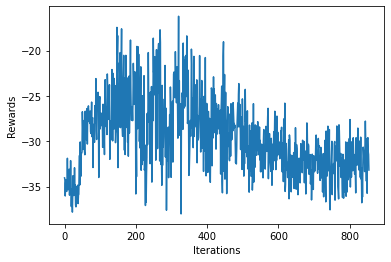

 86%|██████████████████████████████████████████████████████████████▍          | 85603/100000 [1:16:11<12:48, 18.73it/s]

Updated Weights
Mean Reward = -30.79
24


 86%|██████████████████████████████████████████████████████████████▌          | 85702/100000 [1:16:17<15:47, 15.10it/s]

Updated Weights
Mean Reward = -30.19
25


 86%|██████████████████████████████████████████████████████████████▋          | 85802/100000 [1:16:23<14:25, 16.40it/s]

Updated Weights
Mean Reward = -30.61
23


 86%|██████████████████████████████████████████████████████████████▋          | 85902/100000 [1:16:29<15:09, 15.50it/s]

Updated Weights
Mean Reward = -35.1
15


 86%|██████████████████████████████████████████████████████████████▊          | 86000/100000 [1:16:35<14:04, 16.59it/s]

Updated Weights
Mean Reward = -32.12
21


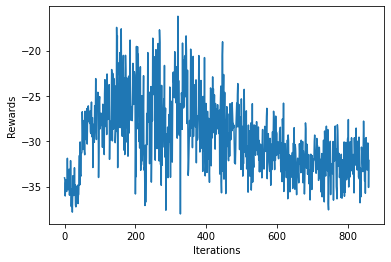

 86%|██████████████████████████████████████████████████████████████▊          | 86102/100000 [1:16:41<14:56, 15.51it/s]

Updated Weights
Mean Reward = -32.82
21


 86%|██████████████████████████████████████████████████████████████▉          | 86204/100000 [1:16:47<13:16, 17.32it/s]

Updated Weights
Mean Reward = -34.83
14


 86%|███████████████████████████████████████████████████████████████          | 86303/100000 [1:16:53<12:25, 18.37it/s]

Updated Weights
Mean Reward = -33.81
14


 86%|███████████████████████████████████████████████████████████████          | 86402/100000 [1:16:59<14:30, 15.62it/s]

Updated Weights
Mean Reward = -33.4
16


 86%|███████████████████████████████████████████████████████████████▏         | 86499/100000 [1:17:05<14:57, 15.05it/s]

Updated Weights
Mean Reward = -33.1
18


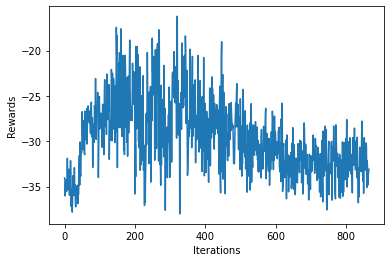

 87%|███████████████████████████████████████████████████████████████▏         | 86603/100000 [1:17:11<11:53, 18.78it/s]

Updated Weights
Mean Reward = -32.33
20


 87%|███████████████████████████████████████████████████████████████▎         | 86703/100000 [1:17:16<13:34, 16.33it/s]

Updated Weights
Mean Reward = -31.04
22


 87%|███████████████████████████████████████████████████████████████▎         | 86803/100000 [1:17:22<12:21, 17.79it/s]

Updated Weights
Mean Reward = -35.41
13


 87%|███████████████████████████████████████████████████████████████▍         | 86903/100000 [1:17:28<13:07, 16.63it/s]

Updated Weights
Mean Reward = -33.7
16


 87%|███████████████████████████████████████████████████████████████▌         | 86999/100000 [1:17:33<11:47, 18.38it/s]

Updated Weights
Mean Reward = -31.66
22


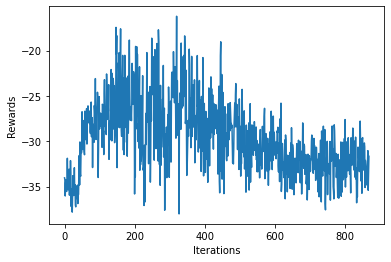

 87%|███████████████████████████████████████████████████████████████▌         | 87102/100000 [1:17:39<11:50, 18.15it/s]

Updated Weights
Mean Reward = -31.07
25


 87%|███████████████████████████████████████████████████████████████▋         | 87203/100000 [1:17:44<12:50, 16.62it/s]

Updated Weights
Mean Reward = -32.5
20


 87%|███████████████████████████████████████████████████████████████▋         | 87303/100000 [1:17:50<12:13, 17.30it/s]

Updated Weights
Mean Reward = -35.24
13


 87%|███████████████████████████████████████████████████████████████▊         | 87403/100000 [1:17:56<12:54, 16.26it/s]

Updated Weights
Mean Reward = -34.64
14


 87%|███████████████████████████████████████████████████████████████▊         | 87498/100000 [1:18:01<12:21, 16.87it/s]

Updated Weights
Mean Reward = -33.7
16


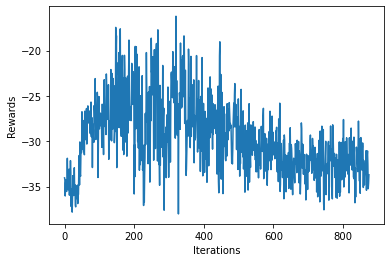

 88%|███████████████████████████████████████████████████████████████▉         | 87604/100000 [1:18:07<12:04, 17.10it/s]

Updated Weights
Mean Reward = -32.43
18


 88%|████████████████████████████████████████████████████████████████         | 87703/100000 [1:18:13<12:13, 16.76it/s]

Updated Weights
Mean Reward = -31.65
21


 88%|████████████████████████████████████████████████████████████████         | 87802/100000 [1:18:20<23:24,  8.68it/s]

Updated Weights
Mean Reward = -32.19
20


 88%|████████████████████████████████████████████████████████████████▏        | 87903/100000 [1:18:25<11:33, 17.43it/s]

Updated Weights
Mean Reward = -30.8
24


 88%|████████████████████████████████████████████████████████████████▏        | 87999/100000 [1:18:31<12:04, 16.57it/s]

Updated Weights
Mean Reward = -32.69
20


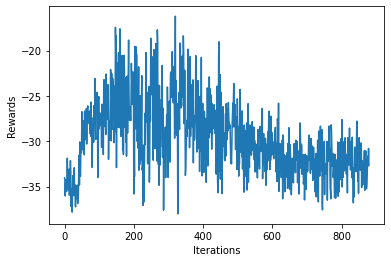

 88%|████████████████████████████████████████████████████████████████▎        | 88102/100000 [1:18:37<10:32, 18.81it/s]

Updated Weights
Mean Reward = -32.9
19


 88%|████████████████████████████████████████████████████████████████▍        | 88203/100000 [1:18:42<12:21, 15.91it/s]

Updated Weights
Mean Reward = -32.43
20


 88%|████████████████████████████████████████████████████████████████▍        | 88304/100000 [1:18:48<11:35, 16.82it/s]

Updated Weights
Mean Reward = -30.62
24


 88%|████████████████████████████████████████████████████████████████▌        | 88402/100000 [1:18:53<11:40, 16.56it/s]

Updated Weights
Mean Reward = -31.48
22


 88%|████████████████████████████████████████████████████████████████▌        | 88499/100000 [1:18:58<10:52, 17.64it/s]

Updated Weights
Mean Reward = -33.02
18


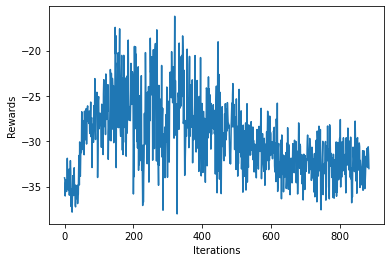

 89%|████████████████████████████████████████████████████████████████▋        | 88603/100000 [1:19:04<10:48, 17.57it/s]

Updated Weights
Mean Reward = -33.42
16


 89%|████████████████████████████████████████████████████████████████▊        | 88702/100000 [1:19:10<10:04, 18.68it/s]

Updated Weights
Mean Reward = -33.79
15


 89%|████████████████████████████████████████████████████████████████▊        | 88803/100000 [1:19:16<11:17, 16.54it/s]

Updated Weights
Mean Reward = -32.36
18


 89%|████████████████████████████████████████████████████████████████▉        | 88903/100000 [1:19:21<11:19, 16.33it/s]

Updated Weights
Mean Reward = -31.57
21


 89%|████████████████████████████████████████████████████████████████▉        | 88999/100000 [1:19:27<09:37, 19.04it/s]

Updated Weights
Mean Reward = -32.85
19


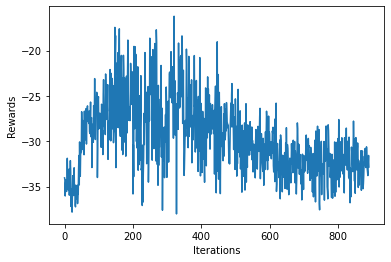

 89%|█████████████████████████████████████████████████████████████████        | 89102/100000 [1:19:32<11:18, 16.06it/s]

Updated Weights
Mean Reward = -31.28
23


 89%|█████████████████████████████████████████████████████████████████        | 89203/100000 [1:19:38<11:20, 15.88it/s]

Updated Weights
Mean Reward = -29.44
25


 89%|█████████████████████████████████████████████████████████████████▏       | 89303/100000 [1:19:44<10:08, 17.56it/s]

Updated Weights
Mean Reward = -35.23
11


 89%|█████████████████████████████████████████████████████████████████▎       | 89403/100000 [1:19:49<10:53, 16.22it/s]

Updated Weights
Mean Reward = -32.43
20


 90%|█████████████████████████████████████████████████████████████████▎       | 89500/100000 [1:19:55<10:59, 15.92it/s]

Updated Weights
Mean Reward = -32.51
18


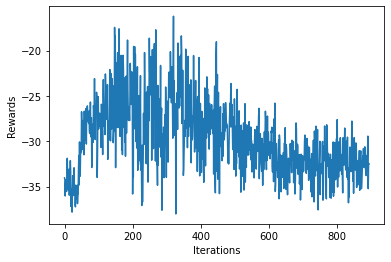

 90%|█████████████████████████████████████████████████████████████████▍       | 89603/100000 [1:20:01<08:32, 20.29it/s]

Updated Weights
Mean Reward = -33.52
15


 90%|█████████████████████████████████████████████████████████████████▍       | 89704/100000 [1:20:06<10:39, 16.11it/s]

Updated Weights
Mean Reward = -33.32
17


 90%|█████████████████████████████████████████████████████████████████▌       | 89803/100000 [1:20:12<08:23, 20.27it/s]

Updated Weights
Mean Reward = -31.36
22


 90%|█████████████████████████████████████████████████████████████████▋       | 89901/100000 [1:20:18<08:14, 20.42it/s]

Updated Weights
Mean Reward = -34.11
15


 90%|█████████████████████████████████████████████████████████████████▋       | 90000/100000 [1:20:25<10:56, 15.24it/s]

Updated Weights
Mean Reward = -31.88
19


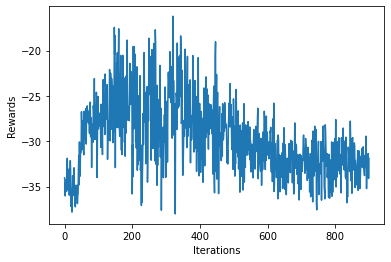

 90%|█████████████████████████████████████████████████████████████████▊       | 90103/100000 [1:20:30<09:28, 17.40it/s]

Updated Weights
Mean Reward = -31.88
21


 90%|█████████████████████████████████████████████████████████████████▊       | 90204/100000 [1:20:36<10:11, 16.02it/s]

Updated Weights
Mean Reward = -34.67
15


 90%|█████████████████████████████████████████████████████████████████▉       | 90303/100000 [1:20:42<09:43, 16.63it/s]

Updated Weights
Mean Reward = -34.26
15


 90%|█████████████████████████████████████████████████████████████████▉       | 90403/100000 [1:20:47<07:44, 20.67it/s]

Updated Weights
Mean Reward = -32.39
18


 90%|██████████████████████████████████████████████████████████████████       | 90499/100000 [1:20:53<09:41, 16.35it/s]

Updated Weights
Mean Reward = -35.42
10


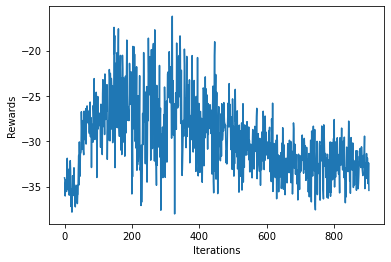

 91%|██████████████████████████████████████████████████████████████████▏      | 90603/100000 [1:20:59<09:11, 17.05it/s]

Updated Weights
Mean Reward = -34.05
16


 91%|██████████████████████████████████████████████████████████████████▏      | 90703/100000 [1:21:05<09:26, 16.40it/s]

Updated Weights
Mean Reward = -32.14
20


 91%|██████████████████████████████████████████████████████████████████▎      | 90802/100000 [1:21:10<09:02, 16.95it/s]

Updated Weights
Mean Reward = -33.65
15


 91%|██████████████████████████████████████████████████████████████████▎      | 90903/100000 [1:21:16<09:00, 16.82it/s]

Updated Weights
Mean Reward = -32.35
19


 91%|██████████████████████████████████████████████████████████████████▍      | 90999/100000 [1:21:22<08:32, 17.57it/s]

Updated Weights
Mean Reward = -36.3
11


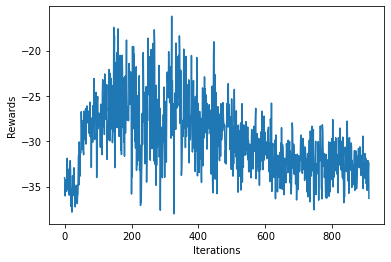

 91%|██████████████████████████████████████████████████████████████████▌      | 91104/100000 [1:21:28<08:16, 17.91it/s]

Updated Weights
Mean Reward = -31.65
21


 91%|██████████████████████████████████████████████████████████████████▌      | 91204/100000 [1:21:33<09:22, 15.64it/s]

Updated Weights
Mean Reward = -32.16
19


 91%|██████████████████████████████████████████████████████████████████▋      | 91303/100000 [1:21:39<09:20, 15.53it/s]

Updated Weights
Mean Reward = -31.81
19


 91%|██████████████████████████████████████████████████████████████████▋      | 91403/100000 [1:21:44<08:55, 16.05it/s]

Updated Weights
Mean Reward = -34.95
12


 92%|██████████████████████████████████████████████████████████████████▊      | 91500/100000 [1:21:50<07:24, 19.12it/s]

Updated Weights
Mean Reward = -33.82
16


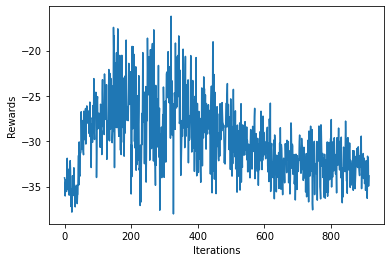

 92%|██████████████████████████████████████████████████████████████████▊      | 91602/100000 [1:21:56<07:28, 18.73it/s]

Updated Weights
Mean Reward = -31.81
22


 92%|██████████████████████████████████████████████████████████████████▉      | 91703/100000 [1:22:02<07:44, 17.88it/s]

Updated Weights
Mean Reward = -34.05
15


 92%|███████████████████████████████████████████████████████████████████      | 91802/100000 [1:22:07<08:33, 15.96it/s]

Updated Weights
Mean Reward = -33.41
16


 92%|███████████████████████████████████████████████████████████████████      | 91904/100000 [1:22:13<08:22, 16.10it/s]

Updated Weights
Mean Reward = -34.93
12


 92%|███████████████████████████████████████████████████████████████████▏     | 92000/100000 [1:22:20<09:37, 13.85it/s]

Updated Weights
Mean Reward = -35.4
12


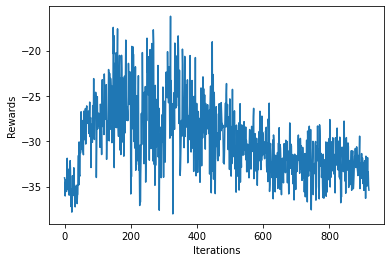

 92%|███████████████████████████████████████████████████████████████████▏     | 92103/100000 [1:22:26<08:01, 16.41it/s]

Updated Weights
Mean Reward = -33.15
16


 92%|███████████████████████████████████████████████████████████████████▎     | 92203/100000 [1:22:32<07:48, 16.63it/s]

Updated Weights
Mean Reward = -34.02
14


 92%|███████████████████████████████████████████████████████████████████▍     | 92303/100000 [1:22:38<08:00, 16.00it/s]

Updated Weights
Mean Reward = -36.06
9


 92%|███████████████████████████████████████████████████████████████████▍     | 92402/100000 [1:22:43<07:06, 17.80it/s]

Updated Weights
Mean Reward = -28.1
28


 92%|███████████████████████████████████████████████████████████████████▌     | 92500/100000 [1:22:48<06:54, 18.11it/s]

Updated Weights
Mean Reward = -28.98
26


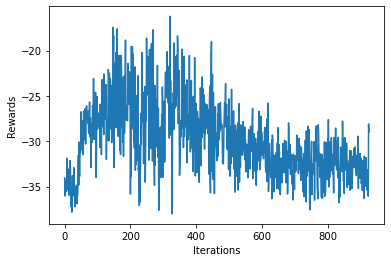

 93%|███████████████████████████████████████████████████████████████████▌     | 92603/100000 [1:22:54<07:25, 16.60it/s]

Updated Weights
Mean Reward = -32.18
19


 93%|███████████████████████████████████████████████████████████████████▋     | 92703/100000 [1:23:00<07:17, 16.67it/s]

Updated Weights
Mean Reward = -32.85
17


 93%|███████████████████████████████████████████████████████████████████▋     | 92804/100000 [1:23:05<07:05, 16.91it/s]

Updated Weights
Mean Reward = -34.9
12


 93%|███████████████████████████████████████████████████████████████████▊     | 92902/100000 [1:23:11<06:41, 17.70it/s]

Updated Weights
Mean Reward = -32.57
17


 93%|███████████████████████████████████████████████████████████████████▉     | 93000/100000 [1:23:16<06:26, 18.11it/s]

Updated Weights
Mean Reward = -31.69
20


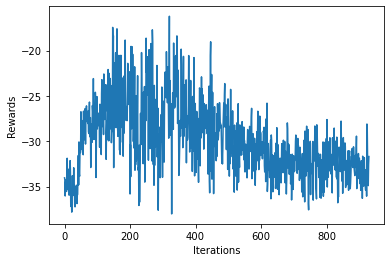

 93%|███████████████████████████████████████████████████████████████████▉     | 93102/100000 [1:23:22<06:30, 17.68it/s]

Updated Weights
Mean Reward = -33.58
17


 93%|████████████████████████████████████████████████████████████████████     | 93204/100000 [1:23:28<06:11, 18.27it/s]

Updated Weights
Mean Reward = -34.83
14


 93%|████████████████████████████████████████████████████████████████████     | 93303/100000 [1:23:34<06:35, 16.91it/s]

Updated Weights
Mean Reward = -33.59
16


 93%|████████████████████████████████████████████████████████████████████▏    | 93404/100000 [1:23:40<06:21, 17.30it/s]

Updated Weights
Mean Reward = -35.08
13


 94%|████████████████████████████████████████████████████████████████████▎    | 93500/100000 [1:23:45<06:25, 16.87it/s]

Updated Weights
Mean Reward = -31.92
20


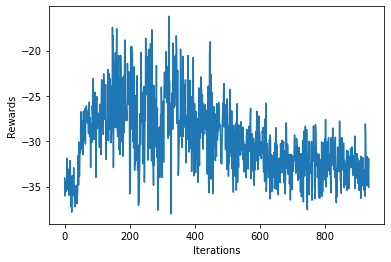

 94%|████████████████████████████████████████████████████████████████████▎    | 93603/100000 [1:23:51<06:41, 15.93it/s]

Updated Weights
Mean Reward = -33.45
16


 94%|████████████████████████████████████████████████████████████████████▍    | 93702/100000 [1:23:56<04:40, 22.48it/s]

Updated Weights
Mean Reward = -28.15
30


 94%|████████████████████████████████████████████████████████████████████▍    | 93802/100000 [1:24:01<06:15, 16.49it/s]

Updated Weights
Mean Reward = -32.8
18


 94%|████████████████████████████████████████████████████████████████████▌    | 93903/100000 [1:24:07<06:12, 16.37it/s]

Updated Weights
Mean Reward = -33.17
20


 94%|████████████████████████████████████████████████████████████████████▌    | 93999/100000 [1:24:13<05:32, 18.07it/s]

Updated Weights
Mean Reward = -35.35
12


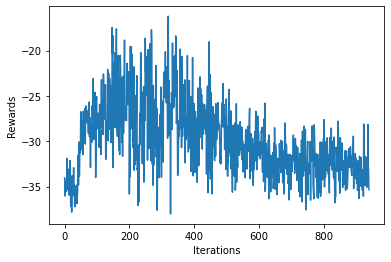

 94%|████████████████████████████████████████████████████████████████████▋    | 94102/100000 [1:24:20<07:15, 13.54it/s]

Updated Weights
Mean Reward = -33.41
18


 94%|████████████████████████████████████████████████████████████████████▊    | 94205/100000 [1:24:26<04:29, 21.49it/s]

Updated Weights
Mean Reward = -31.13
24


 94%|████████████████████████████████████████████████████████████████████▊    | 94303/100000 [1:24:31<05:47, 16.40it/s]

Updated Weights
Mean Reward = -30.12
26


 94%|████████████████████████████████████████████████████████████████████▉    | 94402/100000 [1:24:37<04:39, 20.00it/s]

Updated Weights
Mean Reward = -30.47
25


 94%|████████████████████████████████████████████████████████████████████▉    | 94500/100000 [1:24:42<05:12, 17.60it/s]

Updated Weights
Mean Reward = -31.98
20


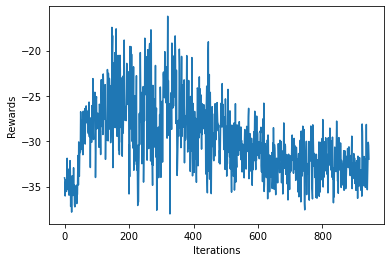

 95%|█████████████████████████████████████████████████████████████████████    | 94603/100000 [1:24:48<04:20, 20.74it/s]

Updated Weights
Mean Reward = -30.05
28


 95%|█████████████████████████████████████████████████████████████████████▏   | 94704/100000 [1:24:53<05:19, 16.59it/s]

Updated Weights
Mean Reward = -30.46
23


 95%|█████████████████████████████████████████████████████████████████████▏   | 94804/100000 [1:24:59<04:55, 17.58it/s]

Updated Weights
Mean Reward = -34.93
12


 95%|█████████████████████████████████████████████████████████████████████▎   | 94904/100000 [1:25:04<04:12, 20.16it/s]

Updated Weights
Mean Reward = -31.6
20


 95%|█████████████████████████████████████████████████████████████████████▎   | 94999/100000 [1:25:09<04:24, 18.92it/s]

Updated Weights
Mean Reward = -29.62
25


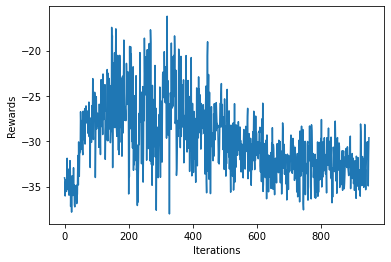

 95%|█████████████████████████████████████████████████████████████████████▍   | 95102/100000 [1:25:16<05:11, 15.74it/s]

Updated Weights
Mean Reward = -33.24
19


 95%|█████████████████████████████████████████████████████████████████████▍   | 95202/100000 [1:25:21<04:18, 18.54it/s]

Updated Weights
Mean Reward = -28.59
27


 95%|█████████████████████████████████████████████████████████████████████▌   | 95304/100000 [1:25:26<04:52, 16.05it/s]

Updated Weights
Mean Reward = -33.86
15


 95%|█████████████████████████████████████████████████████████████████████▋   | 95404/100000 [1:25:32<04:37, 16.58it/s]

Updated Weights
Mean Reward = -33.23
19


 96%|█████████████████████████████████████████████████████████████████████▋   | 95500/100000 [1:25:37<03:58, 18.91it/s]

Updated Weights
Mean Reward = -31.1
22


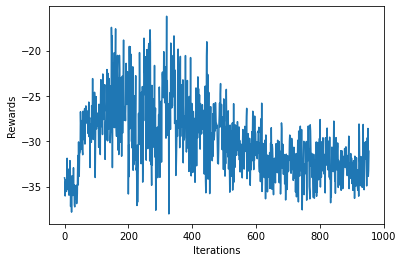

 96%|█████████████████████████████████████████████████████████████████████▊   | 95602/100000 [1:25:43<03:51, 18.99it/s]

Updated Weights
Mean Reward = -31.25
22


 96%|█████████████████████████████████████████████████████████████████████▊   | 95705/100000 [1:25:49<03:38, 19.68it/s]

Updated Weights
Mean Reward = -32.38
18


 96%|█████████████████████████████████████████████████████████████████████▉   | 95802/100000 [1:25:54<04:16, 16.38it/s]

Updated Weights
Mean Reward = -32.35
19


 96%|██████████████████████████████████████████████████████████████████████   | 95904/100000 [1:26:00<04:06, 16.60it/s]

Updated Weights
Mean Reward = -32.52
19


 96%|██████████████████████████████████████████████████████████████████████   | 96000/100000 [1:26:05<04:03, 16.45it/s]

Updated Weights
Mean Reward = -33.18
19


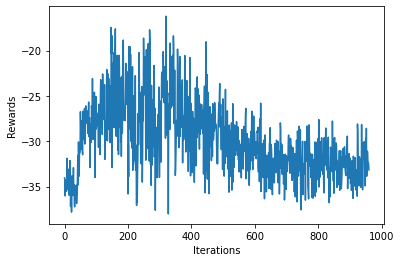

 96%|██████████████████████████████████████████████████████████████████████▏  | 96106/100000 [1:26:11<03:28, 18.69it/s]

Updated Weights
Mean Reward = -35.95
11


 96%|██████████████████████████████████████████████████████████████████████▏  | 96202/100000 [1:26:17<03:47, 16.66it/s]

Updated Weights
Mean Reward = -30.2
22


 96%|██████████████████████████████████████████████████████████████████████▎  | 96302/100000 [1:26:24<03:51, 15.98it/s]

Updated Weights
Mean Reward = -33.48
17


 96%|██████████████████████████████████████████████████████████████████████▎  | 96403/100000 [1:26:30<03:26, 17.46it/s]

Updated Weights
Mean Reward = -35.52
12


 96%|██████████████████████████████████████████████████████████████████████▍  | 96500/100000 [1:26:35<03:16, 17.78it/s]

Updated Weights
Mean Reward = -32.28
18


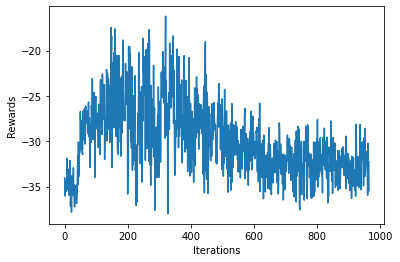

 97%|██████████████████████████████████████████████████████████████████████▌  | 96602/100000 [1:26:41<02:57, 19.16it/s]

Updated Weights
Mean Reward = -32.39
21


 97%|██████████████████████████████████████████████████████████████████████▌  | 96703/100000 [1:26:47<03:21, 16.34it/s]

Updated Weights
Mean Reward = -32.72
19


 97%|██████████████████████████████████████████████████████████████████████▋  | 96802/100000 [1:26:52<03:10, 16.76it/s]

Updated Weights
Mean Reward = -32.25
19


 97%|██████████████████████████████████████████████████████████████████████▋  | 96902/100000 [1:26:58<03:14, 15.94it/s]

Updated Weights
Mean Reward = -35.25
12


 97%|██████████████████████████████████████████████████████████████████████▊  | 96998/100000 [1:27:03<02:36, 19.24it/s]

Updated Weights
Mean Reward = -32.22
19


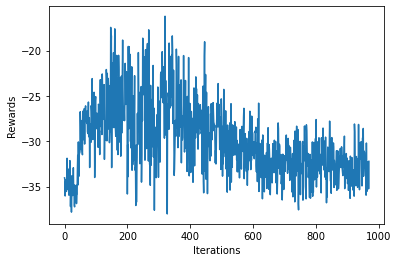

 97%|██████████████████████████████████████████████████████████████████████▉  | 97102/100000 [1:27:09<02:58, 16.20it/s]

Updated Weights
Mean Reward = -33.28
18


 97%|██████████████████████████████████████████████████████████████████████▉  | 97204/100000 [1:27:15<02:47, 16.71it/s]

Updated Weights
Mean Reward = -33.32
16


 97%|███████████████████████████████████████████████████████████████████████  | 97302/100000 [1:27:21<02:29, 18.04it/s]

Updated Weights
Mean Reward = -31.79
21


 97%|███████████████████████████████████████████████████████████████████████  | 97404/100000 [1:27:26<02:35, 16.74it/s]

Updated Weights
Mean Reward = -29.24
26


 97%|███████████████████████████████████████████████████████████████████████▏ | 97499/100000 [1:27:32<02:45, 15.12it/s]

Updated Weights
Mean Reward = -34.12
16


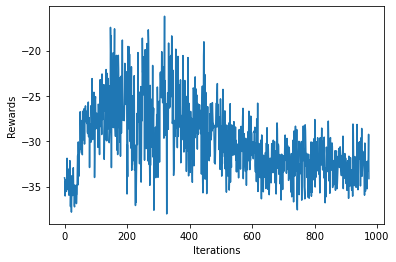

 98%|███████████████████████████████████████████████████████████████████████▎ | 97605/100000 [1:27:38<02:09, 18.42it/s]

Updated Weights
Mean Reward = -34.11
14


 98%|███████████████████████████████████████████████████████████████████████▎ | 97703/100000 [1:27:43<01:53, 20.15it/s]

Updated Weights
Mean Reward = -28.86
26


 98%|███████████████████████████████████████████████████████████████████████▍ | 97803/100000 [1:27:48<02:01, 18.04it/s]

Updated Weights
Mean Reward = -32.43
19


 98%|███████████████████████████████████████████████████████████████████████▍ | 97903/100000 [1:27:54<02:09, 16.23it/s]

Updated Weights
Mean Reward = -37.08
8


 98%|███████████████████████████████████████████████████████████████████████▌ | 97999/100000 [1:28:00<01:52, 17.75it/s]

Updated Weights
Mean Reward = -33.33
16


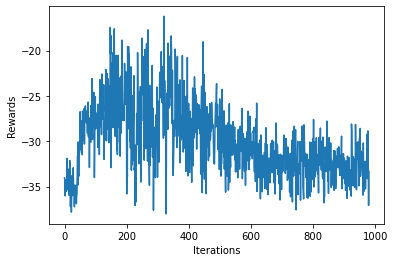

 98%|███████████████████████████████████████████████████████████████████████▌ | 98103/100000 [1:28:06<01:46, 17.81it/s]

Updated Weights
Mean Reward = -31.33
20


 98%|███████████████████████████████████████████████████████████████████████▋ | 98202/100000 [1:28:11<01:49, 16.48it/s]

Updated Weights
Mean Reward = -30.81
23


 98%|███████████████████████████████████████████████████████████████████████▊ | 98301/100000 [1:28:16<01:15, 22.39it/s]

Updated Weights
Mean Reward = -28.11
27


 98%|███████████████████████████████████████████████████████████████████████▊ | 98403/100000 [1:28:24<01:38, 16.21it/s]

Updated Weights
Mean Reward = -34.23
15


 98%|███████████████████████████████████████████████████████████████████████▉ | 98500/100000 [1:28:29<01:32, 16.17it/s]

Updated Weights
Mean Reward = -33.81
15


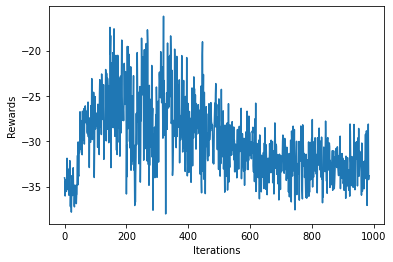

 99%|███████████████████████████████████████████████████████████████████████▉ | 98603/100000 [1:28:35<01:08, 20.37it/s]

Updated Weights
Mean Reward = -31.9
18


 99%|████████████████████████████████████████████████████████████████████████ | 98704/100000 [1:28:41<01:13, 17.51it/s]

Updated Weights
Mean Reward = -32.13
20


 99%|████████████████████████████████████████████████████████████████████████▏| 98805/100000 [1:28:47<01:01, 19.33it/s]

Updated Weights
Mean Reward = -33.5
19


 99%|████████████████████████████████████████████████████████████████████████▏| 98903/100000 [1:28:52<01:08, 16.08it/s]

Updated Weights
Mean Reward = -30.6
24


 99%|████████████████████████████████████████████████████████████████████████▎| 99000/100000 [1:28:57<00:54, 18.44it/s]

Updated Weights
Mean Reward = -33.01
16


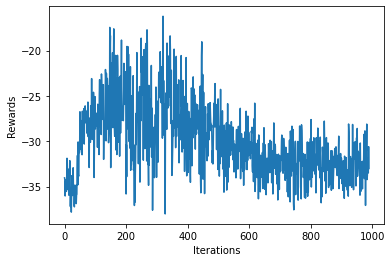

 99%|████████████████████████████████████████████████████████████████████████▎| 99104/100000 [1:29:04<00:51, 17.46it/s]

Updated Weights
Mean Reward = -31.45
21


 99%|████████████████████████████████████████████████████████████████████████▍| 99203/100000 [1:29:09<00:49, 16.08it/s]

Updated Weights
Mean Reward = -32.4
19


 99%|████████████████████████████████████████████████████████████████████████▍| 99303/100000 [1:29:15<00:44, 15.70it/s]

Updated Weights
Mean Reward = -31.88
20


 99%|████████████████████████████████████████████████████████████████████████▌| 99403/100000 [1:29:21<00:37, 15.77it/s]

Updated Weights
Mean Reward = -32.23
19


100%|████████████████████████████████████████████████████████████████████████▋| 99500/100000 [1:29:27<00:30, 16.64it/s]

Updated Weights
Mean Reward = -33.02
18


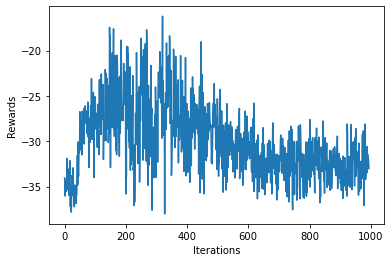

100%|████████████████████████████████████████████████████████████████████████▋| 99604/100000 [1:29:33<00:22, 17.41it/s]

Updated Weights
Mean Reward = -30.71
25


100%|████████████████████████████████████████████████████████████████████████▊| 99703/100000 [1:29:38<00:17, 16.61it/s]

Updated Weights
Mean Reward = -34.71
14


100%|████████████████████████████████████████████████████████████████████████▊| 99803/100000 [1:29:44<00:11, 17.76it/s]

Updated Weights
Mean Reward = -33.53
16


100%|████████████████████████████████████████████████████████████████████████▉| 99903/100000 [1:29:50<00:05, 16.80it/s]

Updated Weights
Mean Reward = -34.18
14


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:29:55<00:00, 18.53it/s]


In [6]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()

    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        print('Updated Weights')

       
    if epoch>50 and epoch%1000==0:
        user_agent.epsilon*=0.9
        user_agent.epsilon = max(user_agent.epsilon, 0.1)

    mean_rewards.append(episode_reward)
    if epoch%100==0 and epoch:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [7]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
while not done and step<max_steps:
    print(state)
    state = np.array(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1


[0.6, 0.8, 0.7, 0.3]
[0.6, 0.7, 0.7, 0.3]
[0.6, 0.6, 0.7, 0.3]
[0.6, 0.5, 0.7, 0.3]
[0.6, 0.4, 0.7, 0.3]
[0.6, 0.3, 0.7, 0.3]
[0.6, 0.2, 0.7, 0.3]
[0.6, 0.1, 0.7, 0.3]
[0.5, 0.1, 0.7, 0.3]
[0.5, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]
[0.4, 0.0, 0.7, 0.3]


In [8]:
print(done)

0


In [9]:
user_agent.model.save_weights('user_agent.h5')